# Architektur Neuronales Netz

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            #nn.LayerNorm(hidden1_size),
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            #nn.LayerNorm(hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            #nn.LayerNorm(hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 1)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=200, bias=True)
    (2): Tanh()
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): Tanh()
    (5): Linear(in_features=200, out_features=200, bias=True)
    (6): Tanh()
    (7): Linear(in_features=200, out_features=1, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 32 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_10000.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs xi
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
xi = torch.tensor(res['xi'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000

# T = torch.tensor(res['T']).float()
# p = torch.tensor(res['p']).float()
# x_0 = torch.tensor(res['x_0']).float()
# xi = torch.tensor(res['xi']).float()

# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = xi.reshape((-1,1))
#print(x_input.size())
# print(xi.size())

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 1)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)

#### Funktion zur Bestimmung der Genauigkeit

In [7]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred, y)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if pred[i] - y[i] <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE

#### Training

In [8]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients

#         # Record the correct predictions for training data
#         _, predictions = torch.max(pred.data, 1)
#         train_correct += (predictions == y.data).sum()                
#         train_total += predictions.size(0)    

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping
    #train_loss.append(loss.item())
    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)

#     loss = criterion(outputs, Variable(test_classes))
#     test_loss.append(loss.data[0])

Epoch 1/200, Iteration 1/250, Loss: 0.1403
Epoch 1/200, Iteration 2/250, Loss: 1.2192
Epoch 1/200, Iteration 3/250, Loss: 2.8638
Epoch 1/200, Iteration 4/250, Loss: 2.1933
Epoch 1/200, Iteration 5/250, Loss: 0.9685
Epoch 1/200, Iteration 6/250, Loss: 0.3322
Epoch 1/200, Iteration 7/250, Loss: 0.8092
Epoch 1/200, Iteration 8/250, Loss: 0.6676
Epoch 1/200, Iteration 9/250, Loss: 0.3114
Epoch 1/200, Iteration 10/250, Loss: 0.4122
Epoch 1/200, Iteration 11/250, Loss: 0.3572
Epoch 1/200, Iteration 12/250, Loss: 0.3870
Epoch 1/200, Iteration 13/250, Loss: 0.4383
Epoch 1/200, Iteration 14/250, Loss: 0.3826
Epoch 1/200, Iteration 15/250, Loss: 0.1650
Epoch 1/200, Iteration 16/250, Loss: 0.2924
Epoch 1/200, Iteration 17/250, Loss: 0.4616
Epoch 1/200, Iteration 18/250, Loss: 0.3874
Epoch 1/200, Iteration 19/250, Loss: 0.1624
Epoch 1/200, Iteration 20/250, Loss: 0.2440
Epoch 1/200, Iteration 21/250, Loss: 0.3348
Epoch 1/200, Iteration 22/250, Loss: 0.2210
Epoch 1/200, Iteration 23/250, Loss: 0.25

Epoch 1/200, Iteration 215/250, Loss: 0.1176
Epoch 1/200, Iteration 216/250, Loss: 0.0510
Epoch 1/200, Iteration 217/250, Loss: 0.0699
Epoch 1/200, Iteration 218/250, Loss: 0.0483
Epoch 1/200, Iteration 219/250, Loss: 0.0554
Epoch 1/200, Iteration 220/250, Loss: 0.0593
Epoch 1/200, Iteration 221/250, Loss: 0.0766
Epoch 1/200, Iteration 222/250, Loss: 0.0831
Epoch 1/200, Iteration 223/250, Loss: 0.0323
Epoch 1/200, Iteration 224/250, Loss: 0.0400
Epoch 1/200, Iteration 225/250, Loss: 0.0411
Epoch 1/200, Iteration 226/250, Loss: 0.0444
Epoch 1/200, Iteration 227/250, Loss: 0.0820
Epoch 1/200, Iteration 228/250, Loss: 0.0510
Epoch 1/200, Iteration 229/250, Loss: 0.0604
Epoch 1/200, Iteration 230/250, Loss: 0.0479
Epoch 1/200, Iteration 231/250, Loss: 0.0672
Epoch 1/200, Iteration 232/250, Loss: 0.0364
Epoch 1/200, Iteration 233/250, Loss: 0.0728
Epoch 1/200, Iteration 234/250, Loss: 0.0448
Epoch 1/200, Iteration 235/250, Loss: 0.0475
Epoch 1/200, Iteration 236/250, Loss: 0.0651
Epoch 1/20

Epoch 2/200, Iteration 154/250, Loss: 0.1026
Epoch 2/200, Iteration 155/250, Loss: 0.1004
Epoch 2/200, Iteration 156/250, Loss: 0.0646
Epoch 2/200, Iteration 157/250, Loss: 0.0894
Epoch 2/200, Iteration 158/250, Loss: 0.0928
Epoch 2/200, Iteration 159/250, Loss: 0.0581
Epoch 2/200, Iteration 160/250, Loss: 0.0918
Epoch 2/200, Iteration 161/250, Loss: 0.0789
Epoch 2/200, Iteration 162/250, Loss: 0.0852
Epoch 2/200, Iteration 163/250, Loss: 0.0497
Epoch 2/200, Iteration 164/250, Loss: 0.1209
Epoch 2/200, Iteration 165/250, Loss: 0.0924
Epoch 2/200, Iteration 166/250, Loss: 0.1113
Epoch 2/200, Iteration 167/250, Loss: 0.1027
Epoch 2/200, Iteration 168/250, Loss: 0.0692
Epoch 2/200, Iteration 169/250, Loss: 0.1536
Epoch 2/200, Iteration 170/250, Loss: 0.1047
Epoch 2/200, Iteration 171/250, Loss: 0.1001
Epoch 2/200, Iteration 172/250, Loss: 0.1370
Epoch 2/200, Iteration 173/250, Loss: 0.0508
Epoch 2/200, Iteration 174/250, Loss: 0.1106
Epoch 2/200, Iteration 175/250, Loss: 0.1368
Epoch 2/20

Epoch 3/200, Iteration 86/250, Loss: 0.0282
Epoch 3/200, Iteration 87/250, Loss: 0.0504
Epoch 3/200, Iteration 88/250, Loss: 0.0672
Epoch 3/200, Iteration 89/250, Loss: 0.0294
Epoch 3/200, Iteration 90/250, Loss: 0.0349
Epoch 3/200, Iteration 91/250, Loss: 0.0319
Epoch 3/200, Iteration 92/250, Loss: 0.0400
Epoch 3/200, Iteration 93/250, Loss: 0.0279
Epoch 3/200, Iteration 94/250, Loss: 0.0308
Epoch 3/200, Iteration 95/250, Loss: 0.0236
Epoch 3/200, Iteration 96/250, Loss: 0.0566
Epoch 3/200, Iteration 97/250, Loss: 0.0486
Epoch 3/200, Iteration 98/250, Loss: 0.0473
Epoch 3/200, Iteration 99/250, Loss: 0.0354
Epoch 3/200, Iteration 100/250, Loss: 0.0435
Epoch 3/200, Iteration 101/250, Loss: 0.0282
Epoch 3/200, Iteration 102/250, Loss: 0.0826
Epoch 3/200, Iteration 103/250, Loss: 0.0464
Epoch 3/200, Iteration 104/250, Loss: 0.0317
Epoch 3/200, Iteration 105/250, Loss: 0.0342
Epoch 3/200, Iteration 106/250, Loss: 0.0806
Epoch 3/200, Iteration 107/250, Loss: 0.0328
Epoch 3/200, Iteration 1

Epoch 4/200, Iteration 21/250, Loss: 0.0680
Epoch 4/200, Iteration 22/250, Loss: 0.0674
Epoch 4/200, Iteration 23/250, Loss: 0.0361
Epoch 4/200, Iteration 24/250, Loss: 0.0338
Epoch 4/200, Iteration 25/250, Loss: 0.0306
Epoch 4/200, Iteration 26/250, Loss: 0.0424
Epoch 4/200, Iteration 27/250, Loss: 0.0308
Epoch 4/200, Iteration 28/250, Loss: 0.0378
Epoch 4/200, Iteration 29/250, Loss: 0.0472
Epoch 4/200, Iteration 30/250, Loss: 0.0348
Epoch 4/200, Iteration 31/250, Loss: 0.0267
Epoch 4/200, Iteration 32/250, Loss: 0.0251
Epoch 4/200, Iteration 33/250, Loss: 0.0290
Epoch 4/200, Iteration 34/250, Loss: 0.0292
Epoch 4/200, Iteration 35/250, Loss: 0.0207
Epoch 4/200, Iteration 36/250, Loss: 0.0206
Epoch 4/200, Iteration 37/250, Loss: 0.0291
Epoch 4/200, Iteration 38/250, Loss: 0.0175
Epoch 4/200, Iteration 39/250, Loss: 0.0428
Epoch 4/200, Iteration 40/250, Loss: 0.0216
Epoch 4/200, Iteration 41/250, Loss: 0.0169
Epoch 4/200, Iteration 42/250, Loss: 0.0236
Epoch 4/200, Iteration 43/250, L

Epoch 4/200, Iteration 226/250, Loss: 0.0196
Epoch 4/200, Iteration 227/250, Loss: 0.0226
Epoch 4/200, Iteration 228/250, Loss: 0.0276
Epoch 4/200, Iteration 229/250, Loss: 0.0247
Epoch 4/200, Iteration 230/250, Loss: 0.0383
Epoch 4/200, Iteration 231/250, Loss: 0.0418
Epoch 4/200, Iteration 232/250, Loss: 0.0282
Epoch 4/200, Iteration 233/250, Loss: 0.0435
Epoch 4/200, Iteration 234/250, Loss: 0.0386
Epoch 4/200, Iteration 235/250, Loss: 0.0400
Epoch 4/200, Iteration 236/250, Loss: 0.0464
Epoch 4/200, Iteration 237/250, Loss: 0.0389
Epoch 4/200, Iteration 238/250, Loss: 0.0239
Epoch 4/200, Iteration 239/250, Loss: 0.0467
Epoch 4/200, Iteration 240/250, Loss: 0.0396
Epoch 4/200, Iteration 241/250, Loss: 0.0268
Epoch 4/200, Iteration 242/250, Loss: 0.0280
Epoch 4/200, Iteration 243/250, Loss: 0.0275
Epoch 4/200, Iteration 244/250, Loss: 0.0290
Epoch 4/200, Iteration 245/250, Loss: 0.0448
Epoch 4/200, Iteration 246/250, Loss: 0.0377
Epoch 4/200, Iteration 247/250, Loss: 0.0198
Epoch 4/20

Epoch 5/200, Iteration 169/250, Loss: 0.0443
Epoch 5/200, Iteration 170/250, Loss: 0.0365
Epoch 5/200, Iteration 171/250, Loss: 0.0209
Epoch 5/200, Iteration 172/250, Loss: 0.0341
Epoch 5/200, Iteration 173/250, Loss: 0.0368
Epoch 5/200, Iteration 174/250, Loss: 0.0466
Epoch 5/200, Iteration 175/250, Loss: 0.0236
Epoch 5/200, Iteration 176/250, Loss: 0.0241
Epoch 5/200, Iteration 177/250, Loss: 0.0228
Epoch 5/200, Iteration 178/250, Loss: 0.0272
Epoch 5/200, Iteration 179/250, Loss: 0.0398
Epoch 5/200, Iteration 180/250, Loss: 0.0215
Epoch 5/200, Iteration 181/250, Loss: 0.0319
Epoch 5/200, Iteration 182/250, Loss: 0.0401
Epoch 5/200, Iteration 183/250, Loss: 0.0188
Epoch 5/200, Iteration 184/250, Loss: 0.0207
Epoch 5/200, Iteration 185/250, Loss: 0.0140
Epoch 5/200, Iteration 186/250, Loss: 0.0240
Epoch 5/200, Iteration 187/250, Loss: 0.0199
Epoch 5/200, Iteration 188/250, Loss: 0.0248
Epoch 5/200, Iteration 189/250, Loss: 0.0456
Epoch 5/200, Iteration 190/250, Loss: 0.0339
Epoch 5/20

Epoch 6/200, Iteration 128/250, Loss: 0.0171
Epoch 6/200, Iteration 129/250, Loss: 0.0203
Epoch 6/200, Iteration 130/250, Loss: 0.0275
Epoch 6/200, Iteration 131/250, Loss: 0.0323
Epoch 6/200, Iteration 132/250, Loss: 0.0141
Epoch 6/200, Iteration 133/250, Loss: 0.0296
Epoch 6/200, Iteration 134/250, Loss: 0.0140
Epoch 6/200, Iteration 135/250, Loss: 0.0183
Epoch 6/200, Iteration 136/250, Loss: 0.0124
Epoch 6/200, Iteration 137/250, Loss: 0.0142
Epoch 6/200, Iteration 138/250, Loss: 0.0342
Epoch 6/200, Iteration 139/250, Loss: 0.0525
Epoch 6/200, Iteration 140/250, Loss: 0.0135
Epoch 6/200, Iteration 141/250, Loss: 0.0421
Epoch 6/200, Iteration 142/250, Loss: 0.0277
Epoch 6/200, Iteration 143/250, Loss: 0.0143
Epoch 6/200, Iteration 144/250, Loss: 0.0201
Epoch 6/200, Iteration 145/250, Loss: 0.0442
Epoch 6/200, Iteration 146/250, Loss: 0.0521
Epoch 6/200, Iteration 147/250, Loss: 0.0326
Epoch 6/200, Iteration 148/250, Loss: 0.0210
Epoch 6/200, Iteration 149/250, Loss: 0.0359
Epoch 6/20

Epoch 7/200, Iteration 77/250, Loss: 0.0182
Epoch 7/200, Iteration 78/250, Loss: 0.0343
Epoch 7/200, Iteration 79/250, Loss: 0.0312
Epoch 7/200, Iteration 80/250, Loss: 0.0279
Epoch 7/200, Iteration 81/250, Loss: 0.0163
Epoch 7/200, Iteration 82/250, Loss: 0.0156
Epoch 7/200, Iteration 83/250, Loss: 0.0128
Epoch 7/200, Iteration 84/250, Loss: 0.0224
Epoch 7/200, Iteration 85/250, Loss: 0.0147
Epoch 7/200, Iteration 86/250, Loss: 0.0274
Epoch 7/200, Iteration 87/250, Loss: 0.0192
Epoch 7/200, Iteration 88/250, Loss: 0.0207
Epoch 7/200, Iteration 89/250, Loss: 0.0179
Epoch 7/200, Iteration 90/250, Loss: 0.0145
Epoch 7/200, Iteration 91/250, Loss: 0.0163
Epoch 7/200, Iteration 92/250, Loss: 0.0323
Epoch 7/200, Iteration 93/250, Loss: 0.0236
Epoch 7/200, Iteration 94/250, Loss: 0.0476
Epoch 7/200, Iteration 95/250, Loss: 0.0238
Epoch 7/200, Iteration 96/250, Loss: 0.0198
Epoch 7/200, Iteration 97/250, Loss: 0.0147
Epoch 7/200, Iteration 98/250, Loss: 0.0176
Epoch 7/200, Iteration 99/250, L

Epoch 8/200, Iteration 23/250, Loss: 0.0216
Epoch 8/200, Iteration 24/250, Loss: 0.0396
Epoch 8/200, Iteration 25/250, Loss: 0.0303
Epoch 8/200, Iteration 26/250, Loss: 0.0170
Epoch 8/200, Iteration 27/250, Loss: 0.0142
Epoch 8/200, Iteration 28/250, Loss: 0.0218
Epoch 8/200, Iteration 29/250, Loss: 0.0242
Epoch 8/200, Iteration 30/250, Loss: 0.0210
Epoch 8/200, Iteration 31/250, Loss: 0.0391
Epoch 8/200, Iteration 32/250, Loss: 0.0191
Epoch 8/200, Iteration 33/250, Loss: 0.0208
Epoch 8/200, Iteration 34/250, Loss: 0.0182
Epoch 8/200, Iteration 35/250, Loss: 0.0326
Epoch 8/200, Iteration 36/250, Loss: 0.0151
Epoch 8/200, Iteration 37/250, Loss: 0.0211
Epoch 8/200, Iteration 38/250, Loss: 0.0261
Epoch 8/200, Iteration 39/250, Loss: 0.0276
Epoch 8/200, Iteration 40/250, Loss: 0.0175
Epoch 8/200, Iteration 41/250, Loss: 0.0262
Epoch 8/200, Iteration 42/250, Loss: 0.0241
Epoch 8/200, Iteration 43/250, Loss: 0.0185
Epoch 8/200, Iteration 44/250, Loss: 0.0175
Epoch 8/200, Iteration 45/250, L

Epoch 8/200, Iteration 217/250, Loss: 0.0146
Epoch 8/200, Iteration 218/250, Loss: 0.0302
Epoch 8/200, Iteration 219/250, Loss: 0.0223
Epoch 8/200, Iteration 220/250, Loss: 0.0232
Epoch 8/200, Iteration 221/250, Loss: 0.0261
Epoch 8/200, Iteration 222/250, Loss: 0.0152
Epoch 8/200, Iteration 223/250, Loss: 0.0299
Epoch 8/200, Iteration 224/250, Loss: 0.0363
Epoch 8/200, Iteration 225/250, Loss: 0.0142
Epoch 8/200, Iteration 226/250, Loss: 0.0142
Epoch 8/200, Iteration 227/250, Loss: 0.0140
Epoch 8/200, Iteration 228/250, Loss: 0.0099
Epoch 8/200, Iteration 229/250, Loss: 0.0355
Epoch 8/200, Iteration 230/250, Loss: 0.0181
Epoch 8/200, Iteration 231/250, Loss: 0.0179
Epoch 8/200, Iteration 232/250, Loss: 0.0237
Epoch 8/200, Iteration 233/250, Loss: 0.0179
Epoch 8/200, Iteration 234/250, Loss: 0.0424
Epoch 8/200, Iteration 235/250, Loss: 0.0236
Epoch 8/200, Iteration 236/250, Loss: 0.0222
Epoch 8/200, Iteration 237/250, Loss: 0.0232
Epoch 8/200, Iteration 238/250, Loss: 0.0096
Epoch 8/20

Epoch 9/200, Iteration 176/250, Loss: 0.0207
Epoch 9/200, Iteration 177/250, Loss: 0.0198
Epoch 9/200, Iteration 178/250, Loss: 0.0225
Epoch 9/200, Iteration 179/250, Loss: 0.0246
Epoch 9/200, Iteration 180/250, Loss: 0.0249
Epoch 9/200, Iteration 181/250, Loss: 0.0344
Epoch 9/200, Iteration 182/250, Loss: 0.0201
Epoch 9/200, Iteration 183/250, Loss: 0.0192
Epoch 9/200, Iteration 184/250, Loss: 0.0153
Epoch 9/200, Iteration 185/250, Loss: 0.0183
Epoch 9/200, Iteration 186/250, Loss: 0.0204
Epoch 9/200, Iteration 187/250, Loss: 0.0435
Epoch 9/200, Iteration 188/250, Loss: 0.0254
Epoch 9/200, Iteration 189/250, Loss: 0.0178
Epoch 9/200, Iteration 190/250, Loss: 0.0252
Epoch 9/200, Iteration 191/250, Loss: 0.0084
Epoch 9/200, Iteration 192/250, Loss: 0.0134
Epoch 9/200, Iteration 193/250, Loss: 0.0138
Epoch 9/200, Iteration 194/250, Loss: 0.0331
Epoch 9/200, Iteration 195/250, Loss: 0.0114
Epoch 9/200, Iteration 196/250, Loss: 0.0216
Epoch 9/200, Iteration 197/250, Loss: 0.0178
Epoch 9/20

Epoch 10/200, Iteration 131/250, Loss: 0.0228
Epoch 10/200, Iteration 132/250, Loss: 0.0129
Epoch 10/200, Iteration 133/250, Loss: 0.0199
Epoch 10/200, Iteration 134/250, Loss: 0.0320
Epoch 10/200, Iteration 135/250, Loss: 0.0290
Epoch 10/200, Iteration 136/250, Loss: 0.0208
Epoch 10/200, Iteration 137/250, Loss: 0.0179
Epoch 10/200, Iteration 138/250, Loss: 0.0296
Epoch 10/200, Iteration 139/250, Loss: 0.0152
Epoch 10/200, Iteration 140/250, Loss: 0.0574
Epoch 10/200, Iteration 141/250, Loss: 0.0110
Epoch 10/200, Iteration 142/250, Loss: 0.0254
Epoch 10/200, Iteration 143/250, Loss: 0.0345
Epoch 10/200, Iteration 144/250, Loss: 0.0196
Epoch 10/200, Iteration 145/250, Loss: 0.0282
Epoch 10/200, Iteration 146/250, Loss: 0.0150
Epoch 10/200, Iteration 147/250, Loss: 0.0099
Epoch 10/200, Iteration 148/250, Loss: 0.0146
Epoch 10/200, Iteration 149/250, Loss: 0.0367
Epoch 10/200, Iteration 150/250, Loss: 0.0134
Epoch 10/200, Iteration 151/250, Loss: 0.0517
Epoch 10/200, Iteration 152/250, L

Epoch 11/200, Iteration 90/250, Loss: 0.0283
Epoch 11/200, Iteration 91/250, Loss: 0.0172
Epoch 11/200, Iteration 92/250, Loss: 0.0170
Epoch 11/200, Iteration 93/250, Loss: 0.0156
Epoch 11/200, Iteration 94/250, Loss: 0.0150
Epoch 11/200, Iteration 95/250, Loss: 0.0369
Epoch 11/200, Iteration 96/250, Loss: 0.0271
Epoch 11/200, Iteration 97/250, Loss: 0.0178
Epoch 11/200, Iteration 98/250, Loss: 0.0320
Epoch 11/200, Iteration 99/250, Loss: 0.0220
Epoch 11/200, Iteration 100/250, Loss: 0.0339
Epoch 11/200, Iteration 101/250, Loss: 0.0327
Epoch 11/200, Iteration 102/250, Loss: 0.0356
Epoch 11/200, Iteration 103/250, Loss: 0.0118
Epoch 11/200, Iteration 104/250, Loss: 0.0211
Epoch 11/200, Iteration 105/250, Loss: 0.0280
Epoch 11/200, Iteration 106/250, Loss: 0.0182
Epoch 11/200, Iteration 107/250, Loss: 0.0244
Epoch 11/200, Iteration 108/250, Loss: 0.0244
Epoch 11/200, Iteration 109/250, Loss: 0.0179
Epoch 11/200, Iteration 110/250, Loss: 0.0231
Epoch 11/200, Iteration 111/250, Loss: 0.033

Epoch 12/200, Iteration 53/250, Loss: 0.0340
Epoch 12/200, Iteration 54/250, Loss: 0.0229
Epoch 12/200, Iteration 55/250, Loss: 0.0290
Epoch 12/200, Iteration 56/250, Loss: 0.0242
Epoch 12/200, Iteration 57/250, Loss: 0.0259
Epoch 12/200, Iteration 58/250, Loss: 0.0236
Epoch 12/200, Iteration 59/250, Loss: 0.0184
Epoch 12/200, Iteration 60/250, Loss: 0.0245
Epoch 12/200, Iteration 61/250, Loss: 0.0308
Epoch 12/200, Iteration 62/250, Loss: 0.0205
Epoch 12/200, Iteration 63/250, Loss: 0.0187
Epoch 12/200, Iteration 64/250, Loss: 0.0232
Epoch 12/200, Iteration 65/250, Loss: 0.0238
Epoch 12/200, Iteration 66/250, Loss: 0.0324
Epoch 12/200, Iteration 67/250, Loss: 0.0262
Epoch 12/200, Iteration 68/250, Loss: 0.0182
Epoch 12/200, Iteration 69/250, Loss: 0.0151
Epoch 12/200, Iteration 70/250, Loss: 0.0199
Epoch 12/200, Iteration 71/250, Loss: 0.0252
Epoch 12/200, Iteration 72/250, Loss: 0.0383
Epoch 12/200, Iteration 73/250, Loss: 0.0243
Epoch 12/200, Iteration 74/250, Loss: 0.0244
Epoch 12/2

Train Error: 
 Accuracy: 68.21%, Avg loss: 0.011782, MRE: 0.812502 

Test Error: 
 Accuracy: 67.2%, Avg loss: 0.011836, MRE: 1.174911 

Epoch 13/200, Iteration 1/250, Loss: 0.0165
Epoch 13/200, Iteration 2/250, Loss: 0.0245
Epoch 13/200, Iteration 3/250, Loss: 0.0197
Epoch 13/200, Iteration 4/250, Loss: 0.0272
Epoch 13/200, Iteration 5/250, Loss: 0.0228
Epoch 13/200, Iteration 6/250, Loss: 0.0149
Epoch 13/200, Iteration 7/250, Loss: 0.0256
Epoch 13/200, Iteration 8/250, Loss: 0.0144
Epoch 13/200, Iteration 9/250, Loss: 0.0365
Epoch 13/200, Iteration 10/250, Loss: 0.0264
Epoch 13/200, Iteration 11/250, Loss: 0.0149
Epoch 13/200, Iteration 12/250, Loss: 0.0457
Epoch 13/200, Iteration 13/250, Loss: 0.0293
Epoch 13/200, Iteration 14/250, Loss: 0.0360
Epoch 13/200, Iteration 15/250, Loss: 0.0169
Epoch 13/200, Iteration 16/250, Loss: 0.0329
Epoch 13/200, Iteration 17/250, Loss: 0.0216
Epoch 13/200, Iteration 18/250, Loss: 0.0311
Epoch 13/200, Iteration 19/250, Loss: 0.0177
Epoch 13/200, Iter

Epoch 13/200, Iteration 212/250, Loss: 0.0149
Epoch 13/200, Iteration 213/250, Loss: 0.0179
Epoch 13/200, Iteration 214/250, Loss: 0.0224
Epoch 13/200, Iteration 215/250, Loss: 0.0199
Epoch 13/200, Iteration 216/250, Loss: 0.0423
Epoch 13/200, Iteration 217/250, Loss: 0.0108
Epoch 13/200, Iteration 218/250, Loss: 0.0178
Epoch 13/200, Iteration 219/250, Loss: 0.0130
Epoch 13/200, Iteration 220/250, Loss: 0.0118
Epoch 13/200, Iteration 221/250, Loss: 0.0121
Epoch 13/200, Iteration 222/250, Loss: 0.0116
Epoch 13/200, Iteration 223/250, Loss: 0.0109
Epoch 13/200, Iteration 224/250, Loss: 0.0217
Epoch 13/200, Iteration 225/250, Loss: 0.0144
Epoch 13/200, Iteration 226/250, Loss: 0.0255
Epoch 13/200, Iteration 227/250, Loss: 0.0338
Epoch 13/200, Iteration 228/250, Loss: 0.0161
Epoch 13/200, Iteration 229/250, Loss: 0.0390
Epoch 13/200, Iteration 230/250, Loss: 0.0192
Epoch 13/200, Iteration 231/250, Loss: 0.0195
Epoch 13/200, Iteration 232/250, Loss: 0.0307
Epoch 13/200, Iteration 233/250, L

Epoch 14/200, Iteration 164/250, Loss: 0.0184
Epoch 14/200, Iteration 165/250, Loss: 0.0094
Epoch 14/200, Iteration 166/250, Loss: 0.0195
Epoch 14/200, Iteration 167/250, Loss: 0.0222
Epoch 14/200, Iteration 168/250, Loss: 0.0178
Epoch 14/200, Iteration 169/250, Loss: 0.0114
Epoch 14/200, Iteration 170/250, Loss: 0.0146
Epoch 14/200, Iteration 171/250, Loss: 0.0159
Epoch 14/200, Iteration 172/250, Loss: 0.0314
Epoch 14/200, Iteration 173/250, Loss: 0.0365
Epoch 14/200, Iteration 174/250, Loss: 0.0138
Epoch 14/200, Iteration 175/250, Loss: 0.0301
Epoch 14/200, Iteration 176/250, Loss: 0.0318
Epoch 14/200, Iteration 177/250, Loss: 0.0141
Epoch 14/200, Iteration 178/250, Loss: 0.0121
Epoch 14/200, Iteration 179/250, Loss: 0.0136
Epoch 14/200, Iteration 180/250, Loss: 0.0366
Epoch 14/200, Iteration 181/250, Loss: 0.0334
Epoch 14/200, Iteration 182/250, Loss: 0.0439
Epoch 14/200, Iteration 183/250, Loss: 0.0293
Epoch 14/200, Iteration 184/250, Loss: 0.0346
Epoch 14/200, Iteration 185/250, L

Epoch 15/200, Iteration 93/250, Loss: 0.0107
Epoch 15/200, Iteration 94/250, Loss: 0.0284
Epoch 15/200, Iteration 95/250, Loss: 0.0115
Epoch 15/200, Iteration 96/250, Loss: 0.0301
Epoch 15/200, Iteration 97/250, Loss: 0.0167
Epoch 15/200, Iteration 98/250, Loss: 0.0128
Epoch 15/200, Iteration 99/250, Loss: 0.0180
Epoch 15/200, Iteration 100/250, Loss: 0.0137
Epoch 15/200, Iteration 101/250, Loss: 0.0181
Epoch 15/200, Iteration 102/250, Loss: 0.0191
Epoch 15/200, Iteration 103/250, Loss: 0.0162
Epoch 15/200, Iteration 104/250, Loss: 0.0240
Epoch 15/200, Iteration 105/250, Loss: 0.0173
Epoch 15/200, Iteration 106/250, Loss: 0.0269
Epoch 15/200, Iteration 107/250, Loss: 0.0257
Epoch 15/200, Iteration 108/250, Loss: 0.0212
Epoch 15/200, Iteration 109/250, Loss: 0.0198
Epoch 15/200, Iteration 110/250, Loss: 0.0168
Epoch 15/200, Iteration 111/250, Loss: 0.0152
Epoch 15/200, Iteration 112/250, Loss: 0.0274
Epoch 15/200, Iteration 113/250, Loss: 0.0166
Epoch 15/200, Iteration 114/250, Loss: 0.

Epoch 16/200, Iteration 23/250, Loss: 0.0230
Epoch 16/200, Iteration 24/250, Loss: 0.0323
Epoch 16/200, Iteration 25/250, Loss: 0.0302
Epoch 16/200, Iteration 26/250, Loss: 0.0154
Epoch 16/200, Iteration 27/250, Loss: 0.0176
Epoch 16/200, Iteration 28/250, Loss: 0.0209
Epoch 16/200, Iteration 29/250, Loss: 0.0132
Epoch 16/200, Iteration 30/250, Loss: 0.0312
Epoch 16/200, Iteration 31/250, Loss: 0.0198
Epoch 16/200, Iteration 32/250, Loss: 0.0446
Epoch 16/200, Iteration 33/250, Loss: 0.0277
Epoch 16/200, Iteration 34/250, Loss: 0.0191
Epoch 16/200, Iteration 35/250, Loss: 0.0189
Epoch 16/200, Iteration 36/250, Loss: 0.0208
Epoch 16/200, Iteration 37/250, Loss: 0.0173
Epoch 16/200, Iteration 38/250, Loss: 0.0191
Epoch 16/200, Iteration 39/250, Loss: 0.0399
Epoch 16/200, Iteration 40/250, Loss: 0.0241
Epoch 16/200, Iteration 41/250, Loss: 0.0354
Epoch 16/200, Iteration 42/250, Loss: 0.0426
Epoch 16/200, Iteration 43/250, Loss: 0.0311
Epoch 16/200, Iteration 44/250, Loss: 0.0271
Epoch 16/2

Epoch 16/200, Iteration 209/250, Loss: 0.0228
Epoch 16/200, Iteration 210/250, Loss: 0.0220
Epoch 16/200, Iteration 211/250, Loss: 0.0168
Epoch 16/200, Iteration 212/250, Loss: 0.0240
Epoch 16/200, Iteration 213/250, Loss: 0.0386
Epoch 16/200, Iteration 214/250, Loss: 0.0198
Epoch 16/200, Iteration 215/250, Loss: 0.0231
Epoch 16/200, Iteration 216/250, Loss: 0.0264
Epoch 16/200, Iteration 217/250, Loss: 0.0227
Epoch 16/200, Iteration 218/250, Loss: 0.0105
Epoch 16/200, Iteration 219/250, Loss: 0.0137
Epoch 16/200, Iteration 220/250, Loss: 0.0136
Epoch 16/200, Iteration 221/250, Loss: 0.0243
Epoch 16/200, Iteration 222/250, Loss: 0.0313
Epoch 16/200, Iteration 223/250, Loss: 0.0258
Epoch 16/200, Iteration 224/250, Loss: 0.0298
Epoch 16/200, Iteration 225/250, Loss: 0.0316
Epoch 16/200, Iteration 226/250, Loss: 0.0229
Epoch 16/200, Iteration 227/250, Loss: 0.0201
Epoch 16/200, Iteration 228/250, Loss: 0.0223
Epoch 16/200, Iteration 229/250, Loss: 0.0324
Epoch 16/200, Iteration 230/250, L

Epoch 17/200, Iteration 137/250, Loss: 0.0377
Epoch 17/200, Iteration 138/250, Loss: 0.0282
Epoch 17/200, Iteration 139/250, Loss: 0.0188
Epoch 17/200, Iteration 140/250, Loss: 0.0204
Epoch 17/200, Iteration 141/250, Loss: 0.0647
Epoch 17/200, Iteration 142/250, Loss: 0.0343
Epoch 17/200, Iteration 143/250, Loss: 0.0225
Epoch 17/200, Iteration 144/250, Loss: 0.0292
Epoch 17/200, Iteration 145/250, Loss: 0.0239
Epoch 17/200, Iteration 146/250, Loss: 0.0186
Epoch 17/200, Iteration 147/250, Loss: 0.0333
Epoch 17/200, Iteration 148/250, Loss: 0.0218
Epoch 17/200, Iteration 149/250, Loss: 0.0373
Epoch 17/200, Iteration 150/250, Loss: 0.0216
Epoch 17/200, Iteration 151/250, Loss: 0.0332
Epoch 17/200, Iteration 152/250, Loss: 0.0353
Epoch 17/200, Iteration 153/250, Loss: 0.0329
Epoch 17/200, Iteration 154/250, Loss: 0.0179
Epoch 17/200, Iteration 155/250, Loss: 0.0181
Epoch 17/200, Iteration 156/250, Loss: 0.0124
Epoch 17/200, Iteration 157/250, Loss: 0.0148
Epoch 17/200, Iteration 158/250, L

Epoch 18/200, Iteration 72/250, Loss: 0.0423
Epoch 18/200, Iteration 73/250, Loss: 0.0134
Epoch 18/200, Iteration 74/250, Loss: 0.0151
Epoch 18/200, Iteration 75/250, Loss: 0.0121
Epoch 18/200, Iteration 76/250, Loss: 0.0307
Epoch 18/200, Iteration 77/250, Loss: 0.0357
Epoch 18/200, Iteration 78/250, Loss: 0.0137
Epoch 18/200, Iteration 79/250, Loss: 0.0233
Epoch 18/200, Iteration 80/250, Loss: 0.0204
Epoch 18/200, Iteration 81/250, Loss: 0.0309
Epoch 18/200, Iteration 82/250, Loss: 0.0236
Epoch 18/200, Iteration 83/250, Loss: 0.0299
Epoch 18/200, Iteration 84/250, Loss: 0.0345
Epoch 18/200, Iteration 85/250, Loss: 0.0429
Epoch 18/200, Iteration 86/250, Loss: 0.0189
Epoch 18/200, Iteration 87/250, Loss: 0.0196
Epoch 18/200, Iteration 88/250, Loss: 0.0148
Epoch 18/200, Iteration 89/250, Loss: 0.0184
Epoch 18/200, Iteration 90/250, Loss: 0.0153
Epoch 18/200, Iteration 91/250, Loss: 0.0168
Epoch 18/200, Iteration 92/250, Loss: 0.0221
Epoch 18/200, Iteration 93/250, Loss: 0.0181
Epoch 18/2

Train Error: 
 Accuracy: 52.2%, Avg loss: 0.015504, MRE: 1.641005 

Test Error: 
 Accuracy: 52.05%, Avg loss: 0.015490, MRE: 1.658647 

Epoch 19/200, Iteration 1/250, Loss: 0.0368
Epoch 19/200, Iteration 2/250, Loss: 0.0228
Epoch 19/200, Iteration 3/250, Loss: 0.0343
Epoch 19/200, Iteration 4/250, Loss: 0.0185
Epoch 19/200, Iteration 5/250, Loss: 0.0190
Epoch 19/200, Iteration 6/250, Loss: 0.0095
Epoch 19/200, Iteration 7/250, Loss: 0.0182
Epoch 19/200, Iteration 8/250, Loss: 0.0209
Epoch 19/200, Iteration 9/250, Loss: 0.0131
Epoch 19/200, Iteration 10/250, Loss: 0.0110
Epoch 19/200, Iteration 11/250, Loss: 0.0298
Epoch 19/200, Iteration 12/250, Loss: 0.0197
Epoch 19/200, Iteration 13/250, Loss: 0.0136
Epoch 19/200, Iteration 14/250, Loss: 0.0189
Epoch 19/200, Iteration 15/250, Loss: 0.0250
Epoch 19/200, Iteration 16/250, Loss: 0.0232
Epoch 19/200, Iteration 17/250, Loss: 0.0601
Epoch 19/200, Iteration 18/250, Loss: 0.0256
Epoch 19/200, Iteration 19/250, Loss: 0.0347
Epoch 19/200, Iter

Epoch 19/200, Iteration 187/250, Loss: 0.0272
Epoch 19/200, Iteration 188/250, Loss: 0.0297
Epoch 19/200, Iteration 189/250, Loss: 0.0155
Epoch 19/200, Iteration 190/250, Loss: 0.0100
Epoch 19/200, Iteration 191/250, Loss: 0.0224
Epoch 19/200, Iteration 192/250, Loss: 0.0242
Epoch 19/200, Iteration 193/250, Loss: 0.0476
Epoch 19/200, Iteration 194/250, Loss: 0.0420
Epoch 19/200, Iteration 195/250, Loss: 0.0500
Epoch 19/200, Iteration 196/250, Loss: 0.0357
Epoch 19/200, Iteration 197/250, Loss: 0.0400
Epoch 19/200, Iteration 198/250, Loss: 0.0175
Epoch 19/200, Iteration 199/250, Loss: 0.0252
Epoch 19/200, Iteration 200/250, Loss: 0.0183
Epoch 19/200, Iteration 201/250, Loss: 0.0221
Epoch 19/200, Iteration 202/250, Loss: 0.0228
Epoch 19/200, Iteration 203/250, Loss: 0.0819
Epoch 19/200, Iteration 204/250, Loss: 0.0317
Epoch 19/200, Iteration 205/250, Loss: 0.0518
Epoch 19/200, Iteration 206/250, Loss: 0.0305
Epoch 19/200, Iteration 207/250, Loss: 0.0427
Epoch 19/200, Iteration 208/250, L

Epoch 20/200, Iteration 126/250, Loss: 0.0152
Epoch 20/200, Iteration 127/250, Loss: 0.0193
Epoch 20/200, Iteration 128/250, Loss: 0.0172
Epoch 20/200, Iteration 129/250, Loss: 0.0332
Epoch 20/200, Iteration 130/250, Loss: 0.0212
Epoch 20/200, Iteration 131/250, Loss: 0.0130
Epoch 20/200, Iteration 132/250, Loss: 0.0199
Epoch 20/200, Iteration 133/250, Loss: 0.0097
Epoch 20/200, Iteration 134/250, Loss: 0.0206
Epoch 20/200, Iteration 135/250, Loss: 0.0274
Epoch 20/200, Iteration 136/250, Loss: 0.0294
Epoch 20/200, Iteration 137/250, Loss: 0.0318
Epoch 20/200, Iteration 138/250, Loss: 0.0211
Epoch 20/200, Iteration 139/250, Loss: 0.0171
Epoch 20/200, Iteration 140/250, Loss: 0.0128
Epoch 20/200, Iteration 141/250, Loss: 0.0132
Epoch 20/200, Iteration 142/250, Loss: 0.0203
Epoch 20/200, Iteration 143/250, Loss: 0.0156
Epoch 20/200, Iteration 144/250, Loss: 0.0379
Epoch 20/200, Iteration 145/250, Loss: 0.0113
Epoch 20/200, Iteration 146/250, Loss: 0.0198
Epoch 20/200, Iteration 147/250, L

Epoch 21/200, Iteration 90/250, Loss: 0.0179
Epoch 21/200, Iteration 91/250, Loss: 0.0095
Epoch 21/200, Iteration 92/250, Loss: 0.0266
Epoch 21/200, Iteration 93/250, Loss: 0.0360
Epoch 21/200, Iteration 94/250, Loss: 0.0262
Epoch 21/200, Iteration 95/250, Loss: 0.0364
Epoch 21/200, Iteration 96/250, Loss: 0.0203
Epoch 21/200, Iteration 97/250, Loss: 0.0266
Epoch 21/200, Iteration 98/250, Loss: 0.0280
Epoch 21/200, Iteration 99/250, Loss: 0.0227
Epoch 21/200, Iteration 100/250, Loss: 0.0173
Epoch 21/200, Iteration 101/250, Loss: 0.0285
Epoch 21/200, Iteration 102/250, Loss: 0.0177
Epoch 21/200, Iteration 103/250, Loss: 0.0139
Epoch 21/200, Iteration 104/250, Loss: 0.0452
Epoch 21/200, Iteration 105/250, Loss: 0.0301
Epoch 21/200, Iteration 106/250, Loss: 0.0181
Epoch 21/200, Iteration 107/250, Loss: 0.0234
Epoch 21/200, Iteration 108/250, Loss: 0.0340
Epoch 21/200, Iteration 109/250, Loss: 0.0339
Epoch 21/200, Iteration 110/250, Loss: 0.0313
Epoch 21/200, Iteration 111/250, Loss: 0.014

Epoch 22/200, Iteration 25/250, Loss: 0.0322
Epoch 22/200, Iteration 26/250, Loss: 0.0426
Epoch 22/200, Iteration 27/250, Loss: 0.0327
Epoch 22/200, Iteration 28/250, Loss: 0.0186
Epoch 22/200, Iteration 29/250, Loss: 0.0113
Epoch 22/200, Iteration 30/250, Loss: 0.0170
Epoch 22/200, Iteration 31/250, Loss: 0.0410
Epoch 22/200, Iteration 32/250, Loss: 0.0637
Epoch 22/200, Iteration 33/250, Loss: 0.0301
Epoch 22/200, Iteration 34/250, Loss: 0.0133
Epoch 22/200, Iteration 35/250, Loss: 0.0233
Epoch 22/200, Iteration 36/250, Loss: 0.0099
Epoch 22/200, Iteration 37/250, Loss: 0.0292
Epoch 22/200, Iteration 38/250, Loss: 0.0219
Epoch 22/200, Iteration 39/250, Loss: 0.0405
Epoch 22/200, Iteration 40/250, Loss: 0.0263
Epoch 22/200, Iteration 41/250, Loss: 0.0157
Epoch 22/200, Iteration 42/250, Loss: 0.0116
Epoch 22/200, Iteration 43/250, Loss: 0.0206
Epoch 22/200, Iteration 44/250, Loss: 0.0188
Epoch 22/200, Iteration 45/250, Loss: 0.0177
Epoch 22/200, Iteration 46/250, Loss: 0.0210
Epoch 22/2

Epoch 22/200, Iteration 240/250, Loss: 0.0448
Epoch 22/200, Iteration 241/250, Loss: 0.0273
Epoch 22/200, Iteration 242/250, Loss: 0.1072
Epoch 22/200, Iteration 243/250, Loss: 0.0265
Epoch 22/200, Iteration 244/250, Loss: 0.0636
Epoch 22/200, Iteration 245/250, Loss: 0.1303
Epoch 22/200, Iteration 246/250, Loss: 0.0433
Epoch 22/200, Iteration 247/250, Loss: 0.0561
Epoch 22/200, Iteration 248/250, Loss: 0.0786
Epoch 22/200, Iteration 249/250, Loss: 0.0406
Epoch 22/200, Iteration 250/250, Loss: 0.0552
Train Error: 
 Accuracy: 41.0%, Avg loss: 0.041851, MRE: 4.066812 

Test Error: 
 Accuracy: 42.0%, Avg loss: 0.041367, MRE: 5.053268 

Epoch 23/200, Iteration 1/250, Loss: 0.0341
Epoch 23/200, Iteration 2/250, Loss: 0.0686
Epoch 23/200, Iteration 3/250, Loss: 0.0799
Epoch 23/200, Iteration 4/250, Loss: 0.0474
Epoch 23/200, Iteration 5/250, Loss: 0.0554
Epoch 23/200, Iteration 6/250, Loss: 0.0371
Epoch 23/200, Iteration 7/250, Loss: 0.1742
Epoch 23/200, Iteration 8/250, Loss: 0.0409
Epoch 2

Epoch 23/200, Iteration 191/250, Loss: 0.0132
Epoch 23/200, Iteration 192/250, Loss: 0.0166
Epoch 23/200, Iteration 193/250, Loss: 0.0210
Epoch 23/200, Iteration 194/250, Loss: 0.0185
Epoch 23/200, Iteration 195/250, Loss: 0.0291
Epoch 23/200, Iteration 196/250, Loss: 0.0164
Epoch 23/200, Iteration 197/250, Loss: 0.0333
Epoch 23/200, Iteration 198/250, Loss: 0.0556
Epoch 23/200, Iteration 199/250, Loss: 0.0199
Epoch 23/200, Iteration 200/250, Loss: 0.0137
Epoch 23/200, Iteration 201/250, Loss: 0.0360
Epoch 23/200, Iteration 202/250, Loss: 0.0269
Epoch 23/200, Iteration 203/250, Loss: 0.0213
Epoch 23/200, Iteration 204/250, Loss: 0.0269
Epoch 23/200, Iteration 205/250, Loss: 0.0248
Epoch 23/200, Iteration 206/250, Loss: 0.0207
Epoch 23/200, Iteration 207/250, Loss: 0.0283
Epoch 23/200, Iteration 208/250, Loss: 0.0374
Epoch 23/200, Iteration 209/250, Loss: 0.0184
Epoch 23/200, Iteration 210/250, Loss: 0.0423
Epoch 23/200, Iteration 211/250, Loss: 0.0295
Epoch 23/200, Iteration 212/250, L

Epoch 24/200, Iteration 146/250, Loss: 0.0199
Epoch 24/200, Iteration 147/250, Loss: 0.0157
Epoch 24/200, Iteration 148/250, Loss: 0.0178
Epoch 24/200, Iteration 149/250, Loss: 0.0247
Epoch 24/200, Iteration 150/250, Loss: 0.0310
Epoch 24/200, Iteration 151/250, Loss: 0.0310
Epoch 24/200, Iteration 152/250, Loss: 0.0300
Epoch 24/200, Iteration 153/250, Loss: 0.0186
Epoch 24/200, Iteration 154/250, Loss: 0.0136
Epoch 24/200, Iteration 155/250, Loss: 0.0238
Epoch 24/200, Iteration 156/250, Loss: 0.0233
Epoch 24/200, Iteration 157/250, Loss: 0.0128
Epoch 24/200, Iteration 158/250, Loss: 0.0099
Epoch 24/200, Iteration 159/250, Loss: 0.0302
Epoch 24/200, Iteration 160/250, Loss: 0.0427
Epoch 24/200, Iteration 161/250, Loss: 0.0258
Epoch 24/200, Iteration 162/250, Loss: 0.0255
Epoch 24/200, Iteration 163/250, Loss: 0.0140
Epoch 24/200, Iteration 164/250, Loss: 0.0234
Epoch 24/200, Iteration 165/250, Loss: 0.0177
Epoch 24/200, Iteration 166/250, Loss: 0.0625
Epoch 24/200, Iteration 167/250, L

Epoch 25/200, Iteration 73/250, Loss: 0.0250
Epoch 25/200, Iteration 74/250, Loss: 0.0113
Epoch 25/200, Iteration 75/250, Loss: 0.0235
Epoch 25/200, Iteration 76/250, Loss: 0.0149
Epoch 25/200, Iteration 77/250, Loss: 0.0134
Epoch 25/200, Iteration 78/250, Loss: 0.0221
Epoch 25/200, Iteration 79/250, Loss: 0.0199
Epoch 25/200, Iteration 80/250, Loss: 0.0219
Epoch 25/200, Iteration 81/250, Loss: 0.0276
Epoch 25/200, Iteration 82/250, Loss: 0.0168
Epoch 25/200, Iteration 83/250, Loss: 0.0183
Epoch 25/200, Iteration 84/250, Loss: 0.0165
Epoch 25/200, Iteration 85/250, Loss: 0.0139
Epoch 25/200, Iteration 86/250, Loss: 0.0128
Epoch 25/200, Iteration 87/250, Loss: 0.0125
Epoch 25/200, Iteration 88/250, Loss: 0.0096
Epoch 25/200, Iteration 89/250, Loss: 0.0205
Epoch 25/200, Iteration 90/250, Loss: 0.0151
Epoch 25/200, Iteration 91/250, Loss: 0.0167
Epoch 25/200, Iteration 92/250, Loss: 0.0142
Epoch 25/200, Iteration 93/250, Loss: 0.0246
Epoch 25/200, Iteration 94/250, Loss: 0.0282
Epoch 25/2

Epoch 26/200, Iteration 7/250, Loss: 0.0261
Epoch 26/200, Iteration 8/250, Loss: 0.0135
Epoch 26/200, Iteration 9/250, Loss: 0.0227
Epoch 26/200, Iteration 10/250, Loss: 0.0138
Epoch 26/200, Iteration 11/250, Loss: 0.0155
Epoch 26/200, Iteration 12/250, Loss: 0.0228
Epoch 26/200, Iteration 13/250, Loss: 0.0173
Epoch 26/200, Iteration 14/250, Loss: 0.0223
Epoch 26/200, Iteration 15/250, Loss: 0.0331
Epoch 26/200, Iteration 16/250, Loss: 0.0177
Epoch 26/200, Iteration 17/250, Loss: 0.0215
Epoch 26/200, Iteration 18/250, Loss: 0.0409
Epoch 26/200, Iteration 19/250, Loss: 0.0179
Epoch 26/200, Iteration 20/250, Loss: 0.0432
Epoch 26/200, Iteration 21/250, Loss: 0.0165
Epoch 26/200, Iteration 22/250, Loss: 0.0243
Epoch 26/200, Iteration 23/250, Loss: 0.0153
Epoch 26/200, Iteration 24/250, Loss: 0.0239
Epoch 26/200, Iteration 25/250, Loss: 0.0292
Epoch 26/200, Iteration 26/250, Loss: 0.0168
Epoch 26/200, Iteration 27/250, Loss: 0.0169
Epoch 26/200, Iteration 28/250, Loss: 0.0213
Epoch 26/200,

Epoch 26/200, Iteration 201/250, Loss: 0.0545
Epoch 26/200, Iteration 202/250, Loss: 0.0160
Epoch 26/200, Iteration 203/250, Loss: 0.0495
Epoch 26/200, Iteration 204/250, Loss: 0.0284
Epoch 26/200, Iteration 205/250, Loss: 0.0168
Epoch 26/200, Iteration 206/250, Loss: 0.0207
Epoch 26/200, Iteration 207/250, Loss: 0.0182
Epoch 26/200, Iteration 208/250, Loss: 0.0134
Epoch 26/200, Iteration 209/250, Loss: 0.0622
Epoch 26/200, Iteration 210/250, Loss: 0.0334
Epoch 26/200, Iteration 211/250, Loss: 0.0341
Epoch 26/200, Iteration 212/250, Loss: 0.0296
Epoch 26/200, Iteration 213/250, Loss: 0.0433
Epoch 26/200, Iteration 214/250, Loss: 0.0261
Epoch 26/200, Iteration 215/250, Loss: 0.0529
Epoch 26/200, Iteration 216/250, Loss: 0.0216
Epoch 26/200, Iteration 217/250, Loss: 0.0188
Epoch 26/200, Iteration 218/250, Loss: 0.0287
Epoch 26/200, Iteration 219/250, Loss: 0.0265
Epoch 26/200, Iteration 220/250, Loss: 0.0313
Epoch 26/200, Iteration 221/250, Loss: 0.0158
Epoch 26/200, Iteration 222/250, L

Epoch 27/200, Iteration 162/250, Loss: 0.0124
Epoch 27/200, Iteration 163/250, Loss: 0.0181
Epoch 27/200, Iteration 164/250, Loss: 0.0157
Epoch 27/200, Iteration 165/250, Loss: 0.0170
Epoch 27/200, Iteration 166/250, Loss: 0.0218
Epoch 27/200, Iteration 167/250, Loss: 0.0252
Epoch 27/200, Iteration 168/250, Loss: 0.0096
Epoch 27/200, Iteration 169/250, Loss: 0.0083
Epoch 27/200, Iteration 170/250, Loss: 0.0083
Epoch 27/200, Iteration 171/250, Loss: 0.0263
Epoch 27/200, Iteration 172/250, Loss: 0.0308
Epoch 27/200, Iteration 173/250, Loss: 0.0172
Epoch 27/200, Iteration 174/250, Loss: 0.0206
Epoch 27/200, Iteration 175/250, Loss: 0.0123
Epoch 27/200, Iteration 176/250, Loss: 0.0199
Epoch 27/200, Iteration 177/250, Loss: 0.0121
Epoch 27/200, Iteration 178/250, Loss: 0.0169
Epoch 27/200, Iteration 179/250, Loss: 0.0144
Epoch 27/200, Iteration 180/250, Loss: 0.0497
Epoch 27/200, Iteration 181/250, Loss: 0.0463
Epoch 27/200, Iteration 182/250, Loss: 0.0485
Epoch 27/200, Iteration 183/250, L

Epoch 28/200, Iteration 130/250, Loss: 0.0296
Epoch 28/200, Iteration 131/250, Loss: 0.0321
Epoch 28/200, Iteration 132/250, Loss: 0.0247
Epoch 28/200, Iteration 133/250, Loss: 0.0147
Epoch 28/200, Iteration 134/250, Loss: 0.0340
Epoch 28/200, Iteration 135/250, Loss: 0.0422
Epoch 28/200, Iteration 136/250, Loss: 0.0187
Epoch 28/200, Iteration 137/250, Loss: 0.0333
Epoch 28/200, Iteration 138/250, Loss: 0.0327
Epoch 28/200, Iteration 139/250, Loss: 0.0152
Epoch 28/200, Iteration 140/250, Loss: 0.0177
Epoch 28/200, Iteration 141/250, Loss: 0.0272
Epoch 28/200, Iteration 142/250, Loss: 0.0239
Epoch 28/200, Iteration 143/250, Loss: 0.0130
Epoch 28/200, Iteration 144/250, Loss: 0.0249
Epoch 28/200, Iteration 145/250, Loss: 0.0187
Epoch 28/200, Iteration 146/250, Loss: 0.0247
Epoch 28/200, Iteration 147/250, Loss: 0.0366
Epoch 28/200, Iteration 148/250, Loss: 0.0193
Epoch 28/200, Iteration 149/250, Loss: 0.0252
Epoch 28/200, Iteration 150/250, Loss: 0.0239
Epoch 28/200, Iteration 151/250, L

Epoch 29/200, Iteration 60/250, Loss: 0.0170
Epoch 29/200, Iteration 61/250, Loss: 0.0564
Epoch 29/200, Iteration 62/250, Loss: 0.0279
Epoch 29/200, Iteration 63/250, Loss: 0.0253
Epoch 29/200, Iteration 64/250, Loss: 0.0354
Epoch 29/200, Iteration 65/250, Loss: 0.0165
Epoch 29/200, Iteration 66/250, Loss: 0.0278
Epoch 29/200, Iteration 67/250, Loss: 0.0174
Epoch 29/200, Iteration 68/250, Loss: 0.0227
Epoch 29/200, Iteration 69/250, Loss: 0.0325
Epoch 29/200, Iteration 70/250, Loss: 0.0167
Epoch 29/200, Iteration 71/250, Loss: 0.0146
Epoch 29/200, Iteration 72/250, Loss: 0.0387
Epoch 29/200, Iteration 73/250, Loss: 0.0235
Epoch 29/200, Iteration 74/250, Loss: 0.0342
Epoch 29/200, Iteration 75/250, Loss: 0.0093
Epoch 29/200, Iteration 76/250, Loss: 0.0194
Epoch 29/200, Iteration 77/250, Loss: 0.0131
Epoch 29/200, Iteration 78/250, Loss: 0.0238
Epoch 29/200, Iteration 79/250, Loss: 0.0117
Epoch 29/200, Iteration 80/250, Loss: 0.0312
Epoch 29/200, Iteration 81/250, Loss: 0.0314
Epoch 29/2

Train Error: 
 Accuracy: 72.6%, Avg loss: 0.023528, MRE: 1.600298 

Test Error: 
 Accuracy: 71.7%, Avg loss: 0.024110, MRE: 3.765808 

Epoch 30/200, Iteration 1/250, Loss: 0.0487
Epoch 30/200, Iteration 2/250, Loss: 0.2851
Epoch 30/200, Iteration 3/250, Loss: 0.0152
Epoch 30/200, Iteration 4/250, Loss: 0.0721
Epoch 30/200, Iteration 5/250, Loss: 0.1406
Epoch 30/200, Iteration 6/250, Loss: 0.0548
Epoch 30/200, Iteration 7/250, Loss: 0.0727
Epoch 30/200, Iteration 8/250, Loss: 0.0593
Epoch 30/200, Iteration 9/250, Loss: 0.0904
Epoch 30/200, Iteration 10/250, Loss: 0.0323
Epoch 30/200, Iteration 11/250, Loss: 0.0671
Epoch 30/200, Iteration 12/250, Loss: 0.2599
Epoch 30/200, Iteration 13/250, Loss: 0.0759
Epoch 30/200, Iteration 14/250, Loss: 0.0454
Epoch 30/200, Iteration 15/250, Loss: 0.0970
Epoch 30/200, Iteration 16/250, Loss: 0.1422
Epoch 30/200, Iteration 17/250, Loss: 0.2139
Epoch 30/200, Iteration 18/250, Loss: 0.0343
Epoch 30/200, Iteration 19/250, Loss: 0.0660
Epoch 30/200, Itera

Epoch 30/200, Iteration 181/250, Loss: 0.0161
Epoch 30/200, Iteration 182/250, Loss: 0.0229
Epoch 30/200, Iteration 183/250, Loss: 0.0528
Epoch 30/200, Iteration 184/250, Loss: 0.0391
Epoch 30/200, Iteration 185/250, Loss: 0.0487
Epoch 30/200, Iteration 186/250, Loss: 0.0123
Epoch 30/200, Iteration 187/250, Loss: 0.0184
Epoch 30/200, Iteration 188/250, Loss: 0.0166
Epoch 30/200, Iteration 189/250, Loss: 0.0120
Epoch 30/200, Iteration 190/250, Loss: 0.0254
Epoch 30/200, Iteration 191/250, Loss: 0.0114
Epoch 30/200, Iteration 192/250, Loss: 0.0234
Epoch 30/200, Iteration 193/250, Loss: 0.0239
Epoch 30/200, Iteration 194/250, Loss: 0.0182
Epoch 30/200, Iteration 195/250, Loss: 0.0333
Epoch 30/200, Iteration 196/250, Loss: 0.0203
Epoch 30/200, Iteration 197/250, Loss: 0.0081
Epoch 30/200, Iteration 198/250, Loss: 0.0104
Epoch 30/200, Iteration 199/250, Loss: 0.0105
Epoch 30/200, Iteration 200/250, Loss: 0.0177
Epoch 30/200, Iteration 201/250, Loss: 0.0216
Epoch 30/200, Iteration 202/250, L

Epoch 31/200, Iteration 109/250, Loss: 0.0115
Epoch 31/200, Iteration 110/250, Loss: 0.0122
Epoch 31/200, Iteration 111/250, Loss: 0.0146
Epoch 31/200, Iteration 112/250, Loss: 0.0126
Epoch 31/200, Iteration 113/250, Loss: 0.0148
Epoch 31/200, Iteration 114/250, Loss: 0.0109
Epoch 31/200, Iteration 115/250, Loss: 0.0146
Epoch 31/200, Iteration 116/250, Loss: 0.0203
Epoch 31/200, Iteration 117/250, Loss: 0.0175
Epoch 31/200, Iteration 118/250, Loss: 0.0189
Epoch 31/200, Iteration 119/250, Loss: 0.0139
Epoch 31/200, Iteration 120/250, Loss: 0.0121
Epoch 31/200, Iteration 121/250, Loss: 0.0111
Epoch 31/200, Iteration 122/250, Loss: 0.0245
Epoch 31/200, Iteration 123/250, Loss: 0.0300
Epoch 31/200, Iteration 124/250, Loss: 0.0208
Epoch 31/200, Iteration 125/250, Loss: 0.0111
Epoch 31/200, Iteration 126/250, Loss: 0.0093
Epoch 31/200, Iteration 127/250, Loss: 0.0285
Epoch 31/200, Iteration 128/250, Loss: 0.0106
Epoch 31/200, Iteration 129/250, Loss: 0.0220
Epoch 31/200, Iteration 130/250, L

Epoch 32/200, Iteration 67/250, Loss: 0.0075
Epoch 32/200, Iteration 68/250, Loss: 0.0075
Epoch 32/200, Iteration 69/250, Loss: 0.0103
Epoch 32/200, Iteration 70/250, Loss: 0.0241
Epoch 32/200, Iteration 71/250, Loss: 0.0126
Epoch 32/200, Iteration 72/250, Loss: 0.0124
Epoch 32/200, Iteration 73/250, Loss: 0.0199
Epoch 32/200, Iteration 74/250, Loss: 0.0138
Epoch 32/200, Iteration 75/250, Loss: 0.0131
Epoch 32/200, Iteration 76/250, Loss: 0.0235
Epoch 32/200, Iteration 77/250, Loss: 0.0120
Epoch 32/200, Iteration 78/250, Loss: 0.0206
Epoch 32/200, Iteration 79/250, Loss: 0.0109
Epoch 32/200, Iteration 80/250, Loss: 0.0120
Epoch 32/200, Iteration 81/250, Loss: 0.0148
Epoch 32/200, Iteration 82/250, Loss: 0.0158
Epoch 32/200, Iteration 83/250, Loss: 0.0416
Epoch 32/200, Iteration 84/250, Loss: 0.0168
Epoch 32/200, Iteration 85/250, Loss: 0.0262
Epoch 32/200, Iteration 86/250, Loss: 0.0116
Epoch 32/200, Iteration 87/250, Loss: 0.0128
Epoch 32/200, Iteration 88/250, Loss: 0.0249
Epoch 32/2

Train Error: 
 Accuracy: 94.74%, Avg loss: 0.008967, MRE: 0.987172 

Test Error: 
 Accuracy: 94.75%, Avg loss: 0.008916, MRE: 1.318530 

Epoch 33/200, Iteration 1/250, Loss: 0.0218
Epoch 33/200, Iteration 2/250, Loss: 0.0173
Epoch 33/200, Iteration 3/250, Loss: 0.0214
Epoch 33/200, Iteration 4/250, Loss: 0.0309
Epoch 33/200, Iteration 5/250, Loss: 0.0147
Epoch 33/200, Iteration 6/250, Loss: 0.0109
Epoch 33/200, Iteration 7/250, Loss: 0.0094
Epoch 33/200, Iteration 8/250, Loss: 0.0465
Epoch 33/200, Iteration 9/250, Loss: 0.0078
Epoch 33/200, Iteration 10/250, Loss: 0.0382
Epoch 33/200, Iteration 11/250, Loss: 0.0128
Epoch 33/200, Iteration 12/250, Loss: 0.0113
Epoch 33/200, Iteration 13/250, Loss: 0.0327
Epoch 33/200, Iteration 14/250, Loss: 0.0273
Epoch 33/200, Iteration 15/250, Loss: 0.0161
Epoch 33/200, Iteration 16/250, Loss: 0.0232
Epoch 33/200, Iteration 17/250, Loss: 0.0111
Epoch 33/200, Iteration 18/250, Loss: 0.0088
Epoch 33/200, Iteration 19/250, Loss: 0.0109
Epoch 33/200, Ite

Epoch 33/200, Iteration 213/250, Loss: 0.0204
Epoch 33/200, Iteration 214/250, Loss: 0.0308
Epoch 33/200, Iteration 215/250, Loss: 0.0227
Epoch 33/200, Iteration 216/250, Loss: 0.0089
Epoch 33/200, Iteration 217/250, Loss: 0.0067
Epoch 33/200, Iteration 218/250, Loss: 0.0200
Epoch 33/200, Iteration 219/250, Loss: 0.0114
Epoch 33/200, Iteration 220/250, Loss: 0.0207
Epoch 33/200, Iteration 221/250, Loss: 0.0288
Epoch 33/200, Iteration 222/250, Loss: 0.0225
Epoch 33/200, Iteration 223/250, Loss: 0.0081
Epoch 33/200, Iteration 224/250, Loss: 0.0363
Epoch 33/200, Iteration 225/250, Loss: 0.0107
Epoch 33/200, Iteration 226/250, Loss: 0.0121
Epoch 33/200, Iteration 227/250, Loss: 0.0111
Epoch 33/200, Iteration 228/250, Loss: 0.0299
Epoch 33/200, Iteration 229/250, Loss: 0.0302
Epoch 33/200, Iteration 230/250, Loss: 0.0205
Epoch 33/200, Iteration 231/250, Loss: 0.0166
Epoch 33/200, Iteration 232/250, Loss: 0.0199
Epoch 33/200, Iteration 233/250, Loss: 0.0328
Epoch 33/200, Iteration 234/250, L

Epoch 34/200, Iteration 177/250, Loss: 0.0144
Epoch 34/200, Iteration 178/250, Loss: 0.0187
Epoch 34/200, Iteration 179/250, Loss: 0.0166
Epoch 34/200, Iteration 180/250, Loss: 0.0076
Epoch 34/200, Iteration 181/250, Loss: 0.0194
Epoch 34/200, Iteration 182/250, Loss: 0.0101
Epoch 34/200, Iteration 183/250, Loss: 0.0210
Epoch 34/200, Iteration 184/250, Loss: 0.0074
Epoch 34/200, Iteration 185/250, Loss: 0.0299
Epoch 34/200, Iteration 186/250, Loss: 0.0093
Epoch 34/200, Iteration 187/250, Loss: 0.0092
Epoch 34/200, Iteration 188/250, Loss: 0.0116
Epoch 34/200, Iteration 189/250, Loss: 0.0127
Epoch 34/200, Iteration 190/250, Loss: 0.0115
Epoch 34/200, Iteration 191/250, Loss: 0.0221
Epoch 34/200, Iteration 192/250, Loss: 0.0122
Epoch 34/200, Iteration 193/250, Loss: 0.0118
Epoch 34/200, Iteration 194/250, Loss: 0.0268
Epoch 34/200, Iteration 195/250, Loss: 0.0134
Epoch 34/200, Iteration 196/250, Loss: 0.0071
Epoch 34/200, Iteration 197/250, Loss: 0.0132
Epoch 34/200, Iteration 198/250, L

Epoch 35/200, Iteration 118/250, Loss: 0.0116
Epoch 35/200, Iteration 119/250, Loss: 0.0241
Epoch 35/200, Iteration 120/250, Loss: 0.0134
Epoch 35/200, Iteration 121/250, Loss: 0.0113
Epoch 35/200, Iteration 122/250, Loss: 0.0205
Epoch 35/200, Iteration 123/250, Loss: 0.0187
Epoch 35/200, Iteration 124/250, Loss: 0.0228
Epoch 35/200, Iteration 125/250, Loss: 0.0088
Epoch 35/200, Iteration 126/250, Loss: 0.0111
Epoch 35/200, Iteration 127/250, Loss: 0.0091
Epoch 35/200, Iteration 128/250, Loss: 0.0390
Epoch 35/200, Iteration 129/250, Loss: 0.0485
Epoch 35/200, Iteration 130/250, Loss: 0.0280
Epoch 35/200, Iteration 131/250, Loss: 0.0278
Epoch 35/200, Iteration 132/250, Loss: 0.0420
Epoch 35/200, Iteration 133/250, Loss: 0.0305
Epoch 35/200, Iteration 134/250, Loss: 0.0105
Epoch 35/200, Iteration 135/250, Loss: 0.0104
Epoch 35/200, Iteration 136/250, Loss: 0.0229
Epoch 35/200, Iteration 137/250, Loss: 0.0107
Epoch 35/200, Iteration 138/250, Loss: 0.0077
Epoch 35/200, Iteration 139/250, L

Epoch 36/200, Iteration 51/250, Loss: 0.0155
Epoch 36/200, Iteration 52/250, Loss: 0.0237
Epoch 36/200, Iteration 53/250, Loss: 0.0155
Epoch 36/200, Iteration 54/250, Loss: 0.0203
Epoch 36/200, Iteration 55/250, Loss: 0.0109
Epoch 36/200, Iteration 56/250, Loss: 0.0222
Epoch 36/200, Iteration 57/250, Loss: 0.0127
Epoch 36/200, Iteration 58/250, Loss: 0.0110
Epoch 36/200, Iteration 59/250, Loss: 0.0182
Epoch 36/200, Iteration 60/250, Loss: 0.0176
Epoch 36/200, Iteration 61/250, Loss: 0.0131
Epoch 36/200, Iteration 62/250, Loss: 0.0180
Epoch 36/200, Iteration 63/250, Loss: 0.0275
Epoch 36/200, Iteration 64/250, Loss: 0.0113
Epoch 36/200, Iteration 65/250, Loss: 0.0185
Epoch 36/200, Iteration 66/250, Loss: 0.0126
Epoch 36/200, Iteration 67/250, Loss: 0.0417
Epoch 36/200, Iteration 68/250, Loss: 0.0136
Epoch 36/200, Iteration 69/250, Loss: 0.0077
Epoch 36/200, Iteration 70/250, Loss: 0.0237
Epoch 36/200, Iteration 71/250, Loss: 0.0236
Epoch 36/200, Iteration 72/250, Loss: 0.0328
Epoch 36/2

Epoch 36/200, Iteration 246/250, Loss: 0.0129
Epoch 36/200, Iteration 247/250, Loss: 0.0101
Epoch 36/200, Iteration 248/250, Loss: 0.0118
Epoch 36/200, Iteration 249/250, Loss: 0.0127
Epoch 36/200, Iteration 250/250, Loss: 0.0108
Train Error: 
 Accuracy: 92.99%, Avg loss: 0.008457, MRE: 0.731163 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.008427, MRE: 1.453310 

Epoch 37/200, Iteration 1/250, Loss: 0.0246
Epoch 37/200, Iteration 2/250, Loss: 0.0109
Epoch 37/200, Iteration 3/250, Loss: 0.0237
Epoch 37/200, Iteration 4/250, Loss: 0.0176
Epoch 37/200, Iteration 5/250, Loss: 0.0093
Epoch 37/200, Iteration 6/250, Loss: 0.0158
Epoch 37/200, Iteration 7/250, Loss: 0.0115
Epoch 37/200, Iteration 8/250, Loss: 0.0115
Epoch 37/200, Iteration 9/250, Loss: 0.0146
Epoch 37/200, Iteration 10/250, Loss: 0.0361
Epoch 37/200, Iteration 11/250, Loss: 0.0096
Epoch 37/200, Iteration 12/250, Loss: 0.0114
Epoch 37/200, Iteration 13/250, Loss: 0.0117
Epoch 37/200, Iteration 14/250, Loss: 0.0286
Epoch 37/200,

Epoch 37/200, Iteration 178/250, Loss: 0.0079
Epoch 37/200, Iteration 179/250, Loss: 0.0131
Epoch 37/200, Iteration 180/250, Loss: 0.0102
Epoch 37/200, Iteration 181/250, Loss: 0.0441
Epoch 37/200, Iteration 182/250, Loss: 0.0127
Epoch 37/200, Iteration 183/250, Loss: 0.0136
Epoch 37/200, Iteration 184/250, Loss: 0.0070
Epoch 37/200, Iteration 185/250, Loss: 0.0084
Epoch 37/200, Iteration 186/250, Loss: 0.0175
Epoch 37/200, Iteration 187/250, Loss: 0.0134
Epoch 37/200, Iteration 188/250, Loss: 0.0090
Epoch 37/200, Iteration 189/250, Loss: 0.0095
Epoch 37/200, Iteration 190/250, Loss: 0.0096
Epoch 37/200, Iteration 191/250, Loss: 0.0119
Epoch 37/200, Iteration 192/250, Loss: 0.0112
Epoch 37/200, Iteration 193/250, Loss: 0.0090
Epoch 37/200, Iteration 194/250, Loss: 0.0119
Epoch 37/200, Iteration 195/250, Loss: 0.0209
Epoch 37/200, Iteration 196/250, Loss: 0.0221
Epoch 37/200, Iteration 197/250, Loss: 0.0214
Epoch 37/200, Iteration 198/250, Loss: 0.0238
Epoch 37/200, Iteration 199/250, L

Epoch 38/200, Iteration 137/250, Loss: 0.0108
Epoch 38/200, Iteration 138/250, Loss: 0.0109
Epoch 38/200, Iteration 139/250, Loss: 0.0084
Epoch 38/200, Iteration 140/250, Loss: 0.0100
Epoch 38/200, Iteration 141/250, Loss: 0.0084
Epoch 38/200, Iteration 142/250, Loss: 0.0187
Epoch 38/200, Iteration 143/250, Loss: 0.0115
Epoch 38/200, Iteration 144/250, Loss: 0.0097
Epoch 38/200, Iteration 145/250, Loss: 0.0089
Epoch 38/200, Iteration 146/250, Loss: 0.0147
Epoch 38/200, Iteration 147/250, Loss: 0.0101
Epoch 38/200, Iteration 148/250, Loss: 0.0203
Epoch 38/200, Iteration 149/250, Loss: 0.0276
Epoch 38/200, Iteration 150/250, Loss: 0.0242
Epoch 38/200, Iteration 151/250, Loss: 0.0128
Epoch 38/200, Iteration 152/250, Loss: 0.0166
Epoch 38/200, Iteration 153/250, Loss: 0.0141
Epoch 38/200, Iteration 154/250, Loss: 0.0163
Epoch 38/200, Iteration 155/250, Loss: 0.0081
Epoch 38/200, Iteration 156/250, Loss: 0.0103
Epoch 38/200, Iteration 157/250, Loss: 0.0109
Epoch 38/200, Iteration 158/250, L

Epoch 39/200, Iteration 91/250, Loss: 0.0114
Epoch 39/200, Iteration 92/250, Loss: 0.0208
Epoch 39/200, Iteration 93/250, Loss: 0.0530
Epoch 39/200, Iteration 94/250, Loss: 0.0132
Epoch 39/200, Iteration 95/250, Loss: 0.0100
Epoch 39/200, Iteration 96/250, Loss: 0.0173
Epoch 39/200, Iteration 97/250, Loss: 0.0250
Epoch 39/200, Iteration 98/250, Loss: 0.0230
Epoch 39/200, Iteration 99/250, Loss: 0.0129
Epoch 39/200, Iteration 100/250, Loss: 0.0139
Epoch 39/200, Iteration 101/250, Loss: 0.0279
Epoch 39/200, Iteration 102/250, Loss: 0.0216
Epoch 39/200, Iteration 103/250, Loss: 0.0134
Epoch 39/200, Iteration 104/250, Loss: 0.0099
Epoch 39/200, Iteration 105/250, Loss: 0.0096
Epoch 39/200, Iteration 106/250, Loss: 0.0184
Epoch 39/200, Iteration 107/250, Loss: 0.0101
Epoch 39/200, Iteration 108/250, Loss: 0.0101
Epoch 39/200, Iteration 109/250, Loss: 0.0163
Epoch 39/200, Iteration 110/250, Loss: 0.0139
Epoch 39/200, Iteration 111/250, Loss: 0.0193
Epoch 39/200, Iteration 112/250, Loss: 0.04

Epoch 40/200, Iteration 42/250, Loss: 0.0090
Epoch 40/200, Iteration 43/250, Loss: 0.0260
Epoch 40/200, Iteration 44/250, Loss: 0.0144
Epoch 40/200, Iteration 45/250, Loss: 0.0177
Epoch 40/200, Iteration 46/250, Loss: 0.0195
Epoch 40/200, Iteration 47/250, Loss: 0.0149
Epoch 40/200, Iteration 48/250, Loss: 0.0253
Epoch 40/200, Iteration 49/250, Loss: 0.0106
Epoch 40/200, Iteration 50/250, Loss: 0.0132
Epoch 40/200, Iteration 51/250, Loss: 0.0129
Epoch 40/200, Iteration 52/250, Loss: 0.0102
Epoch 40/200, Iteration 53/250, Loss: 0.0247
Epoch 40/200, Iteration 54/250, Loss: 0.0101
Epoch 40/200, Iteration 55/250, Loss: 0.0128
Epoch 40/200, Iteration 56/250, Loss: 0.0095
Epoch 40/200, Iteration 57/250, Loss: 0.0321
Epoch 40/200, Iteration 58/250, Loss: 0.0102
Epoch 40/200, Iteration 59/250, Loss: 0.0170
Epoch 40/200, Iteration 60/250, Loss: 0.0124
Epoch 40/200, Iteration 61/250, Loss: 0.0109
Epoch 40/200, Iteration 62/250, Loss: 0.0128
Epoch 40/200, Iteration 63/250, Loss: 0.0104
Epoch 40/2

Epoch 40/200, Iteration 247/250, Loss: 0.0313
Epoch 40/200, Iteration 248/250, Loss: 0.0148
Epoch 40/200, Iteration 249/250, Loss: 0.0123
Epoch 40/200, Iteration 250/250, Loss: 0.0223
Train Error: 
 Accuracy: 34.54%, Avg loss: 0.014201, MRE: 0.974284 

Test Error: 
 Accuracy: 34.3%, Avg loss: 0.014236, MRE: 1.026133 

Epoch 41/200, Iteration 1/250, Loss: 0.0089
Epoch 41/200, Iteration 2/250, Loss: 0.0178
Epoch 41/200, Iteration 3/250, Loss: 0.0146
Epoch 41/200, Iteration 4/250, Loss: 0.0099
Epoch 41/200, Iteration 5/250, Loss: 0.0287
Epoch 41/200, Iteration 6/250, Loss: 0.0158
Epoch 41/200, Iteration 7/250, Loss: 0.0221
Epoch 41/200, Iteration 8/250, Loss: 0.0104
Epoch 41/200, Iteration 9/250, Loss: 0.0094
Epoch 41/200, Iteration 10/250, Loss: 0.0211
Epoch 41/200, Iteration 11/250, Loss: 0.0125
Epoch 41/200, Iteration 12/250, Loss: 0.0102
Epoch 41/200, Iteration 13/250, Loss: 0.0254
Epoch 41/200, Iteration 14/250, Loss: 0.0354
Epoch 41/200, Iteration 15/250, Loss: 0.0211
Epoch 41/200, 

Epoch 41/200, Iteration 210/250, Loss: 0.0124
Epoch 41/200, Iteration 211/250, Loss: 0.0140
Epoch 41/200, Iteration 212/250, Loss: 0.0094
Epoch 41/200, Iteration 213/250, Loss: 0.0124
Epoch 41/200, Iteration 214/250, Loss: 0.0058
Epoch 41/200, Iteration 215/250, Loss: 0.0164
Epoch 41/200, Iteration 216/250, Loss: 0.0086
Epoch 41/200, Iteration 217/250, Loss: 0.0108
Epoch 41/200, Iteration 218/250, Loss: 0.0092
Epoch 41/200, Iteration 219/250, Loss: 0.0085
Epoch 41/200, Iteration 220/250, Loss: 0.0112
Epoch 41/200, Iteration 221/250, Loss: 0.0096
Epoch 41/200, Iteration 222/250, Loss: 0.0087
Epoch 41/200, Iteration 223/250, Loss: 0.0250
Epoch 41/200, Iteration 224/250, Loss: 0.0093
Epoch 41/200, Iteration 225/250, Loss: 0.0117
Epoch 41/200, Iteration 226/250, Loss: 0.0147
Epoch 41/200, Iteration 227/250, Loss: 0.0181
Epoch 41/200, Iteration 228/250, Loss: 0.0125
Epoch 41/200, Iteration 229/250, Loss: 0.0216
Epoch 41/200, Iteration 230/250, Loss: 0.0093
Epoch 41/200, Iteration 231/250, L

Epoch 42/200, Iteration 172/250, Loss: 0.0103
Epoch 42/200, Iteration 173/250, Loss: 0.0098
Epoch 42/200, Iteration 174/250, Loss: 0.0327
Epoch 42/200, Iteration 175/250, Loss: 0.0121
Epoch 42/200, Iteration 176/250, Loss: 0.0177
Epoch 42/200, Iteration 177/250, Loss: 0.0109
Epoch 42/200, Iteration 178/250, Loss: 0.0077
Epoch 42/200, Iteration 179/250, Loss: 0.0107
Epoch 42/200, Iteration 180/250, Loss: 0.0179
Epoch 42/200, Iteration 181/250, Loss: 0.0282
Epoch 42/200, Iteration 182/250, Loss: 0.0502
Epoch 42/200, Iteration 183/250, Loss: 0.0111
Epoch 42/200, Iteration 184/250, Loss: 0.0222
Epoch 42/200, Iteration 185/250, Loss: 0.0431
Epoch 42/200, Iteration 186/250, Loss: 0.0439
Epoch 42/200, Iteration 187/250, Loss: 0.0197
Epoch 42/200, Iteration 188/250, Loss: 0.0182
Epoch 42/200, Iteration 189/250, Loss: 0.0147
Epoch 42/200, Iteration 190/250, Loss: 0.0240
Epoch 42/200, Iteration 191/250, Loss: 0.0148
Epoch 42/200, Iteration 192/250, Loss: 0.0332
Epoch 42/200, Iteration 193/250, L

Epoch 43/200, Iteration 131/250, Loss: 0.0123
Epoch 43/200, Iteration 132/250, Loss: 0.0103
Epoch 43/200, Iteration 133/250, Loss: 0.0383
Epoch 43/200, Iteration 134/250, Loss: 0.0179
Epoch 43/200, Iteration 135/250, Loss: 0.0195
Epoch 43/200, Iteration 136/250, Loss: 0.0061
Epoch 43/200, Iteration 137/250, Loss: 0.0190
Epoch 43/200, Iteration 138/250, Loss: 0.0083
Epoch 43/200, Iteration 139/250, Loss: 0.0202
Epoch 43/200, Iteration 140/250, Loss: 0.0135
Epoch 43/200, Iteration 141/250, Loss: 0.0132
Epoch 43/200, Iteration 142/250, Loss: 0.0124
Epoch 43/200, Iteration 143/250, Loss: 0.0246
Epoch 43/200, Iteration 144/250, Loss: 0.0146
Epoch 43/200, Iteration 145/250, Loss: 0.0095
Epoch 43/200, Iteration 146/250, Loss: 0.0111
Epoch 43/200, Iteration 147/250, Loss: 0.0119
Epoch 43/200, Iteration 148/250, Loss: 0.0144
Epoch 43/200, Iteration 149/250, Loss: 0.0238
Epoch 43/200, Iteration 150/250, Loss: 0.0196
Epoch 43/200, Iteration 151/250, Loss: 0.0169
Epoch 43/200, Iteration 152/250, L

Epoch 44/200, Iteration 85/250, Loss: 0.0139
Epoch 44/200, Iteration 86/250, Loss: 0.0304
Epoch 44/200, Iteration 87/250, Loss: 0.0254
Epoch 44/200, Iteration 88/250, Loss: 0.0099
Epoch 44/200, Iteration 89/250, Loss: 0.0167
Epoch 44/200, Iteration 90/250, Loss: 0.0142
Epoch 44/200, Iteration 91/250, Loss: 0.0108
Epoch 44/200, Iteration 92/250, Loss: 0.0143
Epoch 44/200, Iteration 93/250, Loss: 0.0096
Epoch 44/200, Iteration 94/250, Loss: 0.0120
Epoch 44/200, Iteration 95/250, Loss: 0.0128
Epoch 44/200, Iteration 96/250, Loss: 0.0155
Epoch 44/200, Iteration 97/250, Loss: 0.0356
Epoch 44/200, Iteration 98/250, Loss: 0.0258
Epoch 44/200, Iteration 99/250, Loss: 0.0178
Epoch 44/200, Iteration 100/250, Loss: 0.0136
Epoch 44/200, Iteration 101/250, Loss: 0.0092
Epoch 44/200, Iteration 102/250, Loss: 0.0247
Epoch 44/200, Iteration 103/250, Loss: 0.0215
Epoch 44/200, Iteration 104/250, Loss: 0.0139
Epoch 44/200, Iteration 105/250, Loss: 0.0174
Epoch 44/200, Iteration 106/250, Loss: 0.0203
Epo

Epoch 45/200, Iteration 13/250, Loss: 0.0111
Epoch 45/200, Iteration 14/250, Loss: 0.0267
Epoch 45/200, Iteration 15/250, Loss: 0.0242
Epoch 45/200, Iteration 16/250, Loss: 0.0147
Epoch 45/200, Iteration 17/250, Loss: 0.0197
Epoch 45/200, Iteration 18/250, Loss: 0.0141
Epoch 45/200, Iteration 19/250, Loss: 0.0158
Epoch 45/200, Iteration 20/250, Loss: 0.0195
Epoch 45/200, Iteration 21/250, Loss: 0.0438
Epoch 45/200, Iteration 22/250, Loss: 0.0169
Epoch 45/200, Iteration 23/250, Loss: 0.0174
Epoch 45/200, Iteration 24/250, Loss: 0.0369
Epoch 45/200, Iteration 25/250, Loss: 0.0151
Epoch 45/200, Iteration 26/250, Loss: 0.0230
Epoch 45/200, Iteration 27/250, Loss: 0.0094
Epoch 45/200, Iteration 28/250, Loss: 0.0336
Epoch 45/200, Iteration 29/250, Loss: 0.0143
Epoch 45/200, Iteration 30/250, Loss: 0.0251
Epoch 45/200, Iteration 31/250, Loss: 0.0141
Epoch 45/200, Iteration 32/250, Loss: 0.0096
Epoch 45/200, Iteration 33/250, Loss: 0.0379
Epoch 45/200, Iteration 34/250, Loss: 0.0090
Epoch 45/2

Epoch 45/200, Iteration 211/250, Loss: 0.0154
Epoch 45/200, Iteration 212/250, Loss: 0.0123
Epoch 45/200, Iteration 213/250, Loss: 0.0127
Epoch 45/200, Iteration 214/250, Loss: 0.0114
Epoch 45/200, Iteration 215/250, Loss: 0.0073
Epoch 45/200, Iteration 216/250, Loss: 0.0232
Epoch 45/200, Iteration 217/250, Loss: 0.0330
Epoch 45/200, Iteration 218/250, Loss: 0.0258
Epoch 45/200, Iteration 219/250, Loss: 0.0185
Epoch 45/200, Iteration 220/250, Loss: 0.0144
Epoch 45/200, Iteration 221/250, Loss: 0.0112
Epoch 45/200, Iteration 222/250, Loss: 0.0180
Epoch 45/200, Iteration 223/250, Loss: 0.0101
Epoch 45/200, Iteration 224/250, Loss: 0.0184
Epoch 45/200, Iteration 225/250, Loss: 0.0226
Epoch 45/200, Iteration 226/250, Loss: 0.0179
Epoch 45/200, Iteration 227/250, Loss: 0.0100
Epoch 45/200, Iteration 228/250, Loss: 0.0088
Epoch 45/200, Iteration 229/250, Loss: 0.0268
Epoch 45/200, Iteration 230/250, Loss: 0.0158
Epoch 45/200, Iteration 231/250, Loss: 0.0156
Epoch 45/200, Iteration 232/250, L

Epoch 46/200, Iteration 170/250, Loss: 0.0319
Epoch 46/200, Iteration 171/250, Loss: 0.0193
Epoch 46/200, Iteration 172/250, Loss: 0.0155
Epoch 46/200, Iteration 173/250, Loss: 0.0128
Epoch 46/200, Iteration 174/250, Loss: 0.0357
Epoch 46/200, Iteration 175/250, Loss: 0.0067
Epoch 46/200, Iteration 176/250, Loss: 0.0079
Epoch 46/200, Iteration 177/250, Loss: 0.0172
Epoch 46/200, Iteration 178/250, Loss: 0.0260
Epoch 46/200, Iteration 179/250, Loss: 0.0095
Epoch 46/200, Iteration 180/250, Loss: 0.0103
Epoch 46/200, Iteration 181/250, Loss: 0.0358
Epoch 46/200, Iteration 182/250, Loss: 0.0076
Epoch 46/200, Iteration 183/250, Loss: 0.0138
Epoch 46/200, Iteration 184/250, Loss: 0.0103
Epoch 46/200, Iteration 185/250, Loss: 0.0170
Epoch 46/200, Iteration 186/250, Loss: 0.0177
Epoch 46/200, Iteration 187/250, Loss: 0.0185
Epoch 46/200, Iteration 188/250, Loss: 0.0200
Epoch 46/200, Iteration 189/250, Loss: 0.0174
Epoch 46/200, Iteration 190/250, Loss: 0.0087
Epoch 46/200, Iteration 191/250, L

Epoch 47/200, Iteration 136/250, Loss: 0.0143
Epoch 47/200, Iteration 137/250, Loss: 0.0283
Epoch 47/200, Iteration 138/250, Loss: 0.0267
Epoch 47/200, Iteration 139/250, Loss: 0.0209
Epoch 47/200, Iteration 140/250, Loss: 0.0170
Epoch 47/200, Iteration 141/250, Loss: 0.0143
Epoch 47/200, Iteration 142/250, Loss: 0.0316
Epoch 47/200, Iteration 143/250, Loss: 0.0233
Epoch 47/200, Iteration 144/250, Loss: 0.0074
Epoch 47/200, Iteration 145/250, Loss: 0.0219
Epoch 47/200, Iteration 146/250, Loss: 0.0190
Epoch 47/200, Iteration 147/250, Loss: 0.0124
Epoch 47/200, Iteration 148/250, Loss: 0.0187
Epoch 47/200, Iteration 149/250, Loss: 0.0220
Epoch 47/200, Iteration 150/250, Loss: 0.0221
Epoch 47/200, Iteration 151/250, Loss: 0.0112
Epoch 47/200, Iteration 152/250, Loss: 0.0110
Epoch 47/200, Iteration 153/250, Loss: 0.0125
Epoch 47/200, Iteration 154/250, Loss: 0.0219
Epoch 47/200, Iteration 155/250, Loss: 0.0134
Epoch 47/200, Iteration 156/250, Loss: 0.0144
Epoch 47/200, Iteration 157/250, L

Epoch 48/200, Iteration 70/250, Loss: 0.0211
Epoch 48/200, Iteration 71/250, Loss: 0.0159
Epoch 48/200, Iteration 72/250, Loss: 0.0137
Epoch 48/200, Iteration 73/250, Loss: 0.0236
Epoch 48/200, Iteration 74/250, Loss: 0.0125
Epoch 48/200, Iteration 75/250, Loss: 0.0149
Epoch 48/200, Iteration 76/250, Loss: 0.0099
Epoch 48/200, Iteration 77/250, Loss: 0.0260
Epoch 48/200, Iteration 78/250, Loss: 0.0203
Epoch 48/200, Iteration 79/250, Loss: 0.0162
Epoch 48/200, Iteration 80/250, Loss: 0.0178
Epoch 48/200, Iteration 81/250, Loss: 0.0144
Epoch 48/200, Iteration 82/250, Loss: 0.0082
Epoch 48/200, Iteration 83/250, Loss: 0.0112
Epoch 48/200, Iteration 84/250, Loss: 0.0121
Epoch 48/200, Iteration 85/250, Loss: 0.0306
Epoch 48/200, Iteration 86/250, Loss: 0.0120
Epoch 48/200, Iteration 87/250, Loss: 0.0236
Epoch 48/200, Iteration 88/250, Loss: 0.0292
Epoch 48/200, Iteration 89/250, Loss: 0.0135
Epoch 48/200, Iteration 90/250, Loss: 0.0131
Epoch 48/200, Iteration 91/250, Loss: 0.0339
Epoch 48/2

Train Error: 
 Accuracy: 97.47%, Avg loss: 0.009062, MRE: 0.837434 

Test Error: 
 Accuracy: 97.6%, Avg loss: 0.009006, MRE: 1.303475 

Epoch 49/200, Iteration 1/250, Loss: 0.0163
Epoch 49/200, Iteration 2/250, Loss: 0.0108
Epoch 49/200, Iteration 3/250, Loss: 0.0123
Epoch 49/200, Iteration 4/250, Loss: 0.0128
Epoch 49/200, Iteration 5/250, Loss: 0.0113
Epoch 49/200, Iteration 6/250, Loss: 0.0108
Epoch 49/200, Iteration 7/250, Loss: 0.0091
Epoch 49/200, Iteration 8/250, Loss: 0.0094
Epoch 49/200, Iteration 9/250, Loss: 0.0144
Epoch 49/200, Iteration 10/250, Loss: 0.0120
Epoch 49/200, Iteration 11/250, Loss: 0.0361
Epoch 49/200, Iteration 12/250, Loss: 0.0110
Epoch 49/200, Iteration 13/250, Loss: 0.0135
Epoch 49/200, Iteration 14/250, Loss: 0.0178
Epoch 49/200, Iteration 15/250, Loss: 0.0326
Epoch 49/200, Iteration 16/250, Loss: 0.0293
Epoch 49/200, Iteration 17/250, Loss: 0.0152
Epoch 49/200, Iteration 18/250, Loss: 0.0160
Epoch 49/200, Iteration 19/250, Loss: 0.0110
Epoch 49/200, Iter

Epoch 49/200, Iteration 180/250, Loss: 0.0178
Epoch 49/200, Iteration 181/250, Loss: 0.0295
Epoch 49/200, Iteration 182/250, Loss: 0.0096
Epoch 49/200, Iteration 183/250, Loss: 0.0109
Epoch 49/200, Iteration 184/250, Loss: 0.0093
Epoch 49/200, Iteration 185/250, Loss: 0.0160
Epoch 49/200, Iteration 186/250, Loss: 0.0215
Epoch 49/200, Iteration 187/250, Loss: 0.0155
Epoch 49/200, Iteration 188/250, Loss: 0.0100
Epoch 49/200, Iteration 189/250, Loss: 0.0106
Epoch 49/200, Iteration 190/250, Loss: 0.0160
Epoch 49/200, Iteration 191/250, Loss: 0.0235
Epoch 49/200, Iteration 192/250, Loss: 0.0089
Epoch 49/200, Iteration 193/250, Loss: 0.0087
Epoch 49/200, Iteration 194/250, Loss: 0.0148
Epoch 49/200, Iteration 195/250, Loss: 0.0085
Epoch 49/200, Iteration 196/250, Loss: 0.0155
Epoch 49/200, Iteration 197/250, Loss: 0.0207
Epoch 49/200, Iteration 198/250, Loss: 0.0153
Epoch 49/200, Iteration 199/250, Loss: 0.0271
Epoch 49/200, Iteration 200/250, Loss: 0.0125
Epoch 49/200, Iteration 201/250, L

Epoch 50/200, Iteration 134/250, Loss: 0.0313
Epoch 50/200, Iteration 135/250, Loss: 0.0152
Epoch 50/200, Iteration 136/250, Loss: 0.0165
Epoch 50/200, Iteration 137/250, Loss: 0.0129
Epoch 50/200, Iteration 138/250, Loss: 0.0062
Epoch 50/200, Iteration 139/250, Loss: 0.0315
Epoch 50/200, Iteration 140/250, Loss: 0.0498
Epoch 50/200, Iteration 141/250, Loss: 0.0149
Epoch 50/200, Iteration 142/250, Loss: 0.0114
Epoch 50/200, Iteration 143/250, Loss: 0.0120
Epoch 50/200, Iteration 144/250, Loss: 0.0211
Epoch 50/200, Iteration 145/250, Loss: 0.0284
Epoch 50/200, Iteration 146/250, Loss: 0.0093
Epoch 50/200, Iteration 147/250, Loss: 0.0110
Epoch 50/200, Iteration 148/250, Loss: 0.0135
Epoch 50/200, Iteration 149/250, Loss: 0.0130
Epoch 50/200, Iteration 150/250, Loss: 0.0092
Epoch 50/200, Iteration 151/250, Loss: 0.0108
Epoch 50/200, Iteration 152/250, Loss: 0.0170
Epoch 50/200, Iteration 153/250, Loss: 0.0149
Epoch 50/200, Iteration 154/250, Loss: 0.0109
Epoch 50/200, Iteration 155/250, L

Epoch 51/200, Iteration 68/250, Loss: 0.0113
Epoch 51/200, Iteration 69/250, Loss: 0.0280
Epoch 51/200, Iteration 70/250, Loss: 0.0087
Epoch 51/200, Iteration 71/250, Loss: 0.0209
Epoch 51/200, Iteration 72/250, Loss: 0.0250
Epoch 51/200, Iteration 73/250, Loss: 0.0101
Epoch 51/200, Iteration 74/250, Loss: 0.0310
Epoch 51/200, Iteration 75/250, Loss: 0.0088
Epoch 51/200, Iteration 76/250, Loss: 0.0156
Epoch 51/200, Iteration 77/250, Loss: 0.0196
Epoch 51/200, Iteration 78/250, Loss: 0.0127
Epoch 51/200, Iteration 79/250, Loss: 0.0192
Epoch 51/200, Iteration 80/250, Loss: 0.0125
Epoch 51/200, Iteration 81/250, Loss: 0.0100
Epoch 51/200, Iteration 82/250, Loss: 0.0281
Epoch 51/200, Iteration 83/250, Loss: 0.0212
Epoch 51/200, Iteration 84/250, Loss: 0.0180
Epoch 51/200, Iteration 85/250, Loss: 0.0116
Epoch 51/200, Iteration 86/250, Loss: 0.0118
Epoch 51/200, Iteration 87/250, Loss: 0.0385
Epoch 51/200, Iteration 88/250, Loss: 0.0108
Epoch 51/200, Iteration 89/250, Loss: 0.0110
Epoch 51/2

Train Error: 
 Accuracy: 86.72%, Avg loss: 0.007141, MRE: 0.626320 

Test Error: 
 Accuracy: 86.3%, Avg loss: 0.007075, MRE: 0.945761 

Epoch 52/200, Iteration 1/250, Loss: 0.0094
Epoch 52/200, Iteration 2/250, Loss: 0.0152
Epoch 52/200, Iteration 3/250, Loss: 0.0137
Epoch 52/200, Iteration 4/250, Loss: 0.0123
Epoch 52/200, Iteration 5/250, Loss: 0.0121
Epoch 52/200, Iteration 6/250, Loss: 0.0232
Epoch 52/200, Iteration 7/250, Loss: 0.0101
Epoch 52/200, Iteration 8/250, Loss: 0.0277
Epoch 52/200, Iteration 9/250, Loss: 0.0085
Epoch 52/200, Iteration 10/250, Loss: 0.0172
Epoch 52/200, Iteration 11/250, Loss: 0.0212
Epoch 52/200, Iteration 12/250, Loss: 0.0159
Epoch 52/200, Iteration 13/250, Loss: 0.0075
Epoch 52/200, Iteration 14/250, Loss: 0.0127
Epoch 52/200, Iteration 15/250, Loss: 0.0134
Epoch 52/200, Iteration 16/250, Loss: 0.0143
Epoch 52/200, Iteration 17/250, Loss: 0.0141
Epoch 52/200, Iteration 18/250, Loss: 0.0132
Epoch 52/200, Iteration 19/250, Loss: 0.0323
Epoch 52/200, Iter

Epoch 52/200, Iteration 204/250, Loss: 0.0097
Epoch 52/200, Iteration 205/250, Loss: 0.0301
Epoch 52/200, Iteration 206/250, Loss: 0.0091
Epoch 52/200, Iteration 207/250, Loss: 0.0090
Epoch 52/200, Iteration 208/250, Loss: 0.0104
Epoch 52/200, Iteration 209/250, Loss: 0.0122
Epoch 52/200, Iteration 210/250, Loss: 0.0177
Epoch 52/200, Iteration 211/250, Loss: 0.0103
Epoch 52/200, Iteration 212/250, Loss: 0.0113
Epoch 52/200, Iteration 213/250, Loss: 0.0165
Epoch 52/200, Iteration 214/250, Loss: 0.0122
Epoch 52/200, Iteration 215/250, Loss: 0.0101
Epoch 52/200, Iteration 216/250, Loss: 0.0104
Epoch 52/200, Iteration 217/250, Loss: 0.0104
Epoch 52/200, Iteration 218/250, Loss: 0.0075
Epoch 52/200, Iteration 219/250, Loss: 0.0065
Epoch 52/200, Iteration 220/250, Loss: 0.0117
Epoch 52/200, Iteration 221/250, Loss: 0.0233
Epoch 52/200, Iteration 222/250, Loss: 0.0110
Epoch 52/200, Iteration 223/250, Loss: 0.0267
Epoch 52/200, Iteration 224/250, Loss: 0.0162
Epoch 52/200, Iteration 225/250, L

Epoch 53/200, Iteration 163/250, Loss: 0.0134
Epoch 53/200, Iteration 164/250, Loss: 0.0198
Epoch 53/200, Iteration 165/250, Loss: 0.0165
Epoch 53/200, Iteration 166/250, Loss: 0.0327
Epoch 53/200, Iteration 167/250, Loss: 0.0179
Epoch 53/200, Iteration 168/250, Loss: 0.0208
Epoch 53/200, Iteration 169/250, Loss: 0.0120
Epoch 53/200, Iteration 170/250, Loss: 0.0103
Epoch 53/200, Iteration 171/250, Loss: 0.0095
Epoch 53/200, Iteration 172/250, Loss: 0.0145
Epoch 53/200, Iteration 173/250, Loss: 0.0161
Epoch 53/200, Iteration 174/250, Loss: 0.0205
Epoch 53/200, Iteration 175/250, Loss: 0.0116
Epoch 53/200, Iteration 176/250, Loss: 0.0448
Epoch 53/200, Iteration 177/250, Loss: 0.0185
Epoch 53/200, Iteration 178/250, Loss: 0.0272
Epoch 53/200, Iteration 179/250, Loss: 0.0108
Epoch 53/200, Iteration 180/250, Loss: 0.0154
Epoch 53/200, Iteration 181/250, Loss: 0.0115
Epoch 53/200, Iteration 182/250, Loss: 0.0090
Epoch 53/200, Iteration 183/250, Loss: 0.0108
Epoch 53/200, Iteration 184/250, L

Epoch 54/200, Iteration 122/250, Loss: 0.0265
Epoch 54/200, Iteration 123/250, Loss: 0.0121
Epoch 54/200, Iteration 124/250, Loss: 0.0192
Epoch 54/200, Iteration 125/250, Loss: 0.0105
Epoch 54/200, Iteration 126/250, Loss: 0.0275
Epoch 54/200, Iteration 127/250, Loss: 0.0175
Epoch 54/200, Iteration 128/250, Loss: 0.0289
Epoch 54/200, Iteration 129/250, Loss: 0.0387
Epoch 54/200, Iteration 130/250, Loss: 0.0143
Epoch 54/200, Iteration 131/250, Loss: 0.0173
Epoch 54/200, Iteration 132/250, Loss: 0.0266
Epoch 54/200, Iteration 133/250, Loss: 0.0246
Epoch 54/200, Iteration 134/250, Loss: 0.0159
Epoch 54/200, Iteration 135/250, Loss: 0.0178
Epoch 54/200, Iteration 136/250, Loss: 0.0221
Epoch 54/200, Iteration 137/250, Loss: 0.0131
Epoch 54/200, Iteration 138/250, Loss: 0.0148
Epoch 54/200, Iteration 139/250, Loss: 0.0116
Epoch 54/200, Iteration 140/250, Loss: 0.0121
Epoch 54/200, Iteration 141/250, Loss: 0.0268
Epoch 54/200, Iteration 142/250, Loss: 0.0242
Epoch 54/200, Iteration 143/250, L

Epoch 55/200, Iteration 64/250, Loss: 0.0170
Epoch 55/200, Iteration 65/250, Loss: 0.0071
Epoch 55/200, Iteration 66/250, Loss: 0.0078
Epoch 55/200, Iteration 67/250, Loss: 0.0194
Epoch 55/200, Iteration 68/250, Loss: 0.0189
Epoch 55/200, Iteration 69/250, Loss: 0.0089
Epoch 55/200, Iteration 70/250, Loss: 0.0165
Epoch 55/200, Iteration 71/250, Loss: 0.0116
Epoch 55/200, Iteration 72/250, Loss: 0.0108
Epoch 55/200, Iteration 73/250, Loss: 0.0181
Epoch 55/200, Iteration 74/250, Loss: 0.0136
Epoch 55/200, Iteration 75/250, Loss: 0.0089
Epoch 55/200, Iteration 76/250, Loss: 0.0069
Epoch 55/200, Iteration 77/250, Loss: 0.0073
Epoch 55/200, Iteration 78/250, Loss: 0.0127
Epoch 55/200, Iteration 79/250, Loss: 0.0129
Epoch 55/200, Iteration 80/250, Loss: 0.0128
Epoch 55/200, Iteration 81/250, Loss: 0.0092
Epoch 55/200, Iteration 82/250, Loss: 0.0178
Epoch 55/200, Iteration 83/250, Loss: 0.0120
Epoch 55/200, Iteration 84/250, Loss: 0.0194
Epoch 55/200, Iteration 85/250, Loss: 0.0103
Epoch 55/2

Train Error: 
 Accuracy: 92.83%, Avg loss: 0.006793, MRE: 0.703368 

Test Error: 
 Accuracy: 93.3%, Avg loss: 0.006657, MRE: 0.755185 

Epoch 56/200, Iteration 1/250, Loss: 0.0246
Epoch 56/200, Iteration 2/250, Loss: 0.0068
Epoch 56/200, Iteration 3/250, Loss: 0.0078
Epoch 56/200, Iteration 4/250, Loss: 0.0119
Epoch 56/200, Iteration 5/250, Loss: 0.0222
Epoch 56/200, Iteration 6/250, Loss: 0.0139
Epoch 56/200, Iteration 7/250, Loss: 0.0162
Epoch 56/200, Iteration 8/250, Loss: 0.0230
Epoch 56/200, Iteration 9/250, Loss: 0.0163
Epoch 56/200, Iteration 10/250, Loss: 0.0134
Epoch 56/200, Iteration 11/250, Loss: 0.0115
Epoch 56/200, Iteration 12/250, Loss: 0.0083
Epoch 56/200, Iteration 13/250, Loss: 0.0137
Epoch 56/200, Iteration 14/250, Loss: 0.0173
Epoch 56/200, Iteration 15/250, Loss: 0.0094
Epoch 56/200, Iteration 16/250, Loss: 0.0243
Epoch 56/200, Iteration 17/250, Loss: 0.0348
Epoch 56/200, Iteration 18/250, Loss: 0.0113
Epoch 56/200, Iteration 19/250, Loss: 0.0204
Epoch 56/200, Iter

Epoch 56/200, Iteration 194/250, Loss: 0.0086
Epoch 56/200, Iteration 195/250, Loss: 0.0101
Epoch 56/200, Iteration 196/250, Loss: 0.0156
Epoch 56/200, Iteration 197/250, Loss: 0.0174
Epoch 56/200, Iteration 198/250, Loss: 0.0182
Epoch 56/200, Iteration 199/250, Loss: 0.0121
Epoch 56/200, Iteration 200/250, Loss: 0.0295
Epoch 56/200, Iteration 201/250, Loss: 0.0151
Epoch 56/200, Iteration 202/250, Loss: 0.0111
Epoch 56/200, Iteration 203/250, Loss: 0.0108
Epoch 56/200, Iteration 204/250, Loss: 0.0264
Epoch 56/200, Iteration 205/250, Loss: 0.0090
Epoch 56/200, Iteration 206/250, Loss: 0.0110
Epoch 56/200, Iteration 207/250, Loss: 0.0151
Epoch 56/200, Iteration 208/250, Loss: 0.0127
Epoch 56/200, Iteration 209/250, Loss: 0.0277
Epoch 56/200, Iteration 210/250, Loss: 0.0224
Epoch 56/200, Iteration 211/250, Loss: 0.0111
Epoch 56/200, Iteration 212/250, Loss: 0.0223
Epoch 56/200, Iteration 213/250, Loss: 0.0097
Epoch 56/200, Iteration 214/250, Loss: 0.0130
Epoch 56/200, Iteration 215/250, L

Epoch 57/200, Iteration 141/250, Loss: 0.0292
Epoch 57/200, Iteration 142/250, Loss: 0.0155
Epoch 57/200, Iteration 143/250, Loss: 0.0197
Epoch 57/200, Iteration 144/250, Loss: 0.0178
Epoch 57/200, Iteration 145/250, Loss: 0.0179
Epoch 57/200, Iteration 146/250, Loss: 0.0195
Epoch 57/200, Iteration 147/250, Loss: 0.0173
Epoch 57/200, Iteration 148/250, Loss: 0.0315
Epoch 57/200, Iteration 149/250, Loss: 0.0160
Epoch 57/200, Iteration 150/250, Loss: 0.0119
Epoch 57/200, Iteration 151/250, Loss: 0.0174
Epoch 57/200, Iteration 152/250, Loss: 0.0183
Epoch 57/200, Iteration 153/250, Loss: 0.0149
Epoch 57/200, Iteration 154/250, Loss: 0.0131
Epoch 57/200, Iteration 155/250, Loss: 0.0209
Epoch 57/200, Iteration 156/250, Loss: 0.0343
Epoch 57/200, Iteration 157/250, Loss: 0.0358
Epoch 57/200, Iteration 158/250, Loss: 0.0100
Epoch 57/200, Iteration 159/250, Loss: 0.0217
Epoch 57/200, Iteration 160/250, Loss: 0.0115
Epoch 57/200, Iteration 161/250, Loss: 0.0161
Epoch 57/200, Iteration 162/250, L

Epoch 58/200, Iteration 98/250, Loss: 0.0079
Epoch 58/200, Iteration 99/250, Loss: 0.0101
Epoch 58/200, Iteration 100/250, Loss: 0.0174
Epoch 58/200, Iteration 101/250, Loss: 0.0126
Epoch 58/200, Iteration 102/250, Loss: 0.0224
Epoch 58/200, Iteration 103/250, Loss: 0.0200
Epoch 58/200, Iteration 104/250, Loss: 0.0103
Epoch 58/200, Iteration 105/250, Loss: 0.0206
Epoch 58/200, Iteration 106/250, Loss: 0.0081
Epoch 58/200, Iteration 107/250, Loss: 0.0112
Epoch 58/200, Iteration 108/250, Loss: 0.0142
Epoch 58/200, Iteration 109/250, Loss: 0.0111
Epoch 58/200, Iteration 110/250, Loss: 0.0117
Epoch 58/200, Iteration 111/250, Loss: 0.0216
Epoch 58/200, Iteration 112/250, Loss: 0.0108
Epoch 58/200, Iteration 113/250, Loss: 0.0165
Epoch 58/200, Iteration 114/250, Loss: 0.0325
Epoch 58/200, Iteration 115/250, Loss: 0.0108
Epoch 58/200, Iteration 116/250, Loss: 0.0157
Epoch 58/200, Iteration 117/250, Loss: 0.0180
Epoch 58/200, Iteration 118/250, Loss: 0.0151
Epoch 58/200, Iteration 119/250, Los

Epoch 59/200, Iteration 69/250, Loss: 0.0104
Epoch 59/200, Iteration 70/250, Loss: 0.0095
Epoch 59/200, Iteration 71/250, Loss: 0.0092
Epoch 59/200, Iteration 72/250, Loss: 0.0134
Epoch 59/200, Iteration 73/250, Loss: 0.0153
Epoch 59/200, Iteration 74/250, Loss: 0.0176
Epoch 59/200, Iteration 75/250, Loss: 0.0382
Epoch 59/200, Iteration 76/250, Loss: 0.0169
Epoch 59/200, Iteration 77/250, Loss: 0.0202
Epoch 59/200, Iteration 78/250, Loss: 0.0267
Epoch 59/200, Iteration 79/250, Loss: 0.0306
Epoch 59/200, Iteration 80/250, Loss: 0.0102
Epoch 59/200, Iteration 81/250, Loss: 0.0105
Epoch 59/200, Iteration 82/250, Loss: 0.0091
Epoch 59/200, Iteration 83/250, Loss: 0.0183
Epoch 59/200, Iteration 84/250, Loss: 0.0148
Epoch 59/200, Iteration 85/250, Loss: 0.0131
Epoch 59/200, Iteration 86/250, Loss: 0.0066
Epoch 59/200, Iteration 87/250, Loss: 0.0105
Epoch 59/200, Iteration 88/250, Loss: 0.0175
Epoch 59/200, Iteration 89/250, Loss: 0.0111
Epoch 59/200, Iteration 90/250, Loss: 0.0084
Epoch 59/2

Train Error: 
 Accuracy: 86.91%, Avg loss: 0.007028, MRE: 0.578692 

Test Error: 
 Accuracy: 87.1%, Avg loss: 0.007096, MRE: 0.991437 

Epoch 60/200, Iteration 1/250, Loss: 0.0085
Epoch 60/200, Iteration 2/250, Loss: 0.0196
Epoch 60/200, Iteration 3/250, Loss: 0.0217
Epoch 60/200, Iteration 4/250, Loss: 0.0092
Epoch 60/200, Iteration 5/250, Loss: 0.0202
Epoch 60/200, Iteration 6/250, Loss: 0.0087
Epoch 60/200, Iteration 7/250, Loss: 0.0235
Epoch 60/200, Iteration 8/250, Loss: 0.0143
Epoch 60/200, Iteration 9/250, Loss: 0.0166
Epoch 60/200, Iteration 10/250, Loss: 0.0144
Epoch 60/200, Iteration 11/250, Loss: 0.0099
Epoch 60/200, Iteration 12/250, Loss: 0.0115
Epoch 60/200, Iteration 13/250, Loss: 0.0156
Epoch 60/200, Iteration 14/250, Loss: 0.0178
Epoch 60/200, Iteration 15/250, Loss: 0.0285
Epoch 60/200, Iteration 16/250, Loss: 0.0107
Epoch 60/200, Iteration 17/250, Loss: 0.0187
Epoch 60/200, Iteration 18/250, Loss: 0.0140
Epoch 60/200, Iteration 19/250, Loss: 0.0083
Epoch 60/200, Iter

Epoch 60/200, Iteration 185/250, Loss: 0.0311
Epoch 60/200, Iteration 186/250, Loss: 0.0087
Epoch 60/200, Iteration 187/250, Loss: 0.0080
Epoch 60/200, Iteration 188/250, Loss: 0.0148
Epoch 60/200, Iteration 189/250, Loss: 0.0415
Epoch 60/200, Iteration 190/250, Loss: 0.0146
Epoch 60/200, Iteration 191/250, Loss: 0.0146
Epoch 60/200, Iteration 192/250, Loss: 0.0191
Epoch 60/200, Iteration 193/250, Loss: 0.0202
Epoch 60/200, Iteration 194/250, Loss: 0.0167
Epoch 60/200, Iteration 195/250, Loss: 0.0113
Epoch 60/200, Iteration 196/250, Loss: 0.0103
Epoch 60/200, Iteration 197/250, Loss: 0.0110
Epoch 60/200, Iteration 198/250, Loss: 0.0098
Epoch 60/200, Iteration 199/250, Loss: 0.0492
Epoch 60/200, Iteration 200/250, Loss: 0.0084
Epoch 60/200, Iteration 201/250, Loss: 0.0093
Epoch 60/200, Iteration 202/250, Loss: 0.0099
Epoch 60/200, Iteration 203/250, Loss: 0.0091
Epoch 60/200, Iteration 204/250, Loss: 0.0138
Epoch 60/200, Iteration 205/250, Loss: 0.0237
Epoch 60/200, Iteration 206/250, L

Epoch 61/200, Iteration 125/250, Loss: 0.0224
Epoch 61/200, Iteration 126/250, Loss: 0.0118
Epoch 61/200, Iteration 127/250, Loss: 0.0083
Epoch 61/200, Iteration 128/250, Loss: 0.0067
Epoch 61/200, Iteration 129/250, Loss: 0.0242
Epoch 61/200, Iteration 130/250, Loss: 0.0103
Epoch 61/200, Iteration 131/250, Loss: 0.0195
Epoch 61/200, Iteration 132/250, Loss: 0.0213
Epoch 61/200, Iteration 133/250, Loss: 0.0087
Epoch 61/200, Iteration 134/250, Loss: 0.0072
Epoch 61/200, Iteration 135/250, Loss: 0.0224
Epoch 61/200, Iteration 136/250, Loss: 0.0161
Epoch 61/200, Iteration 137/250, Loss: 0.0082
Epoch 61/200, Iteration 138/250, Loss: 0.0137
Epoch 61/200, Iteration 139/250, Loss: 0.0127
Epoch 61/200, Iteration 140/250, Loss: 0.0408
Epoch 61/200, Iteration 141/250, Loss: 0.0108
Epoch 61/200, Iteration 142/250, Loss: 0.0101
Epoch 61/200, Iteration 143/250, Loss: 0.0140
Epoch 61/200, Iteration 144/250, Loss: 0.0159
Epoch 61/200, Iteration 145/250, Loss: 0.0184
Epoch 61/200, Iteration 146/250, L

Epoch 62/200, Iteration 90/250, Loss: 0.0100
Epoch 62/200, Iteration 91/250, Loss: 0.0162
Epoch 62/200, Iteration 92/250, Loss: 0.0163
Epoch 62/200, Iteration 93/250, Loss: 0.0108
Epoch 62/200, Iteration 94/250, Loss: 0.0148
Epoch 62/200, Iteration 95/250, Loss: 0.0091
Epoch 62/200, Iteration 96/250, Loss: 0.0243
Epoch 62/200, Iteration 97/250, Loss: 0.0119
Epoch 62/200, Iteration 98/250, Loss: 0.0161
Epoch 62/200, Iteration 99/250, Loss: 0.0216
Epoch 62/200, Iteration 100/250, Loss: 0.0105
Epoch 62/200, Iteration 101/250, Loss: 0.0246
Epoch 62/200, Iteration 102/250, Loss: 0.0211
Epoch 62/200, Iteration 103/250, Loss: 0.0091
Epoch 62/200, Iteration 104/250, Loss: 0.0204
Epoch 62/200, Iteration 105/250, Loss: 0.0297
Epoch 62/200, Iteration 106/250, Loss: 0.0170
Epoch 62/200, Iteration 107/250, Loss: 0.0185
Epoch 62/200, Iteration 108/250, Loss: 0.0146
Epoch 62/200, Iteration 109/250, Loss: 0.0168
Epoch 62/200, Iteration 110/250, Loss: 0.0201
Epoch 62/200, Iteration 111/250, Loss: 0.011

Epoch 63/200, Iteration 43/250, Loss: 0.0077
Epoch 63/200, Iteration 44/250, Loss: 0.0125
Epoch 63/200, Iteration 45/250, Loss: 0.0163
Epoch 63/200, Iteration 46/250, Loss: 0.0063
Epoch 63/200, Iteration 47/250, Loss: 0.0152
Epoch 63/200, Iteration 48/250, Loss: 0.0344
Epoch 63/200, Iteration 49/250, Loss: 0.0193
Epoch 63/200, Iteration 50/250, Loss: 0.0118
Epoch 63/200, Iteration 51/250, Loss: 0.0128
Epoch 63/200, Iteration 52/250, Loss: 0.0178
Epoch 63/200, Iteration 53/250, Loss: 0.0220
Epoch 63/200, Iteration 54/250, Loss: 0.0152
Epoch 63/200, Iteration 55/250, Loss: 0.0658
Epoch 63/200, Iteration 56/250, Loss: 0.0175
Epoch 63/200, Iteration 57/250, Loss: 0.0120
Epoch 63/200, Iteration 58/250, Loss: 0.0125
Epoch 63/200, Iteration 59/250, Loss: 0.0172
Epoch 63/200, Iteration 60/250, Loss: 0.0153
Epoch 63/200, Iteration 61/250, Loss: 0.0076
Epoch 63/200, Iteration 62/250, Loss: 0.0216
Epoch 63/200, Iteration 63/250, Loss: 0.0101
Epoch 63/200, Iteration 64/250, Loss: 0.0137
Epoch 63/2

Epoch 63/200, Iteration 233/250, Loss: 0.0304
Epoch 63/200, Iteration 234/250, Loss: 0.0106
Epoch 63/200, Iteration 235/250, Loss: 0.0142
Epoch 63/200, Iteration 236/250, Loss: 0.0089
Epoch 63/200, Iteration 237/250, Loss: 0.0224
Epoch 63/200, Iteration 238/250, Loss: 0.0190
Epoch 63/200, Iteration 239/250, Loss: 0.0163
Epoch 63/200, Iteration 240/250, Loss: 0.0271
Epoch 63/200, Iteration 241/250, Loss: 0.0079
Epoch 63/200, Iteration 242/250, Loss: 0.0110
Epoch 63/200, Iteration 243/250, Loss: 0.0175
Epoch 63/200, Iteration 244/250, Loss: 0.0244
Epoch 63/200, Iteration 245/250, Loss: 0.0324
Epoch 63/200, Iteration 246/250, Loss: 0.0084
Epoch 63/200, Iteration 247/250, Loss: 0.0311
Epoch 63/200, Iteration 248/250, Loss: 0.0143
Epoch 63/200, Iteration 249/250, Loss: 0.0094
Epoch 63/200, Iteration 250/250, Loss: 0.0096
Train Error: 
 Accuracy: 89.65%, Avg loss: 0.007524, MRE: 0.691773 

Test Error: 
 Accuracy: 89.95%, Avg loss: 0.007508, MRE: 1.078628 

Epoch 64/200, Iteration 1/250, Loss

Epoch 64/200, Iteration 190/250, Loss: 0.0226
Epoch 64/200, Iteration 191/250, Loss: 0.0246
Epoch 64/200, Iteration 192/250, Loss: 0.0093
Epoch 64/200, Iteration 193/250, Loss: 0.0073
Epoch 64/200, Iteration 194/250, Loss: 0.0290
Epoch 64/200, Iteration 195/250, Loss: 0.0138
Epoch 64/200, Iteration 196/250, Loss: 0.0076
Epoch 64/200, Iteration 197/250, Loss: 0.0154
Epoch 64/200, Iteration 198/250, Loss: 0.0161
Epoch 64/200, Iteration 199/250, Loss: 0.0093
Epoch 64/200, Iteration 200/250, Loss: 0.0133
Epoch 64/200, Iteration 201/250, Loss: 0.0118
Epoch 64/200, Iteration 202/250, Loss: 0.0114
Epoch 64/200, Iteration 203/250, Loss: 0.0153
Epoch 64/200, Iteration 204/250, Loss: 0.0357
Epoch 64/200, Iteration 205/250, Loss: 0.0205
Epoch 64/200, Iteration 206/250, Loss: 0.0105
Epoch 64/200, Iteration 207/250, Loss: 0.0278
Epoch 64/200, Iteration 208/250, Loss: 0.0186
Epoch 64/200, Iteration 209/250, Loss: 0.0168
Epoch 64/200, Iteration 210/250, Loss: 0.0097
Epoch 64/200, Iteration 211/250, L

Epoch 65/200, Iteration 135/250, Loss: 0.0088
Epoch 65/200, Iteration 136/250, Loss: 0.0165
Epoch 65/200, Iteration 137/250, Loss: 0.0083
Epoch 65/200, Iteration 138/250, Loss: 0.0088
Epoch 65/200, Iteration 139/250, Loss: 0.0078
Epoch 65/200, Iteration 140/250, Loss: 0.0104
Epoch 65/200, Iteration 141/250, Loss: 0.0174
Epoch 65/200, Iteration 142/250, Loss: 0.0197
Epoch 65/200, Iteration 143/250, Loss: 0.0123
Epoch 65/200, Iteration 144/250, Loss: 0.0073
Epoch 65/200, Iteration 145/250, Loss: 0.0164
Epoch 65/200, Iteration 146/250, Loss: 0.0088
Epoch 65/200, Iteration 147/250, Loss: 0.0306
Epoch 65/200, Iteration 148/250, Loss: 0.0214
Epoch 65/200, Iteration 149/250, Loss: 0.0096
Epoch 65/200, Iteration 150/250, Loss: 0.0226
Epoch 65/200, Iteration 151/250, Loss: 0.0131
Epoch 65/200, Iteration 152/250, Loss: 0.0332
Epoch 65/200, Iteration 153/250, Loss: 0.0094
Epoch 65/200, Iteration 154/250, Loss: 0.0094
Epoch 65/200, Iteration 155/250, Loss: 0.0278
Epoch 65/200, Iteration 156/250, L

Epoch 66/200, Iteration 93/250, Loss: 0.0166
Epoch 66/200, Iteration 94/250, Loss: 0.0082
Epoch 66/200, Iteration 95/250, Loss: 0.0116
Epoch 66/200, Iteration 96/250, Loss: 0.0205
Epoch 66/200, Iteration 97/250, Loss: 0.0229
Epoch 66/200, Iteration 98/250, Loss: 0.0107
Epoch 66/200, Iteration 99/250, Loss: 0.0080
Epoch 66/200, Iteration 100/250, Loss: 0.0111
Epoch 66/200, Iteration 101/250, Loss: 0.0186
Epoch 66/200, Iteration 102/250, Loss: 0.0171
Epoch 66/200, Iteration 103/250, Loss: 0.0131
Epoch 66/200, Iteration 104/250, Loss: 0.0121
Epoch 66/200, Iteration 105/250, Loss: 0.0144
Epoch 66/200, Iteration 106/250, Loss: 0.0110
Epoch 66/200, Iteration 107/250, Loss: 0.0113
Epoch 66/200, Iteration 108/250, Loss: 0.0094
Epoch 66/200, Iteration 109/250, Loss: 0.0162
Epoch 66/200, Iteration 110/250, Loss: 0.0279
Epoch 66/200, Iteration 111/250, Loss: 0.0193
Epoch 66/200, Iteration 112/250, Loss: 0.0192
Epoch 66/200, Iteration 113/250, Loss: 0.0086
Epoch 66/200, Iteration 114/250, Loss: 0.

Epoch 67/200, Iteration 62/250, Loss: 0.0117
Epoch 67/200, Iteration 63/250, Loss: 0.0197
Epoch 67/200, Iteration 64/250, Loss: 0.0259
Epoch 67/200, Iteration 65/250, Loss: 0.0103
Epoch 67/200, Iteration 66/250, Loss: 0.0159
Epoch 67/200, Iteration 67/250, Loss: 0.0107
Epoch 67/200, Iteration 68/250, Loss: 0.0205
Epoch 67/200, Iteration 69/250, Loss: 0.0109
Epoch 67/200, Iteration 70/250, Loss: 0.0071
Epoch 67/200, Iteration 71/250, Loss: 0.0124
Epoch 67/200, Iteration 72/250, Loss: 0.0135
Epoch 67/200, Iteration 73/250, Loss: 0.0123
Epoch 67/200, Iteration 74/250, Loss: 0.0405
Epoch 67/200, Iteration 75/250, Loss: 0.0074
Epoch 67/200, Iteration 76/250, Loss: 0.0376
Epoch 67/200, Iteration 77/250, Loss: 0.0174
Epoch 67/200, Iteration 78/250, Loss: 0.0176
Epoch 67/200, Iteration 79/250, Loss: 0.0084
Epoch 67/200, Iteration 80/250, Loss: 0.0138
Epoch 67/200, Iteration 81/250, Loss: 0.0175
Epoch 67/200, Iteration 82/250, Loss: 0.0102
Epoch 67/200, Iteration 83/250, Loss: 0.0109
Epoch 67/2

Train Error: 
 Accuracy: 99.14%, Avg loss: 0.012912, MRE: 1.343081 

Test Error: 
 Accuracy: 99.45%, Avg loss: 0.012812, MRE: 1.694788 

Epoch 68/200, Iteration 1/250, Loss: 0.0109
Epoch 68/200, Iteration 2/250, Loss: 0.0290
Epoch 68/200, Iteration 3/250, Loss: 0.0117
Epoch 68/200, Iteration 4/250, Loss: 0.0093
Epoch 68/200, Iteration 5/250, Loss: 0.0301
Epoch 68/200, Iteration 6/250, Loss: 0.0166
Epoch 68/200, Iteration 7/250, Loss: 0.0312
Epoch 68/200, Iteration 8/250, Loss: 0.0121
Epoch 68/200, Iteration 9/250, Loss: 0.0161
Epoch 68/200, Iteration 10/250, Loss: 0.0094
Epoch 68/200, Iteration 11/250, Loss: 0.0181
Epoch 68/200, Iteration 12/250, Loss: 0.0163
Epoch 68/200, Iteration 13/250, Loss: 0.0118
Epoch 68/200, Iteration 14/250, Loss: 0.0193
Epoch 68/200, Iteration 15/250, Loss: 0.0345
Epoch 68/200, Iteration 16/250, Loss: 0.0437
Epoch 68/200, Iteration 17/250, Loss: 0.0142
Epoch 68/200, Iteration 18/250, Loss: 0.0300
Epoch 68/200, Iteration 19/250, Loss: 0.0242
Epoch 68/200, Ite

Epoch 68/200, Iteration 194/250, Loss: 0.0130
Epoch 68/200, Iteration 195/250, Loss: 0.0192
Epoch 68/200, Iteration 196/250, Loss: 0.0196
Epoch 68/200, Iteration 197/250, Loss: 0.0207
Epoch 68/200, Iteration 198/250, Loss: 0.0164
Epoch 68/200, Iteration 199/250, Loss: 0.0126
Epoch 68/200, Iteration 200/250, Loss: 0.0421
Epoch 68/200, Iteration 201/250, Loss: 0.0142
Epoch 68/200, Iteration 202/250, Loss: 0.0118
Epoch 68/200, Iteration 203/250, Loss: 0.0212
Epoch 68/200, Iteration 204/250, Loss: 0.0168
Epoch 68/200, Iteration 205/250, Loss: 0.0174
Epoch 68/200, Iteration 206/250, Loss: 0.0331
Epoch 68/200, Iteration 207/250, Loss: 0.0157
Epoch 68/200, Iteration 208/250, Loss: 0.0187
Epoch 68/200, Iteration 209/250, Loss: 0.0093
Epoch 68/200, Iteration 210/250, Loss: 0.0105
Epoch 68/200, Iteration 211/250, Loss: 0.0204
Epoch 68/200, Iteration 212/250, Loss: 0.0147
Epoch 68/200, Iteration 213/250, Loss: 0.0132
Epoch 68/200, Iteration 214/250, Loss: 0.0129
Epoch 68/200, Iteration 215/250, L

Epoch 69/200, Iteration 151/250, Loss: 0.0116
Epoch 69/200, Iteration 152/250, Loss: 0.0135
Epoch 69/200, Iteration 153/250, Loss: 0.0219
Epoch 69/200, Iteration 154/250, Loss: 0.0166
Epoch 69/200, Iteration 155/250, Loss: 0.0096
Epoch 69/200, Iteration 156/250, Loss: 0.0109
Epoch 69/200, Iteration 157/250, Loss: 0.0082
Epoch 69/200, Iteration 158/250, Loss: 0.0095
Epoch 69/200, Iteration 159/250, Loss: 0.0119
Epoch 69/200, Iteration 160/250, Loss: 0.0141
Epoch 69/200, Iteration 161/250, Loss: 0.0118
Epoch 69/200, Iteration 162/250, Loss: 0.0124
Epoch 69/200, Iteration 163/250, Loss: 0.0092
Epoch 69/200, Iteration 164/250, Loss: 0.0126
Epoch 69/200, Iteration 165/250, Loss: 0.0312
Epoch 69/200, Iteration 166/250, Loss: 0.0107
Epoch 69/200, Iteration 167/250, Loss: 0.0344
Epoch 69/200, Iteration 168/250, Loss: 0.0254
Epoch 69/200, Iteration 169/250, Loss: 0.0163
Epoch 69/200, Iteration 170/250, Loss: 0.0212
Epoch 69/200, Iteration 171/250, Loss: 0.0104
Epoch 69/200, Iteration 172/250, L

Epoch 70/200, Iteration 94/250, Loss: 0.0201
Epoch 70/200, Iteration 95/250, Loss: 0.0131
Epoch 70/200, Iteration 96/250, Loss: 0.0112
Epoch 70/200, Iteration 97/250, Loss: 0.0224
Epoch 70/200, Iteration 98/250, Loss: 0.0108
Epoch 70/200, Iteration 99/250, Loss: 0.0151
Epoch 70/200, Iteration 100/250, Loss: 0.0096
Epoch 70/200, Iteration 101/250, Loss: 0.0100
Epoch 70/200, Iteration 102/250, Loss: 0.0146
Epoch 70/200, Iteration 103/250, Loss: 0.0227
Epoch 70/200, Iteration 104/250, Loss: 0.0353
Epoch 70/200, Iteration 105/250, Loss: 0.0108
Epoch 70/200, Iteration 106/250, Loss: 0.0217
Epoch 70/200, Iteration 107/250, Loss: 0.0114
Epoch 70/200, Iteration 108/250, Loss: 0.0153
Epoch 70/200, Iteration 109/250, Loss: 0.0070
Epoch 70/200, Iteration 110/250, Loss: 0.0172
Epoch 70/200, Iteration 111/250, Loss: 0.0172
Epoch 70/200, Iteration 112/250, Loss: 0.0138
Epoch 70/200, Iteration 113/250, Loss: 0.0101
Epoch 70/200, Iteration 114/250, Loss: 0.0094
Epoch 70/200, Iteration 115/250, Loss: 0

Epoch 71/200, Iteration 60/250, Loss: 0.0109
Epoch 71/200, Iteration 61/250, Loss: 0.0158
Epoch 71/200, Iteration 62/250, Loss: 0.0259
Epoch 71/200, Iteration 63/250, Loss: 0.0065
Epoch 71/200, Iteration 64/250, Loss: 0.0398
Epoch 71/200, Iteration 65/250, Loss: 0.0071
Epoch 71/200, Iteration 66/250, Loss: 0.0134
Epoch 71/200, Iteration 67/250, Loss: 0.0089
Epoch 71/200, Iteration 68/250, Loss: 0.0172
Epoch 71/200, Iteration 69/250, Loss: 0.0170
Epoch 71/200, Iteration 70/250, Loss: 0.0207
Epoch 71/200, Iteration 71/250, Loss: 0.0107
Epoch 71/200, Iteration 72/250, Loss: 0.0234
Epoch 71/200, Iteration 73/250, Loss: 0.0097
Epoch 71/200, Iteration 74/250, Loss: 0.0114
Epoch 71/200, Iteration 75/250, Loss: 0.0090
Epoch 71/200, Iteration 76/250, Loss: 0.0239
Epoch 71/200, Iteration 77/250, Loss: 0.0178
Epoch 71/200, Iteration 78/250, Loss: 0.0167
Epoch 71/200, Iteration 79/250, Loss: 0.0424
Epoch 71/200, Iteration 80/250, Loss: 0.0083
Epoch 71/200, Iteration 81/250, Loss: 0.0125
Epoch 71/2

Epoch 71/200, Iteration 239/250, Loss: 0.0280
Epoch 71/200, Iteration 240/250, Loss: 0.0127
Epoch 71/200, Iteration 241/250, Loss: 0.0120
Epoch 71/200, Iteration 242/250, Loss: 0.0164
Epoch 71/200, Iteration 243/250, Loss: 0.0351
Epoch 71/200, Iteration 244/250, Loss: 0.0144
Epoch 71/200, Iteration 245/250, Loss: 0.0078
Epoch 71/200, Iteration 246/250, Loss: 0.0091
Epoch 71/200, Iteration 247/250, Loss: 0.0158
Epoch 71/200, Iteration 248/250, Loss: 0.0214
Epoch 71/200, Iteration 249/250, Loss: 0.0146
Epoch 71/200, Iteration 250/250, Loss: 0.0085
Train Error: 
 Accuracy: 81.16%, Avg loss: 0.007309, MRE: 0.666079 

Test Error: 
 Accuracy: 81.3%, Avg loss: 0.007313, MRE: 0.909533 

Epoch 72/200, Iteration 1/250, Loss: 0.0107
Epoch 72/200, Iteration 2/250, Loss: 0.0172
Epoch 72/200, Iteration 3/250, Loss: 0.0109
Epoch 72/200, Iteration 4/250, Loss: 0.0207
Epoch 72/200, Iteration 5/250, Loss: 0.0090
Epoch 72/200, Iteration 6/250, Loss: 0.0153
Epoch 72/200, Iteration 7/250, Loss: 0.0214
Epoc

Epoch 72/200, Iteration 173/250, Loss: 0.0396
Epoch 72/200, Iteration 174/250, Loss: 0.0221
Epoch 72/200, Iteration 175/250, Loss: 0.0172
Epoch 72/200, Iteration 176/250, Loss: 0.0140
Epoch 72/200, Iteration 177/250, Loss: 0.0342
Epoch 72/200, Iteration 178/250, Loss: 0.0113
Epoch 72/200, Iteration 179/250, Loss: 0.0116
Epoch 72/200, Iteration 180/250, Loss: 0.0243
Epoch 72/200, Iteration 181/250, Loss: 0.0161
Epoch 72/200, Iteration 182/250, Loss: 0.0247
Epoch 72/200, Iteration 183/250, Loss: 0.0071
Epoch 72/200, Iteration 184/250, Loss: 0.0087
Epoch 72/200, Iteration 185/250, Loss: 0.0191
Epoch 72/200, Iteration 186/250, Loss: 0.0137
Epoch 72/200, Iteration 187/250, Loss: 0.0101
Epoch 72/200, Iteration 188/250, Loss: 0.0127
Epoch 72/200, Iteration 189/250, Loss: 0.0175
Epoch 72/200, Iteration 190/250, Loss: 0.0167
Epoch 72/200, Iteration 191/250, Loss: 0.0065
Epoch 72/200, Iteration 192/250, Loss: 0.0127
Epoch 72/200, Iteration 193/250, Loss: 0.0106
Epoch 72/200, Iteration 194/250, L

Epoch 73/200, Iteration 145/250, Loss: 0.0135
Epoch 73/200, Iteration 146/250, Loss: 0.0260
Epoch 73/200, Iteration 147/250, Loss: 0.0139
Epoch 73/200, Iteration 148/250, Loss: 0.0121
Epoch 73/200, Iteration 149/250, Loss: 0.0130
Epoch 73/200, Iteration 150/250, Loss: 0.0166
Epoch 73/200, Iteration 151/250, Loss: 0.0216
Epoch 73/200, Iteration 152/250, Loss: 0.0106
Epoch 73/200, Iteration 153/250, Loss: 0.0111
Epoch 73/200, Iteration 154/250, Loss: 0.0234
Epoch 73/200, Iteration 155/250, Loss: 0.0174
Epoch 73/200, Iteration 156/250, Loss: 0.0105
Epoch 73/200, Iteration 157/250, Loss: 0.0128
Epoch 73/200, Iteration 158/250, Loss: 0.0416
Epoch 73/200, Iteration 159/250, Loss: 0.0088
Epoch 73/200, Iteration 160/250, Loss: 0.0119
Epoch 73/200, Iteration 161/250, Loss: 0.0118
Epoch 73/200, Iteration 162/250, Loss: 0.0113
Epoch 73/200, Iteration 163/250, Loss: 0.0278
Epoch 73/200, Iteration 164/250, Loss: 0.0174
Epoch 73/200, Iteration 165/250, Loss: 0.0193
Epoch 73/200, Iteration 166/250, L

Epoch 74/200, Iteration 106/250, Loss: 0.0094
Epoch 74/200, Iteration 107/250, Loss: 0.0200
Epoch 74/200, Iteration 108/250, Loss: 0.0295
Epoch 74/200, Iteration 109/250, Loss: 0.0214
Epoch 74/200, Iteration 110/250, Loss: 0.0119
Epoch 74/200, Iteration 111/250, Loss: 0.0129
Epoch 74/200, Iteration 112/250, Loss: 0.0078
Epoch 74/200, Iteration 113/250, Loss: 0.0092
Epoch 74/200, Iteration 114/250, Loss: 0.0093
Epoch 74/200, Iteration 115/250, Loss: 0.0127
Epoch 74/200, Iteration 116/250, Loss: 0.0094
Epoch 74/200, Iteration 117/250, Loss: 0.0177
Epoch 74/200, Iteration 118/250, Loss: 0.0135
Epoch 74/200, Iteration 119/250, Loss: 0.0404
Epoch 74/200, Iteration 120/250, Loss: 0.0222
Epoch 74/200, Iteration 121/250, Loss: 0.0104
Epoch 74/200, Iteration 122/250, Loss: 0.0158
Epoch 74/200, Iteration 123/250, Loss: 0.0121
Epoch 74/200, Iteration 124/250, Loss: 0.0230
Epoch 74/200, Iteration 125/250, Loss: 0.0111
Epoch 74/200, Iteration 126/250, Loss: 0.0124
Epoch 74/200, Iteration 127/250, L

Epoch 75/200, Iteration 70/250, Loss: 0.0113
Epoch 75/200, Iteration 71/250, Loss: 0.0228
Epoch 75/200, Iteration 72/250, Loss: 0.0203
Epoch 75/200, Iteration 73/250, Loss: 0.0127
Epoch 75/200, Iteration 74/250, Loss: 0.0125
Epoch 75/200, Iteration 75/250, Loss: 0.0107
Epoch 75/200, Iteration 76/250, Loss: 0.0234
Epoch 75/200, Iteration 77/250, Loss: 0.0141
Epoch 75/200, Iteration 78/250, Loss: 0.0152
Epoch 75/200, Iteration 79/250, Loss: 0.0309
Epoch 75/200, Iteration 80/250, Loss: 0.0089
Epoch 75/200, Iteration 81/250, Loss: 0.0129
Epoch 75/200, Iteration 82/250, Loss: 0.0176
Epoch 75/200, Iteration 83/250, Loss: 0.0174
Epoch 75/200, Iteration 84/250, Loss: 0.0316
Epoch 75/200, Iteration 85/250, Loss: 0.0098
Epoch 75/200, Iteration 86/250, Loss: 0.0094
Epoch 75/200, Iteration 87/250, Loss: 0.0111
Epoch 75/200, Iteration 88/250, Loss: 0.0073
Epoch 75/200, Iteration 89/250, Loss: 0.0121
Epoch 75/200, Iteration 90/250, Loss: 0.0176
Epoch 75/200, Iteration 91/250, Loss: 0.0122
Epoch 75/2

Train Error: 
 Accuracy: 97.05%, Avg loss: 0.007098, MRE: 0.680204 

Test Error: 
 Accuracy: 97.05%, Avg loss: 0.007003, MRE: 1.154580 

Epoch 76/200, Iteration 1/250, Loss: 0.0192
Epoch 76/200, Iteration 2/250, Loss: 0.0081
Epoch 76/200, Iteration 3/250, Loss: 0.0082
Epoch 76/200, Iteration 4/250, Loss: 0.0186
Epoch 76/200, Iteration 5/250, Loss: 0.0111
Epoch 76/200, Iteration 6/250, Loss: 0.0135
Epoch 76/200, Iteration 7/250, Loss: 0.0084
Epoch 76/200, Iteration 8/250, Loss: 0.0182
Epoch 76/200, Iteration 9/250, Loss: 0.0082
Epoch 76/200, Iteration 10/250, Loss: 0.0108
Epoch 76/200, Iteration 11/250, Loss: 0.0155
Epoch 76/200, Iteration 12/250, Loss: 0.0106
Epoch 76/200, Iteration 13/250, Loss: 0.0112
Epoch 76/200, Iteration 14/250, Loss: 0.0100
Epoch 76/200, Iteration 15/250, Loss: 0.0093
Epoch 76/200, Iteration 16/250, Loss: 0.0247
Epoch 76/200, Iteration 17/250, Loss: 0.0112
Epoch 76/200, Iteration 18/250, Loss: 0.0140
Epoch 76/200, Iteration 19/250, Loss: 0.0086
Epoch 76/200, Ite

Epoch 76/200, Iteration 195/250, Loss: 0.0137
Epoch 76/200, Iteration 196/250, Loss: 0.0257
Epoch 76/200, Iteration 197/250, Loss: 0.0224
Epoch 76/200, Iteration 198/250, Loss: 0.0101
Epoch 76/200, Iteration 199/250, Loss: 0.0116
Epoch 76/200, Iteration 200/250, Loss: 0.0146
Epoch 76/200, Iteration 201/250, Loss: 0.0244
Epoch 76/200, Iteration 202/250, Loss: 0.0108
Epoch 76/200, Iteration 203/250, Loss: 0.0055
Epoch 76/200, Iteration 204/250, Loss: 0.0128
Epoch 76/200, Iteration 205/250, Loss: 0.0215
Epoch 76/200, Iteration 206/250, Loss: 0.0112
Epoch 76/200, Iteration 207/250, Loss: 0.0143
Epoch 76/200, Iteration 208/250, Loss: 0.0084
Epoch 76/200, Iteration 209/250, Loss: 0.0153
Epoch 76/200, Iteration 210/250, Loss: 0.0166
Epoch 76/200, Iteration 211/250, Loss: 0.0072
Epoch 76/200, Iteration 212/250, Loss: 0.0090
Epoch 76/200, Iteration 213/250, Loss: 0.0104
Epoch 76/200, Iteration 214/250, Loss: 0.0146
Epoch 76/200, Iteration 215/250, Loss: 0.0087
Epoch 76/200, Iteration 216/250, L

Epoch 77/200, Iteration 158/250, Loss: 0.0086
Epoch 77/200, Iteration 159/250, Loss: 0.0260
Epoch 77/200, Iteration 160/250, Loss: 0.0317
Epoch 77/200, Iteration 161/250, Loss: 0.0082
Epoch 77/200, Iteration 162/250, Loss: 0.0166
Epoch 77/200, Iteration 163/250, Loss: 0.0096
Epoch 77/200, Iteration 164/250, Loss: 0.0224
Epoch 77/200, Iteration 165/250, Loss: 0.0124
Epoch 77/200, Iteration 166/250, Loss: 0.0094
Epoch 77/200, Iteration 167/250, Loss: 0.0393
Epoch 77/200, Iteration 168/250, Loss: 0.0362
Epoch 77/200, Iteration 169/250, Loss: 0.0173
Epoch 77/200, Iteration 170/250, Loss: 0.0208
Epoch 77/200, Iteration 171/250, Loss: 0.0225
Epoch 77/200, Iteration 172/250, Loss: 0.0176
Epoch 77/200, Iteration 173/250, Loss: 0.0121
Epoch 77/200, Iteration 174/250, Loss: 0.0105
Epoch 77/200, Iteration 175/250, Loss: 0.0084
Epoch 77/200, Iteration 176/250, Loss: 0.0133
Epoch 77/200, Iteration 177/250, Loss: 0.0151
Epoch 77/200, Iteration 178/250, Loss: 0.0051
Epoch 77/200, Iteration 179/250, L

Epoch 78/200, Iteration 102/250, Loss: 0.0103
Epoch 78/200, Iteration 103/250, Loss: 0.0219
Epoch 78/200, Iteration 104/250, Loss: 0.0156
Epoch 78/200, Iteration 105/250, Loss: 0.0277
Epoch 78/200, Iteration 106/250, Loss: 0.0174
Epoch 78/200, Iteration 107/250, Loss: 0.0111
Epoch 78/200, Iteration 108/250, Loss: 0.0098
Epoch 78/200, Iteration 109/250, Loss: 0.0086
Epoch 78/200, Iteration 110/250, Loss: 0.0063
Epoch 78/200, Iteration 111/250, Loss: 0.0145
Epoch 78/200, Iteration 112/250, Loss: 0.0113
Epoch 78/200, Iteration 113/250, Loss: 0.0072
Epoch 78/200, Iteration 114/250, Loss: 0.0064
Epoch 78/200, Iteration 115/250, Loss: 0.0172
Epoch 78/200, Iteration 116/250, Loss: 0.0159
Epoch 78/200, Iteration 117/250, Loss: 0.0141
Epoch 78/200, Iteration 118/250, Loss: 0.0235
Epoch 78/200, Iteration 119/250, Loss: 0.0140
Epoch 78/200, Iteration 120/250, Loss: 0.0091
Epoch 78/200, Iteration 121/250, Loss: 0.0153
Epoch 78/200, Iteration 122/250, Loss: 0.0194
Epoch 78/200, Iteration 123/250, L

Epoch 79/200, Iteration 66/250, Loss: 0.0102
Epoch 79/200, Iteration 67/250, Loss: 0.0130
Epoch 79/200, Iteration 68/250, Loss: 0.0131
Epoch 79/200, Iteration 69/250, Loss: 0.0161
Epoch 79/200, Iteration 70/250, Loss: 0.0175
Epoch 79/200, Iteration 71/250, Loss: 0.0080
Epoch 79/200, Iteration 72/250, Loss: 0.0218
Epoch 79/200, Iteration 73/250, Loss: 0.0104
Epoch 79/200, Iteration 74/250, Loss: 0.0119
Epoch 79/200, Iteration 75/250, Loss: 0.0158
Epoch 79/200, Iteration 76/250, Loss: 0.0290
Epoch 79/200, Iteration 77/250, Loss: 0.0129
Epoch 79/200, Iteration 78/250, Loss: 0.0131
Epoch 79/200, Iteration 79/250, Loss: 0.0083
Epoch 79/200, Iteration 80/250, Loss: 0.0176
Epoch 79/200, Iteration 81/250, Loss: 0.0285
Epoch 79/200, Iteration 82/250, Loss: 0.0098
Epoch 79/200, Iteration 83/250, Loss: 0.0210
Epoch 79/200, Iteration 84/250, Loss: 0.0268
Epoch 79/200, Iteration 85/250, Loss: 0.0291
Epoch 79/200, Iteration 86/250, Loss: 0.0113
Epoch 79/200, Iteration 87/250, Loss: 0.0203
Epoch 79/2

Train Error: 
 Accuracy: 92.83%, Avg loss: 0.006148, MRE: 0.623232 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.006118, MRE: 1.001753 

Epoch 80/200, Iteration 1/250, Loss: 0.0354
Epoch 80/200, Iteration 2/250, Loss: 0.0176
Epoch 80/200, Iteration 3/250, Loss: 0.0144
Epoch 80/200, Iteration 4/250, Loss: 0.0136
Epoch 80/200, Iteration 5/250, Loss: 0.0243
Epoch 80/200, Iteration 6/250, Loss: 0.0138
Epoch 80/200, Iteration 7/250, Loss: 0.0302
Epoch 80/200, Iteration 8/250, Loss: 0.0086
Epoch 80/200, Iteration 9/250, Loss: 0.0098
Epoch 80/200, Iteration 10/250, Loss: 0.0449
Epoch 80/200, Iteration 11/250, Loss: 0.0096
Epoch 80/200, Iteration 12/250, Loss: 0.0137
Epoch 80/200, Iteration 13/250, Loss: 0.0209
Epoch 80/200, Iteration 14/250, Loss: 0.0270
Epoch 80/200, Iteration 15/250, Loss: 0.0080
Epoch 80/200, Iteration 16/250, Loss: 0.0167
Epoch 80/200, Iteration 17/250, Loss: 0.0146
Epoch 80/200, Iteration 18/250, Loss: 0.0064
Epoch 80/200, Iteration 19/250, Loss: 0.0109
Epoch 80/200, Iter

Epoch 80/200, Iteration 210/250, Loss: 0.0181
Epoch 80/200, Iteration 211/250, Loss: 0.0098
Epoch 80/200, Iteration 212/250, Loss: 0.0121
Epoch 80/200, Iteration 213/250, Loss: 0.0102
Epoch 80/200, Iteration 214/250, Loss: 0.0070
Epoch 80/200, Iteration 215/250, Loss: 0.0101
Epoch 80/200, Iteration 216/250, Loss: 0.0186
Epoch 80/200, Iteration 217/250, Loss: 0.0134
Epoch 80/200, Iteration 218/250, Loss: 0.0147
Epoch 80/200, Iteration 219/250, Loss: 0.0113
Epoch 80/200, Iteration 220/250, Loss: 0.0233
Epoch 80/200, Iteration 221/250, Loss: 0.0090
Epoch 80/200, Iteration 222/250, Loss: 0.0100
Epoch 80/200, Iteration 223/250, Loss: 0.0113
Epoch 80/200, Iteration 224/250, Loss: 0.0091
Epoch 80/200, Iteration 225/250, Loss: 0.0092
Epoch 80/200, Iteration 226/250, Loss: 0.0085
Epoch 80/200, Iteration 227/250, Loss: 0.0166
Epoch 80/200, Iteration 228/250, Loss: 0.0140
Epoch 80/200, Iteration 229/250, Loss: 0.0327
Epoch 80/200, Iteration 230/250, Loss: 0.0138
Epoch 80/200, Iteration 231/250, L

Epoch 81/200, Iteration 152/250, Loss: 0.0191
Epoch 81/200, Iteration 153/250, Loss: 0.0079
Epoch 81/200, Iteration 154/250, Loss: 0.0081
Epoch 81/200, Iteration 155/250, Loss: 0.0436
Epoch 81/200, Iteration 156/250, Loss: 0.0077
Epoch 81/200, Iteration 157/250, Loss: 0.0078
Epoch 81/200, Iteration 158/250, Loss: 0.0099
Epoch 81/200, Iteration 159/250, Loss: 0.0162
Epoch 81/200, Iteration 160/250, Loss: 0.0204
Epoch 81/200, Iteration 161/250, Loss: 0.0083
Epoch 81/200, Iteration 162/250, Loss: 0.0104
Epoch 81/200, Iteration 163/250, Loss: 0.0189
Epoch 81/200, Iteration 164/250, Loss: 0.0241
Epoch 81/200, Iteration 165/250, Loss: 0.0281
Epoch 81/200, Iteration 166/250, Loss: 0.0097
Epoch 81/200, Iteration 167/250, Loss: 0.0095
Epoch 81/200, Iteration 168/250, Loss: 0.0100
Epoch 81/200, Iteration 169/250, Loss: 0.0253
Epoch 81/200, Iteration 170/250, Loss: 0.0246
Epoch 81/200, Iteration 171/250, Loss: 0.0197
Epoch 81/200, Iteration 172/250, Loss: 0.0118
Epoch 81/200, Iteration 173/250, L

Epoch 82/200, Iteration 123/250, Loss: 0.0264
Epoch 82/200, Iteration 124/250, Loss: 0.0227
Epoch 82/200, Iteration 125/250, Loss: 0.0156
Epoch 82/200, Iteration 126/250, Loss: 0.0081
Epoch 82/200, Iteration 127/250, Loss: 0.0085
Epoch 82/200, Iteration 128/250, Loss: 0.0154
Epoch 82/200, Iteration 129/250, Loss: 0.0078
Epoch 82/200, Iteration 130/250, Loss: 0.0086
Epoch 82/200, Iteration 131/250, Loss: 0.0140
Epoch 82/200, Iteration 132/250, Loss: 0.0173
Epoch 82/200, Iteration 133/250, Loss: 0.0263
Epoch 82/200, Iteration 134/250, Loss: 0.0084
Epoch 82/200, Iteration 135/250, Loss: 0.0123
Epoch 82/200, Iteration 136/250, Loss: 0.0197
Epoch 82/200, Iteration 137/250, Loss: 0.0208
Epoch 82/200, Iteration 138/250, Loss: 0.0200
Epoch 82/200, Iteration 139/250, Loss: 0.0077
Epoch 82/200, Iteration 140/250, Loss: 0.0104
Epoch 82/200, Iteration 141/250, Loss: 0.0193
Epoch 82/200, Iteration 142/250, Loss: 0.0181
Epoch 82/200, Iteration 143/250, Loss: 0.0098
Epoch 82/200, Iteration 144/250, L

Epoch 83/200, Iteration 51/250, Loss: 0.0173
Epoch 83/200, Iteration 52/250, Loss: 0.0079
Epoch 83/200, Iteration 53/250, Loss: 0.0238
Epoch 83/200, Iteration 54/250, Loss: 0.0187
Epoch 83/200, Iteration 55/250, Loss: 0.0113
Epoch 83/200, Iteration 56/250, Loss: 0.0100
Epoch 83/200, Iteration 57/250, Loss: 0.0174
Epoch 83/200, Iteration 58/250, Loss: 0.0111
Epoch 83/200, Iteration 59/250, Loss: 0.0316
Epoch 83/200, Iteration 60/250, Loss: 0.0227
Epoch 83/200, Iteration 61/250, Loss: 0.0111
Epoch 83/200, Iteration 62/250, Loss: 0.0141
Epoch 83/200, Iteration 63/250, Loss: 0.0074
Epoch 83/200, Iteration 64/250, Loss: 0.0102
Epoch 83/200, Iteration 65/250, Loss: 0.0163
Epoch 83/200, Iteration 66/250, Loss: 0.0218
Epoch 83/200, Iteration 67/250, Loss: 0.0076
Epoch 83/200, Iteration 68/250, Loss: 0.0127
Epoch 83/200, Iteration 69/250, Loss: 0.0078
Epoch 83/200, Iteration 70/250, Loss: 0.0146
Epoch 83/200, Iteration 71/250, Loss: 0.0296
Epoch 83/200, Iteration 72/250, Loss: 0.0113
Epoch 83/2

Epoch 83/200, Iteration 248/250, Loss: 0.0197
Epoch 83/200, Iteration 249/250, Loss: 0.0168
Epoch 83/200, Iteration 250/250, Loss: 0.0148
Train Error: 
 Accuracy: 89.11%, Avg loss: 0.006734, MRE: 0.637640 

Test Error: 
 Accuracy: 88.5%, Avg loss: 0.006770, MRE: 1.014504 

Epoch 84/200, Iteration 1/250, Loss: 0.0084
Epoch 84/200, Iteration 2/250, Loss: 0.0063
Epoch 84/200, Iteration 3/250, Loss: 0.0082
Epoch 84/200, Iteration 4/250, Loss: 0.0180
Epoch 84/200, Iteration 5/250, Loss: 0.0177
Epoch 84/200, Iteration 6/250, Loss: 0.0093
Epoch 84/200, Iteration 7/250, Loss: 0.0268
Epoch 84/200, Iteration 8/250, Loss: 0.0192
Epoch 84/200, Iteration 9/250, Loss: 0.0220
Epoch 84/200, Iteration 10/250, Loss: 0.0093
Epoch 84/200, Iteration 11/250, Loss: 0.0098
Epoch 84/200, Iteration 12/250, Loss: 0.0281
Epoch 84/200, Iteration 13/250, Loss: 0.0109
Epoch 84/200, Iteration 14/250, Loss: 0.0141
Epoch 84/200, Iteration 15/250, Loss: 0.0124
Epoch 84/200, Iteration 16/250, Loss: 0.0080
Epoch 84/200, I

Epoch 84/200, Iteration 180/250, Loss: 0.0240
Epoch 84/200, Iteration 181/250, Loss: 0.0234
Epoch 84/200, Iteration 182/250, Loss: 0.0075
Epoch 84/200, Iteration 183/250, Loss: 0.0145
Epoch 84/200, Iteration 184/250, Loss: 0.0167
Epoch 84/200, Iteration 185/250, Loss: 0.0232
Epoch 84/200, Iteration 186/250, Loss: 0.0105
Epoch 84/200, Iteration 187/250, Loss: 0.0181
Epoch 84/200, Iteration 188/250, Loss: 0.0095
Epoch 84/200, Iteration 189/250, Loss: 0.0160
Epoch 84/200, Iteration 190/250, Loss: 0.0110
Epoch 84/200, Iteration 191/250, Loss: 0.0078
Epoch 84/200, Iteration 192/250, Loss: 0.0160
Epoch 84/200, Iteration 193/250, Loss: 0.0116
Epoch 84/200, Iteration 194/250, Loss: 0.0190
Epoch 84/200, Iteration 195/250, Loss: 0.0088
Epoch 84/200, Iteration 196/250, Loss: 0.0099
Epoch 84/200, Iteration 197/250, Loss: 0.0170
Epoch 84/200, Iteration 198/250, Loss: 0.0083
Epoch 84/200, Iteration 199/250, Loss: 0.0163
Epoch 84/200, Iteration 200/250, Loss: 0.0130
Epoch 84/200, Iteration 201/250, L

Epoch 85/200, Iteration 117/250, Loss: 0.0079
Epoch 85/200, Iteration 118/250, Loss: 0.0086
Epoch 85/200, Iteration 119/250, Loss: 0.0085
Epoch 85/200, Iteration 120/250, Loss: 0.0100
Epoch 85/200, Iteration 121/250, Loss: 0.0226
Epoch 85/200, Iteration 122/250, Loss: 0.0137
Epoch 85/200, Iteration 123/250, Loss: 0.0084
Epoch 85/200, Iteration 124/250, Loss: 0.0209
Epoch 85/200, Iteration 125/250, Loss: 0.0115
Epoch 85/200, Iteration 126/250, Loss: 0.0126
Epoch 85/200, Iteration 127/250, Loss: 0.0135
Epoch 85/200, Iteration 128/250, Loss: 0.0246
Epoch 85/200, Iteration 129/250, Loss: 0.0259
Epoch 85/200, Iteration 130/250, Loss: 0.0236
Epoch 85/200, Iteration 131/250, Loss: 0.0182
Epoch 85/200, Iteration 132/250, Loss: 0.0109
Epoch 85/200, Iteration 133/250, Loss: 0.0070
Epoch 85/200, Iteration 134/250, Loss: 0.0106
Epoch 85/200, Iteration 135/250, Loss: 0.0091
Epoch 85/200, Iteration 136/250, Loss: 0.0074
Epoch 85/200, Iteration 137/250, Loss: 0.0060
Epoch 85/200, Iteration 138/250, L

Epoch 86/200, Iteration 74/250, Loss: 0.0124
Epoch 86/200, Iteration 75/250, Loss: 0.0107
Epoch 86/200, Iteration 76/250, Loss: 0.0163
Epoch 86/200, Iteration 77/250, Loss: 0.0110
Epoch 86/200, Iteration 78/250, Loss: 0.0140
Epoch 86/200, Iteration 79/250, Loss: 0.0119
Epoch 86/200, Iteration 80/250, Loss: 0.0168
Epoch 86/200, Iteration 81/250, Loss: 0.0146
Epoch 86/200, Iteration 82/250, Loss: 0.0083
Epoch 86/200, Iteration 83/250, Loss: 0.0111
Epoch 86/200, Iteration 84/250, Loss: 0.0120
Epoch 86/200, Iteration 85/250, Loss: 0.0083
Epoch 86/200, Iteration 86/250, Loss: 0.0080
Epoch 86/200, Iteration 87/250, Loss: 0.0347
Epoch 86/200, Iteration 88/250, Loss: 0.0141
Epoch 86/200, Iteration 89/250, Loss: 0.0470
Epoch 86/200, Iteration 90/250, Loss: 0.0076
Epoch 86/200, Iteration 91/250, Loss: 0.0132
Epoch 86/200, Iteration 92/250, Loss: 0.0085
Epoch 86/200, Iteration 93/250, Loss: 0.0122
Epoch 86/200, Iteration 94/250, Loss: 0.0099
Epoch 86/200, Iteration 95/250, Loss: 0.0142
Epoch 86/2

Epoch 87/200, Iteration 9/250, Loss: 0.0159
Epoch 87/200, Iteration 10/250, Loss: 0.0139
Epoch 87/200, Iteration 11/250, Loss: 0.0136
Epoch 87/200, Iteration 12/250, Loss: 0.0089
Epoch 87/200, Iteration 13/250, Loss: 0.0135
Epoch 87/200, Iteration 14/250, Loss: 0.0192
Epoch 87/200, Iteration 15/250, Loss: 0.0087
Epoch 87/200, Iteration 16/250, Loss: 0.0078
Epoch 87/200, Iteration 17/250, Loss: 0.0181
Epoch 87/200, Iteration 18/250, Loss: 0.0090
Epoch 87/200, Iteration 19/250, Loss: 0.0103
Epoch 87/200, Iteration 20/250, Loss: 0.0149
Epoch 87/200, Iteration 21/250, Loss: 0.0112
Epoch 87/200, Iteration 22/250, Loss: 0.0096
Epoch 87/200, Iteration 23/250, Loss: 0.0119
Epoch 87/200, Iteration 24/250, Loss: 0.0062
Epoch 87/200, Iteration 25/250, Loss: 0.0170
Epoch 87/200, Iteration 26/250, Loss: 0.0236
Epoch 87/200, Iteration 27/250, Loss: 0.0162
Epoch 87/200, Iteration 28/250, Loss: 0.0393
Epoch 87/200, Iteration 29/250, Loss: 0.0082
Epoch 87/200, Iteration 30/250, Loss: 0.0424
Epoch 87/20

Epoch 87/200, Iteration 213/250, Loss: 0.0130
Epoch 87/200, Iteration 214/250, Loss: 0.0174
Epoch 87/200, Iteration 215/250, Loss: 0.0132
Epoch 87/200, Iteration 216/250, Loss: 0.0141
Epoch 87/200, Iteration 217/250, Loss: 0.0173
Epoch 87/200, Iteration 218/250, Loss: 0.0180
Epoch 87/200, Iteration 219/250, Loss: 0.0169
Epoch 87/200, Iteration 220/250, Loss: 0.0133
Epoch 87/200, Iteration 221/250, Loss: 0.0101
Epoch 87/200, Iteration 222/250, Loss: 0.0087
Epoch 87/200, Iteration 223/250, Loss: 0.0109
Epoch 87/200, Iteration 224/250, Loss: 0.0193
Epoch 87/200, Iteration 225/250, Loss: 0.0313
Epoch 87/200, Iteration 226/250, Loss: 0.0273
Epoch 87/200, Iteration 227/250, Loss: 0.0332
Epoch 87/200, Iteration 228/250, Loss: 0.0125
Epoch 87/200, Iteration 229/250, Loss: 0.0110
Epoch 87/200, Iteration 230/250, Loss: 0.0095
Epoch 87/200, Iteration 231/250, Loss: 0.0211
Epoch 87/200, Iteration 232/250, Loss: 0.0113
Epoch 87/200, Iteration 233/250, Loss: 0.0077
Epoch 87/200, Iteration 234/250, L

Epoch 88/200, Iteration 162/250, Loss: 0.0241
Epoch 88/200, Iteration 163/250, Loss: 0.0145
Epoch 88/200, Iteration 164/250, Loss: 0.0129
Epoch 88/200, Iteration 165/250, Loss: 0.0081
Epoch 88/200, Iteration 166/250, Loss: 0.0426
Epoch 88/200, Iteration 167/250, Loss: 0.0127
Epoch 88/200, Iteration 168/250, Loss: 0.0116
Epoch 88/200, Iteration 169/250, Loss: 0.0189
Epoch 88/200, Iteration 170/250, Loss: 0.0150
Epoch 88/200, Iteration 171/250, Loss: 0.0128
Epoch 88/200, Iteration 172/250, Loss: 0.0060
Epoch 88/200, Iteration 173/250, Loss: 0.0154
Epoch 88/200, Iteration 174/250, Loss: 0.0268
Epoch 88/200, Iteration 175/250, Loss: 0.0144
Epoch 88/200, Iteration 176/250, Loss: 0.0242
Epoch 88/200, Iteration 177/250, Loss: 0.0177
Epoch 88/200, Iteration 178/250, Loss: 0.0083
Epoch 88/200, Iteration 179/250, Loss: 0.0080
Epoch 88/200, Iteration 180/250, Loss: 0.0157
Epoch 88/200, Iteration 181/250, Loss: 0.0078
Epoch 88/200, Iteration 182/250, Loss: 0.0130
Epoch 88/200, Iteration 183/250, L

Epoch 89/200, Iteration 133/250, Loss: 0.0171
Epoch 89/200, Iteration 134/250, Loss: 0.0123
Epoch 89/200, Iteration 135/250, Loss: 0.0136
Epoch 89/200, Iteration 136/250, Loss: 0.0439
Epoch 89/200, Iteration 137/250, Loss: 0.0162
Epoch 89/200, Iteration 138/250, Loss: 0.0128
Epoch 89/200, Iteration 139/250, Loss: 0.0248
Epoch 89/200, Iteration 140/250, Loss: 0.0081
Epoch 89/200, Iteration 141/250, Loss: 0.0094
Epoch 89/200, Iteration 142/250, Loss: 0.0077
Epoch 89/200, Iteration 143/250, Loss: 0.0119
Epoch 89/200, Iteration 144/250, Loss: 0.0230
Epoch 89/200, Iteration 145/250, Loss: 0.0116
Epoch 89/200, Iteration 146/250, Loss: 0.0114
Epoch 89/200, Iteration 147/250, Loss: 0.0136
Epoch 89/200, Iteration 148/250, Loss: 0.0193
Epoch 89/200, Iteration 149/250, Loss: 0.0190
Epoch 89/200, Iteration 150/250, Loss: 0.0102
Epoch 89/200, Iteration 151/250, Loss: 0.0080
Epoch 89/200, Iteration 152/250, Loss: 0.0192
Epoch 89/200, Iteration 153/250, Loss: 0.0094
Epoch 89/200, Iteration 154/250, L

Epoch 90/200, Iteration 99/250, Loss: 0.0308
Epoch 90/200, Iteration 100/250, Loss: 0.0102
Epoch 90/200, Iteration 101/250, Loss: 0.0088
Epoch 90/200, Iteration 102/250, Loss: 0.0170
Epoch 90/200, Iteration 103/250, Loss: 0.0121
Epoch 90/200, Iteration 104/250, Loss: 0.0094
Epoch 90/200, Iteration 105/250, Loss: 0.0210
Epoch 90/200, Iteration 106/250, Loss: 0.0160
Epoch 90/200, Iteration 107/250, Loss: 0.0141
Epoch 90/200, Iteration 108/250, Loss: 0.0081
Epoch 90/200, Iteration 109/250, Loss: 0.0137
Epoch 90/200, Iteration 110/250, Loss: 0.0078
Epoch 90/200, Iteration 111/250, Loss: 0.0129
Epoch 90/200, Iteration 112/250, Loss: 0.0283
Epoch 90/200, Iteration 113/250, Loss: 0.0266
Epoch 90/200, Iteration 114/250, Loss: 0.0092
Epoch 90/200, Iteration 115/250, Loss: 0.0161
Epoch 90/200, Iteration 116/250, Loss: 0.0162
Epoch 90/200, Iteration 117/250, Loss: 0.0089
Epoch 90/200, Iteration 118/250, Loss: 0.0270
Epoch 90/200, Iteration 119/250, Loss: 0.0214
Epoch 90/200, Iteration 120/250, Lo

Epoch 91/200, Iteration 53/250, Loss: 0.0123
Epoch 91/200, Iteration 54/250, Loss: 0.0184
Epoch 91/200, Iteration 55/250, Loss: 0.0258
Epoch 91/200, Iteration 56/250, Loss: 0.0126
Epoch 91/200, Iteration 57/250, Loss: 0.0109
Epoch 91/200, Iteration 58/250, Loss: 0.0283
Epoch 91/200, Iteration 59/250, Loss: 0.0134
Epoch 91/200, Iteration 60/250, Loss: 0.0066
Epoch 91/200, Iteration 61/250, Loss: 0.0076
Epoch 91/200, Iteration 62/250, Loss: 0.0096
Epoch 91/200, Iteration 63/250, Loss: 0.0196
Epoch 91/200, Iteration 64/250, Loss: 0.0064
Epoch 91/200, Iteration 65/250, Loss: 0.0207
Epoch 91/200, Iteration 66/250, Loss: 0.0229
Epoch 91/200, Iteration 67/250, Loss: 0.0114
Epoch 91/200, Iteration 68/250, Loss: 0.0118
Epoch 91/200, Iteration 69/250, Loss: 0.0168
Epoch 91/200, Iteration 70/250, Loss: 0.0146
Epoch 91/200, Iteration 71/250, Loss: 0.0113
Epoch 91/200, Iteration 72/250, Loss: 0.0115
Epoch 91/200, Iteration 73/250, Loss: 0.0196
Epoch 91/200, Iteration 74/250, Loss: 0.0157
Epoch 91/2

Epoch 91/200, Iteration 236/250, Loss: 0.0090
Epoch 91/200, Iteration 237/250, Loss: 0.0110
Epoch 91/200, Iteration 238/250, Loss: 0.0244
Epoch 91/200, Iteration 239/250, Loss: 0.0132
Epoch 91/200, Iteration 240/250, Loss: 0.0255
Epoch 91/200, Iteration 241/250, Loss: 0.0127
Epoch 91/200, Iteration 242/250, Loss: 0.0081
Epoch 91/200, Iteration 243/250, Loss: 0.0304
Epoch 91/200, Iteration 244/250, Loss: 0.0171
Epoch 91/200, Iteration 245/250, Loss: 0.0352
Epoch 91/200, Iteration 246/250, Loss: 0.0128
Epoch 91/200, Iteration 247/250, Loss: 0.0088
Epoch 91/200, Iteration 248/250, Loss: 0.0128
Epoch 91/200, Iteration 249/250, Loss: 0.0075
Epoch 91/200, Iteration 250/250, Loss: 0.0076
Train Error: 
 Accuracy: 87.5%, Avg loss: 0.006621, MRE: 0.638537 

Test Error: 
 Accuracy: 87.55%, Avg loss: 0.006695, MRE: 0.932046 

Epoch 92/200, Iteration 1/250, Loss: 0.0119
Epoch 92/200, Iteration 2/250, Loss: 0.0091
Epoch 92/200, Iteration 3/250, Loss: 0.0174
Epoch 92/200, Iteration 4/250, Loss: 0.018

Epoch 92/200, Iteration 182/250, Loss: 0.0095
Epoch 92/200, Iteration 183/250, Loss: 0.0130
Epoch 92/200, Iteration 184/250, Loss: 0.0145
Epoch 92/200, Iteration 185/250, Loss: 0.0099
Epoch 92/200, Iteration 186/250, Loss: 0.0086
Epoch 92/200, Iteration 187/250, Loss: 0.0077
Epoch 92/200, Iteration 188/250, Loss: 0.0103
Epoch 92/200, Iteration 189/250, Loss: 0.0092
Epoch 92/200, Iteration 190/250, Loss: 0.0071
Epoch 92/200, Iteration 191/250, Loss: 0.0199
Epoch 92/200, Iteration 192/250, Loss: 0.0292
Epoch 92/200, Iteration 193/250, Loss: 0.0176
Epoch 92/200, Iteration 194/250, Loss: 0.0120
Epoch 92/200, Iteration 195/250, Loss: 0.0163
Epoch 92/200, Iteration 196/250, Loss: 0.0119
Epoch 92/200, Iteration 197/250, Loss: 0.0246
Epoch 92/200, Iteration 198/250, Loss: 0.0135
Epoch 92/200, Iteration 199/250, Loss: 0.0210
Epoch 92/200, Iteration 200/250, Loss: 0.0297
Epoch 92/200, Iteration 201/250, Loss: 0.0121
Epoch 92/200, Iteration 202/250, Loss: 0.0137
Epoch 92/200, Iteration 203/250, L

Epoch 93/200, Iteration 136/250, Loss: 0.0166
Epoch 93/200, Iteration 137/250, Loss: 0.0102
Epoch 93/200, Iteration 138/250, Loss: 0.0093
Epoch 93/200, Iteration 139/250, Loss: 0.0156
Epoch 93/200, Iteration 140/250, Loss: 0.0125
Epoch 93/200, Iteration 141/250, Loss: 0.0128
Epoch 93/200, Iteration 142/250, Loss: 0.0355
Epoch 93/200, Iteration 143/250, Loss: 0.0141
Epoch 93/200, Iteration 144/250, Loss: 0.0087
Epoch 93/200, Iteration 145/250, Loss: 0.0177
Epoch 93/200, Iteration 146/250, Loss: 0.0139
Epoch 93/200, Iteration 147/250, Loss: 0.0150
Epoch 93/200, Iteration 148/250, Loss: 0.0111
Epoch 93/200, Iteration 149/250, Loss: 0.0134
Epoch 93/200, Iteration 150/250, Loss: 0.0122
Epoch 93/200, Iteration 151/250, Loss: 0.0231
Epoch 93/200, Iteration 152/250, Loss: 0.0102
Epoch 93/200, Iteration 153/250, Loss: 0.0080
Epoch 93/200, Iteration 154/250, Loss: 0.0213
Epoch 93/200, Iteration 155/250, Loss: 0.0108
Epoch 93/200, Iteration 156/250, Loss: 0.0092
Epoch 93/200, Iteration 157/250, L

Epoch 94/200, Iteration 96/250, Loss: 0.0146
Epoch 94/200, Iteration 97/250, Loss: 0.0078
Epoch 94/200, Iteration 98/250, Loss: 0.0203
Epoch 94/200, Iteration 99/250, Loss: 0.0233
Epoch 94/200, Iteration 100/250, Loss: 0.0167
Epoch 94/200, Iteration 101/250, Loss: 0.0196
Epoch 94/200, Iteration 102/250, Loss: 0.0094
Epoch 94/200, Iteration 103/250, Loss: 0.0286
Epoch 94/200, Iteration 104/250, Loss: 0.0126
Epoch 94/200, Iteration 105/250, Loss: 0.0126
Epoch 94/200, Iteration 106/250, Loss: 0.0098
Epoch 94/200, Iteration 107/250, Loss: 0.0170
Epoch 94/200, Iteration 108/250, Loss: 0.0222
Epoch 94/200, Iteration 109/250, Loss: 0.0118
Epoch 94/200, Iteration 110/250, Loss: 0.0237
Epoch 94/200, Iteration 111/250, Loss: 0.0058
Epoch 94/200, Iteration 112/250, Loss: 0.0087
Epoch 94/200, Iteration 113/250, Loss: 0.0168
Epoch 94/200, Iteration 114/250, Loss: 0.0372
Epoch 94/200, Iteration 115/250, Loss: 0.0140
Epoch 94/200, Iteration 116/250, Loss: 0.0119
Epoch 94/200, Iteration 117/250, Loss:

Epoch 95/200, Iteration 56/250, Loss: 0.0088
Epoch 95/200, Iteration 57/250, Loss: 0.0272
Epoch 95/200, Iteration 58/250, Loss: 0.0223
Epoch 95/200, Iteration 59/250, Loss: 0.0267
Epoch 95/200, Iteration 60/250, Loss: 0.0077
Epoch 95/200, Iteration 61/250, Loss: 0.0086
Epoch 95/200, Iteration 62/250, Loss: 0.0065
Epoch 95/200, Iteration 63/250, Loss: 0.0096
Epoch 95/200, Iteration 64/250, Loss: 0.0264
Epoch 95/200, Iteration 65/250, Loss: 0.0069
Epoch 95/200, Iteration 66/250, Loss: 0.0102
Epoch 95/200, Iteration 67/250, Loss: 0.0267
Epoch 95/200, Iteration 68/250, Loss: 0.0151
Epoch 95/200, Iteration 69/250, Loss: 0.0074
Epoch 95/200, Iteration 70/250, Loss: 0.0138
Epoch 95/200, Iteration 71/250, Loss: 0.0191
Epoch 95/200, Iteration 72/250, Loss: 0.0171
Epoch 95/200, Iteration 73/250, Loss: 0.0155
Epoch 95/200, Iteration 74/250, Loss: 0.0212
Epoch 95/200, Iteration 75/250, Loss: 0.0079
Epoch 95/200, Iteration 76/250, Loss: 0.0143
Epoch 95/200, Iteration 77/250, Loss: 0.0107
Epoch 95/2

Train Error: 
 Accuracy: 92.64%, Avg loss: 0.005935, MRE: 0.580607 

Test Error: 
 Accuracy: 92.9%, Avg loss: 0.005937, MRE: 0.893740 

Epoch 96/200, Iteration 1/250, Loss: 0.0329
Epoch 96/200, Iteration 2/250, Loss: 0.0227
Epoch 96/200, Iteration 3/250, Loss: 0.0104
Epoch 96/200, Iteration 4/250, Loss: 0.0152
Epoch 96/200, Iteration 5/250, Loss: 0.0142
Epoch 96/200, Iteration 6/250, Loss: 0.0511
Epoch 96/200, Iteration 7/250, Loss: 0.0103
Epoch 96/200, Iteration 8/250, Loss: 0.0241
Epoch 96/200, Iteration 9/250, Loss: 0.0100
Epoch 96/200, Iteration 10/250, Loss: 0.0107
Epoch 96/200, Iteration 11/250, Loss: 0.0083
Epoch 96/200, Iteration 12/250, Loss: 0.0166
Epoch 96/200, Iteration 13/250, Loss: 0.0102
Epoch 96/200, Iteration 14/250, Loss: 0.0134
Epoch 96/200, Iteration 15/250, Loss: 0.0217
Epoch 96/200, Iteration 16/250, Loss: 0.0221
Epoch 96/200, Iteration 17/250, Loss: 0.0091
Epoch 96/200, Iteration 18/250, Loss: 0.0173
Epoch 96/200, Iteration 19/250, Loss: 0.0317
Epoch 96/200, Iter

Epoch 96/200, Iteration 183/250, Loss: 0.0196
Epoch 96/200, Iteration 184/250, Loss: 0.0094
Epoch 96/200, Iteration 185/250, Loss: 0.0265
Epoch 96/200, Iteration 186/250, Loss: 0.0160
Epoch 96/200, Iteration 187/250, Loss: 0.0251
Epoch 96/200, Iteration 188/250, Loss: 0.0121
Epoch 96/200, Iteration 189/250, Loss: 0.0095
Epoch 96/200, Iteration 190/250, Loss: 0.0213
Epoch 96/200, Iteration 191/250, Loss: 0.0074
Epoch 96/200, Iteration 192/250, Loss: 0.0125
Epoch 96/200, Iteration 193/250, Loss: 0.0311
Epoch 96/200, Iteration 194/250, Loss: 0.0110
Epoch 96/200, Iteration 195/250, Loss: 0.0188
Epoch 96/200, Iteration 196/250, Loss: 0.0097
Epoch 96/200, Iteration 197/250, Loss: 0.0084
Epoch 96/200, Iteration 198/250, Loss: 0.0183
Epoch 96/200, Iteration 199/250, Loss: 0.0125
Epoch 96/200, Iteration 200/250, Loss: 0.0181
Epoch 96/200, Iteration 201/250, Loss: 0.0152
Epoch 96/200, Iteration 202/250, Loss: 0.0151
Epoch 96/200, Iteration 203/250, Loss: 0.0342
Epoch 96/200, Iteration 204/250, L

Epoch 97/200, Iteration 158/250, Loss: 0.0074
Epoch 97/200, Iteration 159/250, Loss: 0.0179
Epoch 97/200, Iteration 160/250, Loss: 0.0138
Epoch 97/200, Iteration 161/250, Loss: 0.0109
Epoch 97/200, Iteration 162/250, Loss: 0.0086
Epoch 97/200, Iteration 163/250, Loss: 0.0133
Epoch 97/200, Iteration 164/250, Loss: 0.0077
Epoch 97/200, Iteration 165/250, Loss: 0.0102
Epoch 97/200, Iteration 166/250, Loss: 0.0092
Epoch 97/200, Iteration 167/250, Loss: 0.0141
Epoch 97/200, Iteration 168/250, Loss: 0.0185
Epoch 97/200, Iteration 169/250, Loss: 0.0207
Epoch 97/200, Iteration 170/250, Loss: 0.0152
Epoch 97/200, Iteration 171/250, Loss: 0.0417
Epoch 97/200, Iteration 172/250, Loss: 0.0145
Epoch 97/200, Iteration 173/250, Loss: 0.0126
Epoch 97/200, Iteration 174/250, Loss: 0.0096
Epoch 97/200, Iteration 175/250, Loss: 0.0162
Epoch 97/200, Iteration 176/250, Loss: 0.0084
Epoch 97/200, Iteration 177/250, Loss: 0.0132
Epoch 97/200, Iteration 178/250, Loss: 0.0073
Epoch 97/200, Iteration 179/250, L

Epoch 98/200, Iteration 105/250, Loss: 0.0225
Epoch 98/200, Iteration 106/250, Loss: 0.0107
Epoch 98/200, Iteration 107/250, Loss: 0.0091
Epoch 98/200, Iteration 108/250, Loss: 0.0124
Epoch 98/200, Iteration 109/250, Loss: 0.0083
Epoch 98/200, Iteration 110/250, Loss: 0.0069
Epoch 98/200, Iteration 111/250, Loss: 0.0075
Epoch 98/200, Iteration 112/250, Loss: 0.0100
Epoch 98/200, Iteration 113/250, Loss: 0.0157
Epoch 98/200, Iteration 114/250, Loss: 0.0359
Epoch 98/200, Iteration 115/250, Loss: 0.0183
Epoch 98/200, Iteration 116/250, Loss: 0.0088
Epoch 98/200, Iteration 117/250, Loss: 0.0130
Epoch 98/200, Iteration 118/250, Loss: 0.0083
Epoch 98/200, Iteration 119/250, Loss: 0.0204
Epoch 98/200, Iteration 120/250, Loss: 0.0226
Epoch 98/200, Iteration 121/250, Loss: 0.0198
Epoch 98/200, Iteration 122/250, Loss: 0.0108
Epoch 98/200, Iteration 123/250, Loss: 0.0111
Epoch 98/200, Iteration 124/250, Loss: 0.0182
Epoch 98/200, Iteration 125/250, Loss: 0.0189
Epoch 98/200, Iteration 126/250, L

Epoch 99/200, Iteration 80/250, Loss: 0.0166
Epoch 99/200, Iteration 81/250, Loss: 0.0108
Epoch 99/200, Iteration 82/250, Loss: 0.0254
Epoch 99/200, Iteration 83/250, Loss: 0.0284
Epoch 99/200, Iteration 84/250, Loss: 0.0138
Epoch 99/200, Iteration 85/250, Loss: 0.0595
Epoch 99/200, Iteration 86/250, Loss: 0.0272
Epoch 99/200, Iteration 87/250, Loss: 0.0106
Epoch 99/200, Iteration 88/250, Loss: 0.0087
Epoch 99/200, Iteration 89/250, Loss: 0.0130
Epoch 99/200, Iteration 90/250, Loss: 0.0071
Epoch 99/200, Iteration 91/250, Loss: 0.0104
Epoch 99/200, Iteration 92/250, Loss: 0.0169
Epoch 99/200, Iteration 93/250, Loss: 0.0176
Epoch 99/200, Iteration 94/250, Loss: 0.0101
Epoch 99/200, Iteration 95/250, Loss: 0.0122
Epoch 99/200, Iteration 96/250, Loss: 0.0090
Epoch 99/200, Iteration 97/250, Loss: 0.0151
Epoch 99/200, Iteration 98/250, Loss: 0.0124
Epoch 99/200, Iteration 99/250, Loss: 0.0151
Epoch 99/200, Iteration 100/250, Loss: 0.0261
Epoch 99/200, Iteration 101/250, Loss: 0.0150
Epoch 99

Epoch 100/200, Iteration 19/250, Loss: 0.0209
Epoch 100/200, Iteration 20/250, Loss: 0.0170
Epoch 100/200, Iteration 21/250, Loss: 0.0266
Epoch 100/200, Iteration 22/250, Loss: 0.0251
Epoch 100/200, Iteration 23/250, Loss: 0.0081
Epoch 100/200, Iteration 24/250, Loss: 0.0217
Epoch 100/200, Iteration 25/250, Loss: 0.0223
Epoch 100/200, Iteration 26/250, Loss: 0.0087
Epoch 100/200, Iteration 27/250, Loss: 0.0165
Epoch 100/200, Iteration 28/250, Loss: 0.0179
Epoch 100/200, Iteration 29/250, Loss: 0.0150
Epoch 100/200, Iteration 30/250, Loss: 0.0209
Epoch 100/200, Iteration 31/250, Loss: 0.0220
Epoch 100/200, Iteration 32/250, Loss: 0.0157
Epoch 100/200, Iteration 33/250, Loss: 0.0082
Epoch 100/200, Iteration 34/250, Loss: 0.0178
Epoch 100/200, Iteration 35/250, Loss: 0.0165
Epoch 100/200, Iteration 36/250, Loss: 0.0090
Epoch 100/200, Iteration 37/250, Loss: 0.0238
Epoch 100/200, Iteration 38/250, Loss: 0.0075
Epoch 100/200, Iteration 39/250, Loss: 0.0076
Epoch 100/200, Iteration 40/250, L

Epoch 100/200, Iteration 205/250, Loss: 0.0107
Epoch 100/200, Iteration 206/250, Loss: 0.0154
Epoch 100/200, Iteration 207/250, Loss: 0.0099
Epoch 100/200, Iteration 208/250, Loss: 0.0337
Epoch 100/200, Iteration 209/250, Loss: 0.0127
Epoch 100/200, Iteration 210/250, Loss: 0.0223
Epoch 100/200, Iteration 211/250, Loss: 0.0200
Epoch 100/200, Iteration 212/250, Loss: 0.0073
Epoch 100/200, Iteration 213/250, Loss: 0.0108
Epoch 100/200, Iteration 214/250, Loss: 0.0094
Epoch 100/200, Iteration 215/250, Loss: 0.0127
Epoch 100/200, Iteration 216/250, Loss: 0.0134
Epoch 100/200, Iteration 217/250, Loss: 0.0161
Epoch 100/200, Iteration 218/250, Loss: 0.0124
Epoch 100/200, Iteration 219/250, Loss: 0.0208
Epoch 100/200, Iteration 220/250, Loss: 0.0201
Epoch 100/200, Iteration 221/250, Loss: 0.0247
Epoch 100/200, Iteration 222/250, Loss: 0.0121
Epoch 100/200, Iteration 223/250, Loss: 0.0100
Epoch 100/200, Iteration 224/250, Loss: 0.0054
Epoch 100/200, Iteration 225/250, Loss: 0.0096
Epoch 100/200

Epoch 101/200, Iteration 159/250, Loss: 0.0175
Epoch 101/200, Iteration 160/250, Loss: 0.0110
Epoch 101/200, Iteration 161/250, Loss: 0.0229
Epoch 101/200, Iteration 162/250, Loss: 0.0191
Epoch 101/200, Iteration 163/250, Loss: 0.0175
Epoch 101/200, Iteration 164/250, Loss: 0.0097
Epoch 101/200, Iteration 165/250, Loss: 0.0281
Epoch 101/200, Iteration 166/250, Loss: 0.0075
Epoch 101/200, Iteration 167/250, Loss: 0.0149
Epoch 101/200, Iteration 168/250, Loss: 0.0342
Epoch 101/200, Iteration 169/250, Loss: 0.0111
Epoch 101/200, Iteration 170/250, Loss: 0.0228
Epoch 101/200, Iteration 171/250, Loss: 0.0185
Epoch 101/200, Iteration 172/250, Loss: 0.0118
Epoch 101/200, Iteration 173/250, Loss: 0.0093
Epoch 101/200, Iteration 174/250, Loss: 0.0087
Epoch 101/200, Iteration 175/250, Loss: 0.0166
Epoch 101/200, Iteration 176/250, Loss: 0.0106
Epoch 101/200, Iteration 177/250, Loss: 0.0168
Epoch 101/200, Iteration 178/250, Loss: 0.0179
Epoch 101/200, Iteration 179/250, Loss: 0.0082
Epoch 101/200

Epoch 102/200, Iteration 110/250, Loss: 0.0164
Epoch 102/200, Iteration 111/250, Loss: 0.0179
Epoch 102/200, Iteration 112/250, Loss: 0.0100
Epoch 102/200, Iteration 113/250, Loss: 0.0138
Epoch 102/200, Iteration 114/250, Loss: 0.0193
Epoch 102/200, Iteration 115/250, Loss: 0.0092
Epoch 102/200, Iteration 116/250, Loss: 0.0117
Epoch 102/200, Iteration 117/250, Loss: 0.0085
Epoch 102/200, Iteration 118/250, Loss: 0.0062
Epoch 102/200, Iteration 119/250, Loss: 0.0250
Epoch 102/200, Iteration 120/250, Loss: 0.0112
Epoch 102/200, Iteration 121/250, Loss: 0.0154
Epoch 102/200, Iteration 122/250, Loss: 0.0150
Epoch 102/200, Iteration 123/250, Loss: 0.0114
Epoch 102/200, Iteration 124/250, Loss: 0.0139
Epoch 102/200, Iteration 125/250, Loss: 0.0123
Epoch 102/200, Iteration 126/250, Loss: 0.0204
Epoch 102/200, Iteration 127/250, Loss: 0.0365
Epoch 102/200, Iteration 128/250, Loss: 0.0107
Epoch 102/200, Iteration 129/250, Loss: 0.0076
Epoch 102/200, Iteration 130/250, Loss: 0.0096
Epoch 102/200

Epoch 103/200, Iteration 60/250, Loss: 0.0235
Epoch 103/200, Iteration 61/250, Loss: 0.0177
Epoch 103/200, Iteration 62/250, Loss: 0.0146
Epoch 103/200, Iteration 63/250, Loss: 0.0116
Epoch 103/200, Iteration 64/250, Loss: 0.0410
Epoch 103/200, Iteration 65/250, Loss: 0.0132
Epoch 103/200, Iteration 66/250, Loss: 0.0122
Epoch 103/200, Iteration 67/250, Loss: 0.0115
Epoch 103/200, Iteration 68/250, Loss: 0.0154
Epoch 103/200, Iteration 69/250, Loss: 0.0102
Epoch 103/200, Iteration 70/250, Loss: 0.0114
Epoch 103/200, Iteration 71/250, Loss: 0.0244
Epoch 103/200, Iteration 72/250, Loss: 0.0271
Epoch 103/200, Iteration 73/250, Loss: 0.0107
Epoch 103/200, Iteration 74/250, Loss: 0.0173
Epoch 103/200, Iteration 75/250, Loss: 0.0097
Epoch 103/200, Iteration 76/250, Loss: 0.0266
Epoch 103/200, Iteration 77/250, Loss: 0.0061
Epoch 103/200, Iteration 78/250, Loss: 0.0155
Epoch 103/200, Iteration 79/250, Loss: 0.0105
Epoch 103/200, Iteration 80/250, Loss: 0.0148
Epoch 103/200, Iteration 81/250, L

Train Error: 
 Accuracy: 91.45%, Avg loss: 0.006058, MRE: 0.623840 

Test Error: 
 Accuracy: 90.95%, Avg loss: 0.006078, MRE: 1.041826 

Epoch 104/200, Iteration 1/250, Loss: 0.0187
Epoch 104/200, Iteration 2/250, Loss: 0.0145
Epoch 104/200, Iteration 3/250, Loss: 0.0257
Epoch 104/200, Iteration 4/250, Loss: 0.0088
Epoch 104/200, Iteration 5/250, Loss: 0.0117
Epoch 104/200, Iteration 6/250, Loss: 0.0213
Epoch 104/200, Iteration 7/250, Loss: 0.0140
Epoch 104/200, Iteration 8/250, Loss: 0.0120
Epoch 104/200, Iteration 9/250, Loss: 0.0143
Epoch 104/200, Iteration 10/250, Loss: 0.0083
Epoch 104/200, Iteration 11/250, Loss: 0.0303
Epoch 104/200, Iteration 12/250, Loss: 0.0067
Epoch 104/200, Iteration 13/250, Loss: 0.0212
Epoch 104/200, Iteration 14/250, Loss: 0.0330
Epoch 104/200, Iteration 15/250, Loss: 0.0161
Epoch 104/200, Iteration 16/250, Loss: 0.0061
Epoch 104/200, Iteration 17/250, Loss: 0.0264
Epoch 104/200, Iteration 18/250, Loss: 0.0278
Epoch 104/200, Iteration 19/250, Loss: 0.008

Epoch 104/200, Iteration 205/250, Loss: 0.0070
Epoch 104/200, Iteration 206/250, Loss: 0.0139
Epoch 104/200, Iteration 207/250, Loss: 0.0128
Epoch 104/200, Iteration 208/250, Loss: 0.0162
Epoch 104/200, Iteration 209/250, Loss: 0.0092
Epoch 104/200, Iteration 210/250, Loss: 0.0073
Epoch 104/200, Iteration 211/250, Loss: 0.0107
Epoch 104/200, Iteration 212/250, Loss: 0.0171
Epoch 104/200, Iteration 213/250, Loss: 0.0089
Epoch 104/200, Iteration 214/250, Loss: 0.0106
Epoch 104/200, Iteration 215/250, Loss: 0.0153
Epoch 104/200, Iteration 216/250, Loss: 0.0102
Epoch 104/200, Iteration 217/250, Loss: 0.0257
Epoch 104/200, Iteration 218/250, Loss: 0.0159
Epoch 104/200, Iteration 219/250, Loss: 0.0197
Epoch 104/200, Iteration 220/250, Loss: 0.0104
Epoch 104/200, Iteration 221/250, Loss: 0.0108
Epoch 104/200, Iteration 222/250, Loss: 0.0083
Epoch 104/200, Iteration 223/250, Loss: 0.0118
Epoch 104/200, Iteration 224/250, Loss: 0.0137
Epoch 104/200, Iteration 225/250, Loss: 0.0318
Epoch 104/200

Epoch 105/200, Iteration 159/250, Loss: 0.0218
Epoch 105/200, Iteration 160/250, Loss: 0.0076
Epoch 105/200, Iteration 161/250, Loss: 0.0234
Epoch 105/200, Iteration 162/250, Loss: 0.0074
Epoch 105/200, Iteration 163/250, Loss: 0.0135
Epoch 105/200, Iteration 164/250, Loss: 0.0122
Epoch 105/200, Iteration 165/250, Loss: 0.0147
Epoch 105/200, Iteration 166/250, Loss: 0.0124
Epoch 105/200, Iteration 167/250, Loss: 0.0124
Epoch 105/200, Iteration 168/250, Loss: 0.0062
Epoch 105/200, Iteration 169/250, Loss: 0.0221
Epoch 105/200, Iteration 170/250, Loss: 0.0132
Epoch 105/200, Iteration 171/250, Loss: 0.0133
Epoch 105/200, Iteration 172/250, Loss: 0.0142
Epoch 105/200, Iteration 173/250, Loss: 0.0263
Epoch 105/200, Iteration 174/250, Loss: 0.0146
Epoch 105/200, Iteration 175/250, Loss: 0.0201
Epoch 105/200, Iteration 176/250, Loss: 0.0157
Epoch 105/200, Iteration 177/250, Loss: 0.0098
Epoch 105/200, Iteration 178/250, Loss: 0.0329
Epoch 105/200, Iteration 179/250, Loss: 0.0136
Epoch 105/200

Epoch 106/200, Iteration 117/250, Loss: 0.0271
Epoch 106/200, Iteration 118/250, Loss: 0.0275
Epoch 106/200, Iteration 119/250, Loss: 0.0136
Epoch 106/200, Iteration 120/250, Loss: 0.0161
Epoch 106/200, Iteration 121/250, Loss: 0.0235
Epoch 106/200, Iteration 122/250, Loss: 0.0074
Epoch 106/200, Iteration 123/250, Loss: 0.0241
Epoch 106/200, Iteration 124/250, Loss: 0.0056
Epoch 106/200, Iteration 125/250, Loss: 0.0080
Epoch 106/200, Iteration 126/250, Loss: 0.0107
Epoch 106/200, Iteration 127/250, Loss: 0.0067
Epoch 106/200, Iteration 128/250, Loss: 0.0106
Epoch 106/200, Iteration 129/250, Loss: 0.0356
Epoch 106/200, Iteration 130/250, Loss: 0.0103
Epoch 106/200, Iteration 131/250, Loss: 0.0108
Epoch 106/200, Iteration 132/250, Loss: 0.0094
Epoch 106/200, Iteration 133/250, Loss: 0.0077
Epoch 106/200, Iteration 134/250, Loss: 0.0343
Epoch 106/200, Iteration 135/250, Loss: 0.0301
Epoch 106/200, Iteration 136/250, Loss: 0.0329
Epoch 106/200, Iteration 137/250, Loss: 0.0105
Epoch 106/200

Epoch 107/200, Iteration 44/250, Loss: 0.0087
Epoch 107/200, Iteration 45/250, Loss: 0.0137
Epoch 107/200, Iteration 46/250, Loss: 0.0101
Epoch 107/200, Iteration 47/250, Loss: 0.0221
Epoch 107/200, Iteration 48/250, Loss: 0.0230
Epoch 107/200, Iteration 49/250, Loss: 0.0119
Epoch 107/200, Iteration 50/250, Loss: 0.0088
Epoch 107/200, Iteration 51/250, Loss: 0.0143
Epoch 107/200, Iteration 52/250, Loss: 0.0107
Epoch 107/200, Iteration 53/250, Loss: 0.0074
Epoch 107/200, Iteration 54/250, Loss: 0.0063
Epoch 107/200, Iteration 55/250, Loss: 0.0063
Epoch 107/200, Iteration 56/250, Loss: 0.0251
Epoch 107/200, Iteration 57/250, Loss: 0.0150
Epoch 107/200, Iteration 58/250, Loss: 0.0078
Epoch 107/200, Iteration 59/250, Loss: 0.0112
Epoch 107/200, Iteration 60/250, Loss: 0.0169
Epoch 107/200, Iteration 61/250, Loss: 0.0170
Epoch 107/200, Iteration 62/250, Loss: 0.0092
Epoch 107/200, Iteration 63/250, Loss: 0.0229
Epoch 107/200, Iteration 64/250, Loss: 0.0095
Epoch 107/200, Iteration 65/250, L

Train Error: 
 Accuracy: 91.19%, Avg loss: 0.006190, MRE: 0.651646 

Test Error: 
 Accuracy: 91.0%, Avg loss: 0.006242, MRE: 0.979289 

Epoch 108/200, Iteration 1/250, Loss: 0.0104
Epoch 108/200, Iteration 2/250, Loss: 0.0072
Epoch 108/200, Iteration 3/250, Loss: 0.0189
Epoch 108/200, Iteration 4/250, Loss: 0.0087
Epoch 108/200, Iteration 5/250, Loss: 0.0098
Epoch 108/200, Iteration 6/250, Loss: 0.0074
Epoch 108/200, Iteration 7/250, Loss: 0.0113
Epoch 108/200, Iteration 8/250, Loss: 0.0111
Epoch 108/200, Iteration 9/250, Loss: 0.0133
Epoch 108/200, Iteration 10/250, Loss: 0.0102
Epoch 108/200, Iteration 11/250, Loss: 0.0330
Epoch 108/200, Iteration 12/250, Loss: 0.0135
Epoch 108/200, Iteration 13/250, Loss: 0.0080
Epoch 108/200, Iteration 14/250, Loss: 0.0112
Epoch 108/200, Iteration 15/250, Loss: 0.0208
Epoch 108/200, Iteration 16/250, Loss: 0.0105
Epoch 108/200, Iteration 17/250, Loss: 0.0169
Epoch 108/200, Iteration 18/250, Loss: 0.0157
Epoch 108/200, Iteration 19/250, Loss: 0.0268

Epoch 108/200, Iteration 188/250, Loss: 0.0265
Epoch 108/200, Iteration 189/250, Loss: 0.0098
Epoch 108/200, Iteration 190/250, Loss: 0.0076
Epoch 108/200, Iteration 191/250, Loss: 0.0114
Epoch 108/200, Iteration 192/250, Loss: 0.0125
Epoch 108/200, Iteration 193/250, Loss: 0.0102
Epoch 108/200, Iteration 194/250, Loss: 0.0152
Epoch 108/200, Iteration 195/250, Loss: 0.0180
Epoch 108/200, Iteration 196/250, Loss: 0.0115
Epoch 108/200, Iteration 197/250, Loss: 0.0102
Epoch 108/200, Iteration 198/250, Loss: 0.0106
Epoch 108/200, Iteration 199/250, Loss: 0.0104
Epoch 108/200, Iteration 200/250, Loss: 0.0174
Epoch 108/200, Iteration 201/250, Loss: 0.0124
Epoch 108/200, Iteration 202/250, Loss: 0.0134
Epoch 108/200, Iteration 203/250, Loss: 0.0089
Epoch 108/200, Iteration 204/250, Loss: 0.0084
Epoch 108/200, Iteration 205/250, Loss: 0.0119
Epoch 108/200, Iteration 206/250, Loss: 0.0129
Epoch 108/200, Iteration 207/250, Loss: 0.0166
Epoch 108/200, Iteration 208/250, Loss: 0.0104
Epoch 108/200

Epoch 109/200, Iteration 154/250, Loss: 0.0278
Epoch 109/200, Iteration 155/250, Loss: 0.0316
Epoch 109/200, Iteration 156/250, Loss: 0.0264
Epoch 109/200, Iteration 157/250, Loss: 0.0111
Epoch 109/200, Iteration 158/250, Loss: 0.0252
Epoch 109/200, Iteration 159/250, Loss: 0.0410
Epoch 109/200, Iteration 160/250, Loss: 0.0116
Epoch 109/200, Iteration 161/250, Loss: 0.0213
Epoch 109/200, Iteration 162/250, Loss: 0.0287
Epoch 109/200, Iteration 163/250, Loss: 0.0094
Epoch 109/200, Iteration 164/250, Loss: 0.0112
Epoch 109/200, Iteration 165/250, Loss: 0.0085
Epoch 109/200, Iteration 166/250, Loss: 0.0116
Epoch 109/200, Iteration 167/250, Loss: 0.0139
Epoch 109/200, Iteration 168/250, Loss: 0.0103
Epoch 109/200, Iteration 169/250, Loss: 0.0090
Epoch 109/200, Iteration 170/250, Loss: 0.0097
Epoch 109/200, Iteration 171/250, Loss: 0.0192
Epoch 109/200, Iteration 172/250, Loss: 0.0499
Epoch 109/200, Iteration 173/250, Loss: 0.0323
Epoch 109/200, Iteration 174/250, Loss: 0.0133
Epoch 109/200

Epoch 110/200, Iteration 112/250, Loss: 0.0133
Epoch 110/200, Iteration 113/250, Loss: 0.0387
Epoch 110/200, Iteration 114/250, Loss: 0.0074
Epoch 110/200, Iteration 115/250, Loss: 0.0095
Epoch 110/200, Iteration 116/250, Loss: 0.0270
Epoch 110/200, Iteration 117/250, Loss: 0.0308
Epoch 110/200, Iteration 118/250, Loss: 0.0193
Epoch 110/200, Iteration 119/250, Loss: 0.0193
Epoch 110/200, Iteration 120/250, Loss: 0.0109
Epoch 110/200, Iteration 121/250, Loss: 0.0118
Epoch 110/200, Iteration 122/250, Loss: 0.0145
Epoch 110/200, Iteration 123/250, Loss: 0.0109
Epoch 110/200, Iteration 124/250, Loss: 0.0167
Epoch 110/200, Iteration 125/250, Loss: 0.0285
Epoch 110/200, Iteration 126/250, Loss: 0.0083
Epoch 110/200, Iteration 127/250, Loss: 0.0206
Epoch 110/200, Iteration 128/250, Loss: 0.0124
Epoch 110/200, Iteration 129/250, Loss: 0.0160
Epoch 110/200, Iteration 130/250, Loss: 0.0405
Epoch 110/200, Iteration 131/250, Loss: 0.0091
Epoch 110/200, Iteration 132/250, Loss: 0.0197
Epoch 110/200

Epoch 111/200, Iteration 65/250, Loss: 0.0213
Epoch 111/200, Iteration 66/250, Loss: 0.0115
Epoch 111/200, Iteration 67/250, Loss: 0.0106
Epoch 111/200, Iteration 68/250, Loss: 0.0079
Epoch 111/200, Iteration 69/250, Loss: 0.0209
Epoch 111/200, Iteration 70/250, Loss: 0.0121
Epoch 111/200, Iteration 71/250, Loss: 0.0096
Epoch 111/200, Iteration 72/250, Loss: 0.0171
Epoch 111/200, Iteration 73/250, Loss: 0.0169
Epoch 111/200, Iteration 74/250, Loss: 0.0216
Epoch 111/200, Iteration 75/250, Loss: 0.0135
Epoch 111/200, Iteration 76/250, Loss: 0.0175
Epoch 111/200, Iteration 77/250, Loss: 0.0099
Epoch 111/200, Iteration 78/250, Loss: 0.0123
Epoch 111/200, Iteration 79/250, Loss: 0.0104
Epoch 111/200, Iteration 80/250, Loss: 0.0119
Epoch 111/200, Iteration 81/250, Loss: 0.0136
Epoch 111/200, Iteration 82/250, Loss: 0.0155
Epoch 111/200, Iteration 83/250, Loss: 0.0214
Epoch 111/200, Iteration 84/250, Loss: 0.0122
Epoch 111/200, Iteration 85/250, Loss: 0.0114
Epoch 111/200, Iteration 86/250, L

Epoch 111/200, Iteration 245/250, Loss: 0.0078
Epoch 111/200, Iteration 246/250, Loss: 0.0435
Epoch 111/200, Iteration 247/250, Loss: 0.0099
Epoch 111/200, Iteration 248/250, Loss: 0.0095
Epoch 111/200, Iteration 249/250, Loss: 0.0224
Epoch 111/200, Iteration 250/250, Loss: 0.0081
Train Error: 
 Accuracy: 93.27%, Avg loss: 0.005860, MRE: 0.609185 

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.005877, MRE: 0.960391 

Epoch 112/200, Iteration 1/250, Loss: 0.0123
Epoch 112/200, Iteration 2/250, Loss: 0.0166
Epoch 112/200, Iteration 3/250, Loss: 0.0122
Epoch 112/200, Iteration 4/250, Loss: 0.0064
Epoch 112/200, Iteration 5/250, Loss: 0.0263
Epoch 112/200, Iteration 6/250, Loss: 0.0188
Epoch 112/200, Iteration 7/250, Loss: 0.0156
Epoch 112/200, Iteration 8/250, Loss: 0.0070
Epoch 112/200, Iteration 9/250, Loss: 0.0084
Epoch 112/200, Iteration 10/250, Loss: 0.0114
Epoch 112/200, Iteration 11/250, Loss: 0.0098
Epoch 112/200, Iteration 12/250, Loss: 0.0082
Epoch 112/200, Iteration 13/250, Loss: 

Epoch 112/200, Iteration 179/250, Loss: 0.0101
Epoch 112/200, Iteration 180/250, Loss: 0.0226
Epoch 112/200, Iteration 181/250, Loss: 0.0066
Epoch 112/200, Iteration 182/250, Loss: 0.0111
Epoch 112/200, Iteration 183/250, Loss: 0.0113
Epoch 112/200, Iteration 184/250, Loss: 0.0243
Epoch 112/200, Iteration 185/250, Loss: 0.0238
Epoch 112/200, Iteration 186/250, Loss: 0.0093
Epoch 112/200, Iteration 187/250, Loss: 0.0098
Epoch 112/200, Iteration 188/250, Loss: 0.0133
Epoch 112/200, Iteration 189/250, Loss: 0.0090
Epoch 112/200, Iteration 190/250, Loss: 0.0212
Epoch 112/200, Iteration 191/250, Loss: 0.0105
Epoch 112/200, Iteration 192/250, Loss: 0.0089
Epoch 112/200, Iteration 193/250, Loss: 0.0190
Epoch 112/200, Iteration 194/250, Loss: 0.0103
Epoch 112/200, Iteration 195/250, Loss: 0.0076
Epoch 112/200, Iteration 196/250, Loss: 0.0107
Epoch 112/200, Iteration 197/250, Loss: 0.0119
Epoch 112/200, Iteration 198/250, Loss: 0.0091
Epoch 112/200, Iteration 199/250, Loss: 0.0164
Epoch 112/200

Epoch 113/200, Iteration 122/250, Loss: 0.0099
Epoch 113/200, Iteration 123/250, Loss: 0.0330
Epoch 113/200, Iteration 124/250, Loss: 0.0068
Epoch 113/200, Iteration 125/250, Loss: 0.0181
Epoch 113/200, Iteration 126/250, Loss: 0.0076
Epoch 113/200, Iteration 127/250, Loss: 0.0232
Epoch 113/200, Iteration 128/250, Loss: 0.0262
Epoch 113/200, Iteration 129/250, Loss: 0.0092
Epoch 113/200, Iteration 130/250, Loss: 0.0289
Epoch 113/200, Iteration 131/250, Loss: 0.0195
Epoch 113/200, Iteration 132/250, Loss: 0.0285
Epoch 113/200, Iteration 133/250, Loss: 0.0100
Epoch 113/200, Iteration 134/250, Loss: 0.0468
Epoch 113/200, Iteration 135/250, Loss: 0.0147
Epoch 113/200, Iteration 136/250, Loss: 0.0288
Epoch 113/200, Iteration 137/250, Loss: 0.0209
Epoch 113/200, Iteration 138/250, Loss: 0.0094
Epoch 113/200, Iteration 139/250, Loss: 0.0125
Epoch 113/200, Iteration 140/250, Loss: 0.0127
Epoch 113/200, Iteration 141/250, Loss: 0.0075
Epoch 113/200, Iteration 142/250, Loss: 0.0229
Epoch 113/200

Epoch 114/200, Iteration 76/250, Loss: 0.0082
Epoch 114/200, Iteration 77/250, Loss: 0.0091
Epoch 114/200, Iteration 78/250, Loss: 0.0080
Epoch 114/200, Iteration 79/250, Loss: 0.0093
Epoch 114/200, Iteration 80/250, Loss: 0.0094
Epoch 114/200, Iteration 81/250, Loss: 0.0134
Epoch 114/200, Iteration 82/250, Loss: 0.0115
Epoch 114/200, Iteration 83/250, Loss: 0.0151
Epoch 114/200, Iteration 84/250, Loss: 0.0223
Epoch 114/200, Iteration 85/250, Loss: 0.0165
Epoch 114/200, Iteration 86/250, Loss: 0.0157
Epoch 114/200, Iteration 87/250, Loss: 0.0178
Epoch 114/200, Iteration 88/250, Loss: 0.0166
Epoch 114/200, Iteration 89/250, Loss: 0.0125
Epoch 114/200, Iteration 90/250, Loss: 0.0113
Epoch 114/200, Iteration 91/250, Loss: 0.0097
Epoch 114/200, Iteration 92/250, Loss: 0.0126
Epoch 114/200, Iteration 93/250, Loss: 0.0092
Epoch 114/200, Iteration 94/250, Loss: 0.0104
Epoch 114/200, Iteration 95/250, Loss: 0.0103
Epoch 114/200, Iteration 96/250, Loss: 0.0075
Epoch 114/200, Iteration 97/250, L

Train Error: 
 Accuracy: 85.58%, Avg loss: 0.006622, MRE: 0.640530 

Test Error: 
 Accuracy: 85.55%, Avg loss: 0.006674, MRE: 0.899833 

Epoch 115/200, Iteration 1/250, Loss: 0.0102
Epoch 115/200, Iteration 2/250, Loss: 0.0154
Epoch 115/200, Iteration 3/250, Loss: 0.0109
Epoch 115/200, Iteration 4/250, Loss: 0.0140
Epoch 115/200, Iteration 5/250, Loss: 0.0066
Epoch 115/200, Iteration 6/250, Loss: 0.0123
Epoch 115/200, Iteration 7/250, Loss: 0.0195
Epoch 115/200, Iteration 8/250, Loss: 0.0145
Epoch 115/200, Iteration 9/250, Loss: 0.0091
Epoch 115/200, Iteration 10/250, Loss: 0.0100
Epoch 115/200, Iteration 11/250, Loss: 0.0243
Epoch 115/200, Iteration 12/250, Loss: 0.0172
Epoch 115/200, Iteration 13/250, Loss: 0.0147
Epoch 115/200, Iteration 14/250, Loss: 0.0112
Epoch 115/200, Iteration 15/250, Loss: 0.0089
Epoch 115/200, Iteration 16/250, Loss: 0.0194
Epoch 115/200, Iteration 17/250, Loss: 0.0064
Epoch 115/200, Iteration 18/250, Loss: 0.0286
Epoch 115/200, Iteration 19/250, Loss: 0.008

Epoch 115/200, Iteration 214/250, Loss: 0.0121
Epoch 115/200, Iteration 215/250, Loss: 0.0149
Epoch 115/200, Iteration 216/250, Loss: 0.0089
Epoch 115/200, Iteration 217/250, Loss: 0.0083
Epoch 115/200, Iteration 218/250, Loss: 0.0282
Epoch 115/200, Iteration 219/250, Loss: 0.0110
Epoch 115/200, Iteration 220/250, Loss: 0.0182
Epoch 115/200, Iteration 221/250, Loss: 0.0091
Epoch 115/200, Iteration 222/250, Loss: 0.0120
Epoch 115/200, Iteration 223/250, Loss: 0.0151
Epoch 115/200, Iteration 224/250, Loss: 0.0230
Epoch 115/200, Iteration 225/250, Loss: 0.0227
Epoch 115/200, Iteration 226/250, Loss: 0.0143
Epoch 115/200, Iteration 227/250, Loss: 0.0132
Epoch 115/200, Iteration 228/250, Loss: 0.0121
Epoch 115/200, Iteration 229/250, Loss: 0.0101
Epoch 115/200, Iteration 230/250, Loss: 0.0167
Epoch 115/200, Iteration 231/250, Loss: 0.0115
Epoch 115/200, Iteration 232/250, Loss: 0.0088
Epoch 115/200, Iteration 233/250, Loss: 0.0137
Epoch 115/200, Iteration 234/250, Loss: 0.0113
Epoch 115/200

Epoch 116/200, Iteration 167/250, Loss: 0.0130
Epoch 116/200, Iteration 168/250, Loss: 0.0125
Epoch 116/200, Iteration 169/250, Loss: 0.0080
Epoch 116/200, Iteration 170/250, Loss: 0.0227
Epoch 116/200, Iteration 171/250, Loss: 0.0237
Epoch 116/200, Iteration 172/250, Loss: 0.0157
Epoch 116/200, Iteration 173/250, Loss: 0.0123
Epoch 116/200, Iteration 174/250, Loss: 0.0097
Epoch 116/200, Iteration 175/250, Loss: 0.0176
Epoch 116/200, Iteration 176/250, Loss: 0.0064
Epoch 116/200, Iteration 177/250, Loss: 0.0093
Epoch 116/200, Iteration 178/250, Loss: 0.0119
Epoch 116/200, Iteration 179/250, Loss: 0.0172
Epoch 116/200, Iteration 180/250, Loss: 0.0075
Epoch 116/200, Iteration 181/250, Loss: 0.0145
Epoch 116/200, Iteration 182/250, Loss: 0.0207
Epoch 116/200, Iteration 183/250, Loss: 0.0145
Epoch 116/200, Iteration 184/250, Loss: 0.0091
Epoch 116/200, Iteration 185/250, Loss: 0.0091
Epoch 116/200, Iteration 186/250, Loss: 0.0165
Epoch 116/200, Iteration 187/250, Loss: 0.0159
Epoch 116/200

Epoch 117/200, Iteration 113/250, Loss: 0.0287
Epoch 117/200, Iteration 114/250, Loss: 0.0229
Epoch 117/200, Iteration 115/250, Loss: 0.0111
Epoch 117/200, Iteration 116/250, Loss: 0.0135
Epoch 117/200, Iteration 117/250, Loss: 0.0343
Epoch 117/200, Iteration 118/250, Loss: 0.0091
Epoch 117/200, Iteration 119/250, Loss: 0.0090
Epoch 117/200, Iteration 120/250, Loss: 0.0158
Epoch 117/200, Iteration 121/250, Loss: 0.0089
Epoch 117/200, Iteration 122/250, Loss: 0.0164
Epoch 117/200, Iteration 123/250, Loss: 0.0141
Epoch 117/200, Iteration 124/250, Loss: 0.0209
Epoch 117/200, Iteration 125/250, Loss: 0.0214
Epoch 117/200, Iteration 126/250, Loss: 0.0201
Epoch 117/200, Iteration 127/250, Loss: 0.0155
Epoch 117/200, Iteration 128/250, Loss: 0.0059
Epoch 117/200, Iteration 129/250, Loss: 0.0119
Epoch 117/200, Iteration 130/250, Loss: 0.0132
Epoch 117/200, Iteration 131/250, Loss: 0.0154
Epoch 117/200, Iteration 132/250, Loss: 0.0105
Epoch 117/200, Iteration 133/250, Loss: 0.0248
Epoch 117/200

Epoch 118/200, Iteration 63/250, Loss: 0.0083
Epoch 118/200, Iteration 64/250, Loss: 0.0076
Epoch 118/200, Iteration 65/250, Loss: 0.0206
Epoch 118/200, Iteration 66/250, Loss: 0.0221
Epoch 118/200, Iteration 67/250, Loss: 0.0240
Epoch 118/200, Iteration 68/250, Loss: 0.0081
Epoch 118/200, Iteration 69/250, Loss: 0.0157
Epoch 118/200, Iteration 70/250, Loss: 0.0136
Epoch 118/200, Iteration 71/250, Loss: 0.0120
Epoch 118/200, Iteration 72/250, Loss: 0.0199
Epoch 118/200, Iteration 73/250, Loss: 0.0137
Epoch 118/200, Iteration 74/250, Loss: 0.0092
Epoch 118/200, Iteration 75/250, Loss: 0.0108
Epoch 118/200, Iteration 76/250, Loss: 0.0133
Epoch 118/200, Iteration 77/250, Loss: 0.0073
Epoch 118/200, Iteration 78/250, Loss: 0.0149
Epoch 118/200, Iteration 79/250, Loss: 0.0095
Epoch 118/200, Iteration 80/250, Loss: 0.0109
Epoch 118/200, Iteration 81/250, Loss: 0.0074
Epoch 118/200, Iteration 82/250, Loss: 0.0358
Epoch 118/200, Iteration 83/250, Loss: 0.0163
Epoch 118/200, Iteration 84/250, L

Epoch 118/200, Iteration 245/250, Loss: 0.0151
Epoch 118/200, Iteration 246/250, Loss: 0.0217
Epoch 118/200, Iteration 247/250, Loss: 0.0122
Epoch 118/200, Iteration 248/250, Loss: 0.0127
Epoch 118/200, Iteration 249/250, Loss: 0.0167
Epoch 118/200, Iteration 250/250, Loss: 0.0155
Train Error: 
 Accuracy: 97.5%, Avg loss: 0.006507, MRE: 0.664558 

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.006439, MRE: 1.114222 

Epoch 119/200, Iteration 1/250, Loss: 0.0138
Epoch 119/200, Iteration 2/250, Loss: 0.0112
Epoch 119/200, Iteration 3/250, Loss: 0.0137
Epoch 119/200, Iteration 4/250, Loss: 0.0065
Epoch 119/200, Iteration 5/250, Loss: 0.0202
Epoch 119/200, Iteration 6/250, Loss: 0.0222
Epoch 119/200, Iteration 7/250, Loss: 0.0097
Epoch 119/200, Iteration 8/250, Loss: 0.0092
Epoch 119/200, Iteration 9/250, Loss: 0.0135
Epoch 119/200, Iteration 10/250, Loss: 0.0262
Epoch 119/200, Iteration 11/250, Loss: 0.0144
Epoch 119/200, Iteration 12/250, Loss: 0.0147
Epoch 119/200, Iteration 13/250, Loss: 0

Epoch 119/200, Iteration 214/250, Loss: 0.0136
Epoch 119/200, Iteration 215/250, Loss: 0.0169
Epoch 119/200, Iteration 216/250, Loss: 0.0186
Epoch 119/200, Iteration 217/250, Loss: 0.0162
Epoch 119/200, Iteration 218/250, Loss: 0.0281
Epoch 119/200, Iteration 219/250, Loss: 0.0103
Epoch 119/200, Iteration 220/250, Loss: 0.0121
Epoch 119/200, Iteration 221/250, Loss: 0.0154
Epoch 119/200, Iteration 222/250, Loss: 0.0228
Epoch 119/200, Iteration 223/250, Loss: 0.0105
Epoch 119/200, Iteration 224/250, Loss: 0.0095
Epoch 119/200, Iteration 225/250, Loss: 0.0085
Epoch 119/200, Iteration 226/250, Loss: 0.0158
Epoch 119/200, Iteration 227/250, Loss: 0.0108
Epoch 119/200, Iteration 228/250, Loss: 0.0087
Epoch 119/200, Iteration 229/250, Loss: 0.0159
Epoch 119/200, Iteration 230/250, Loss: 0.0259
Epoch 119/200, Iteration 231/250, Loss: 0.0090
Epoch 119/200, Iteration 232/250, Loss: 0.0222
Epoch 119/200, Iteration 233/250, Loss: 0.0079
Epoch 119/200, Iteration 234/250, Loss: 0.0110
Epoch 119/200

Epoch 120/200, Iteration 165/250, Loss: 0.0138
Epoch 120/200, Iteration 166/250, Loss: 0.0180
Epoch 120/200, Iteration 167/250, Loss: 0.0096
Epoch 120/200, Iteration 168/250, Loss: 0.0207
Epoch 120/200, Iteration 169/250, Loss: 0.0085
Epoch 120/200, Iteration 170/250, Loss: 0.0101
Epoch 120/200, Iteration 171/250, Loss: 0.0126
Epoch 120/200, Iteration 172/250, Loss: 0.0138
Epoch 120/200, Iteration 173/250, Loss: 0.0171
Epoch 120/200, Iteration 174/250, Loss: 0.0158
Epoch 120/200, Iteration 175/250, Loss: 0.0182
Epoch 120/200, Iteration 176/250, Loss: 0.0295
Epoch 120/200, Iteration 177/250, Loss: 0.0256
Epoch 120/200, Iteration 178/250, Loss: 0.0108
Epoch 120/200, Iteration 179/250, Loss: 0.0137
Epoch 120/200, Iteration 180/250, Loss: 0.0141
Epoch 120/200, Iteration 181/250, Loss: 0.0120
Epoch 120/200, Iteration 182/250, Loss: 0.0099
Epoch 120/200, Iteration 183/250, Loss: 0.0119
Epoch 120/200, Iteration 184/250, Loss: 0.0131
Epoch 120/200, Iteration 185/250, Loss: 0.0149
Epoch 120/200

Epoch 121/200, Iteration 111/250, Loss: 0.0087
Epoch 121/200, Iteration 112/250, Loss: 0.0352
Epoch 121/200, Iteration 113/250, Loss: 0.0131
Epoch 121/200, Iteration 114/250, Loss: 0.0058
Epoch 121/200, Iteration 115/250, Loss: 0.0093
Epoch 121/200, Iteration 116/250, Loss: 0.0179
Epoch 121/200, Iteration 117/250, Loss: 0.0148
Epoch 121/200, Iteration 118/250, Loss: 0.0112
Epoch 121/200, Iteration 119/250, Loss: 0.0303
Epoch 121/200, Iteration 120/250, Loss: 0.0094
Epoch 121/200, Iteration 121/250, Loss: 0.0074
Epoch 121/200, Iteration 122/250, Loss: 0.0174
Epoch 121/200, Iteration 123/250, Loss: 0.0246
Epoch 121/200, Iteration 124/250, Loss: 0.0123
Epoch 121/200, Iteration 125/250, Loss: 0.0106
Epoch 121/200, Iteration 126/250, Loss: 0.0252
Epoch 121/200, Iteration 127/250, Loss: 0.0076
Epoch 121/200, Iteration 128/250, Loss: 0.0102
Epoch 121/200, Iteration 129/250, Loss: 0.0170
Epoch 121/200, Iteration 130/250, Loss: 0.0089
Epoch 121/200, Iteration 131/250, Loss: 0.0082
Epoch 121/200

Epoch 122/200, Iteration 66/250, Loss: 0.0104
Epoch 122/200, Iteration 67/250, Loss: 0.0178
Epoch 122/200, Iteration 68/250, Loss: 0.0104
Epoch 122/200, Iteration 69/250, Loss: 0.0122
Epoch 122/200, Iteration 70/250, Loss: 0.0408
Epoch 122/200, Iteration 71/250, Loss: 0.0071
Epoch 122/200, Iteration 72/250, Loss: 0.0113
Epoch 122/200, Iteration 73/250, Loss: 0.0149
Epoch 122/200, Iteration 74/250, Loss: 0.0197
Epoch 122/200, Iteration 75/250, Loss: 0.0278
Epoch 122/200, Iteration 76/250, Loss: 0.0236
Epoch 122/200, Iteration 77/250, Loss: 0.0254
Epoch 122/200, Iteration 78/250, Loss: 0.0086
Epoch 122/200, Iteration 79/250, Loss: 0.0189
Epoch 122/200, Iteration 80/250, Loss: 0.0082
Epoch 122/200, Iteration 81/250, Loss: 0.0124
Epoch 122/200, Iteration 82/250, Loss: 0.0130
Epoch 122/200, Iteration 83/250, Loss: 0.0160
Epoch 122/200, Iteration 84/250, Loss: 0.0199
Epoch 122/200, Iteration 85/250, Loss: 0.0130
Epoch 122/200, Iteration 86/250, Loss: 0.0226
Epoch 122/200, Iteration 87/250, L

Train Error: 
 Accuracy: 80.61%, Avg loss: 0.007242, MRE: 0.654946 

Test Error: 
 Accuracy: 81.0%, Avg loss: 0.007335, MRE: 0.933091 

Epoch 123/200, Iteration 1/250, Loss: 0.0080
Epoch 123/200, Iteration 2/250, Loss: 0.0131
Epoch 123/200, Iteration 3/250, Loss: 0.0219
Epoch 123/200, Iteration 4/250, Loss: 0.0128
Epoch 123/200, Iteration 5/250, Loss: 0.0109
Epoch 123/200, Iteration 6/250, Loss: 0.0224
Epoch 123/200, Iteration 7/250, Loss: 0.0174
Epoch 123/200, Iteration 8/250, Loss: 0.0121
Epoch 123/200, Iteration 9/250, Loss: 0.0087
Epoch 123/200, Iteration 10/250, Loss: 0.0166
Epoch 123/200, Iteration 11/250, Loss: 0.0101
Epoch 123/200, Iteration 12/250, Loss: 0.0106
Epoch 123/200, Iteration 13/250, Loss: 0.0078
Epoch 123/200, Iteration 14/250, Loss: 0.0162
Epoch 123/200, Iteration 15/250, Loss: 0.0109
Epoch 123/200, Iteration 16/250, Loss: 0.0142
Epoch 123/200, Iteration 17/250, Loss: 0.0166
Epoch 123/200, Iteration 18/250, Loss: 0.0109
Epoch 123/200, Iteration 19/250, Loss: 0.0408

Epoch 123/200, Iteration 194/250, Loss: 0.0155
Epoch 123/200, Iteration 195/250, Loss: 0.0175
Epoch 123/200, Iteration 196/250, Loss: 0.0194
Epoch 123/200, Iteration 197/250, Loss: 0.0396
Epoch 123/200, Iteration 198/250, Loss: 0.0086
Epoch 123/200, Iteration 199/250, Loss: 0.0147
Epoch 123/200, Iteration 200/250, Loss: 0.0205
Epoch 123/200, Iteration 201/250, Loss: 0.0090
Epoch 123/200, Iteration 202/250, Loss: 0.0198
Epoch 123/200, Iteration 203/250, Loss: 0.0096
Epoch 123/200, Iteration 204/250, Loss: 0.0112
Epoch 123/200, Iteration 205/250, Loss: 0.0364
Epoch 123/200, Iteration 206/250, Loss: 0.0262
Epoch 123/200, Iteration 207/250, Loss: 0.0156
Epoch 123/200, Iteration 208/250, Loss: 0.0176
Epoch 123/200, Iteration 209/250, Loss: 0.0117
Epoch 123/200, Iteration 210/250, Loss: 0.0286
Epoch 123/200, Iteration 211/250, Loss: 0.0203
Epoch 123/200, Iteration 212/250, Loss: 0.0103
Epoch 123/200, Iteration 213/250, Loss: 0.0096
Epoch 123/200, Iteration 214/250, Loss: 0.0159
Epoch 123/200

Epoch 124/200, Iteration 123/250, Loss: 0.0113
Epoch 124/200, Iteration 124/250, Loss: 0.0266
Epoch 124/200, Iteration 125/250, Loss: 0.0170
Epoch 124/200, Iteration 126/250, Loss: 0.0130
Epoch 124/200, Iteration 127/250, Loss: 0.0115
Epoch 124/200, Iteration 128/250, Loss: 0.0194
Epoch 124/200, Iteration 129/250, Loss: 0.0073
Epoch 124/200, Iteration 130/250, Loss: 0.0111
Epoch 124/200, Iteration 131/250, Loss: 0.0133
Epoch 124/200, Iteration 132/250, Loss: 0.0153
Epoch 124/200, Iteration 133/250, Loss: 0.0134
Epoch 124/200, Iteration 134/250, Loss: 0.0208
Epoch 124/200, Iteration 135/250, Loss: 0.0139
Epoch 124/200, Iteration 136/250, Loss: 0.0090
Epoch 124/200, Iteration 137/250, Loss: 0.0148
Epoch 124/200, Iteration 138/250, Loss: 0.0100
Epoch 124/200, Iteration 139/250, Loss: 0.0269
Epoch 124/200, Iteration 140/250, Loss: 0.0141
Epoch 124/200, Iteration 141/250, Loss: 0.0191
Epoch 124/200, Iteration 142/250, Loss: 0.0230
Epoch 124/200, Iteration 143/250, Loss: 0.0082
Epoch 124/200

Epoch 125/200, Iteration 65/250, Loss: 0.0163
Epoch 125/200, Iteration 66/250, Loss: 0.0230
Epoch 125/200, Iteration 67/250, Loss: 0.0083
Epoch 125/200, Iteration 68/250, Loss: 0.0185
Epoch 125/200, Iteration 69/250, Loss: 0.0238
Epoch 125/200, Iteration 70/250, Loss: 0.0172
Epoch 125/200, Iteration 71/250, Loss: 0.0196
Epoch 125/200, Iteration 72/250, Loss: 0.0312
Epoch 125/200, Iteration 73/250, Loss: 0.0154
Epoch 125/200, Iteration 74/250, Loss: 0.0079
Epoch 125/200, Iteration 75/250, Loss: 0.0200
Epoch 125/200, Iteration 76/250, Loss: 0.0072
Epoch 125/200, Iteration 77/250, Loss: 0.0071
Epoch 125/200, Iteration 78/250, Loss: 0.0331
Epoch 125/200, Iteration 79/250, Loss: 0.0049
Epoch 125/200, Iteration 80/250, Loss: 0.0197
Epoch 125/200, Iteration 81/250, Loss: 0.0123
Epoch 125/200, Iteration 82/250, Loss: 0.0153
Epoch 125/200, Iteration 83/250, Loss: 0.0091
Epoch 125/200, Iteration 84/250, Loss: 0.0124
Epoch 125/200, Iteration 85/250, Loss: 0.0174
Epoch 125/200, Iteration 86/250, L

Epoch 125/200, Iteration 245/250, Loss: 0.0084
Epoch 125/200, Iteration 246/250, Loss: 0.0190
Epoch 125/200, Iteration 247/250, Loss: 0.0092
Epoch 125/200, Iteration 248/250, Loss: 0.0117
Epoch 125/200, Iteration 249/250, Loss: 0.0254
Epoch 125/200, Iteration 250/250, Loss: 0.0243
Train Error: 
 Accuracy: 95.26%, Avg loss: 0.005887, MRE: 0.620904 

Test Error: 
 Accuracy: 94.95%, Avg loss: 0.005931, MRE: 1.009734 

Epoch 126/200, Iteration 1/250, Loss: 0.0124
Epoch 126/200, Iteration 2/250, Loss: 0.0107
Epoch 126/200, Iteration 3/250, Loss: 0.0140
Epoch 126/200, Iteration 4/250, Loss: 0.0114
Epoch 126/200, Iteration 5/250, Loss: 0.0156
Epoch 126/200, Iteration 6/250, Loss: 0.0340
Epoch 126/200, Iteration 7/250, Loss: 0.0087
Epoch 126/200, Iteration 8/250, Loss: 0.0065
Epoch 126/200, Iteration 9/250, Loss: 0.0107
Epoch 126/200, Iteration 10/250, Loss: 0.0175
Epoch 126/200, Iteration 11/250, Loss: 0.0238
Epoch 126/200, Iteration 12/250, Loss: 0.0182
Epoch 126/200, Iteration 13/250, Loss:

Epoch 126/200, Iteration 209/250, Loss: 0.0115
Epoch 126/200, Iteration 210/250, Loss: 0.0255
Epoch 126/200, Iteration 211/250, Loss: 0.0124
Epoch 126/200, Iteration 212/250, Loss: 0.0132
Epoch 126/200, Iteration 213/250, Loss: 0.0098
Epoch 126/200, Iteration 214/250, Loss: 0.0179
Epoch 126/200, Iteration 215/250, Loss: 0.0077
Epoch 126/200, Iteration 216/250, Loss: 0.0096
Epoch 126/200, Iteration 217/250, Loss: 0.0167
Epoch 126/200, Iteration 218/250, Loss: 0.0210
Epoch 126/200, Iteration 219/250, Loss: 0.0148
Epoch 126/200, Iteration 220/250, Loss: 0.0175
Epoch 126/200, Iteration 221/250, Loss: 0.0134
Epoch 126/200, Iteration 222/250, Loss: 0.0169
Epoch 126/200, Iteration 223/250, Loss: 0.0137
Epoch 126/200, Iteration 224/250, Loss: 0.0101
Epoch 126/200, Iteration 225/250, Loss: 0.0133
Epoch 126/200, Iteration 226/250, Loss: 0.0182
Epoch 126/200, Iteration 227/250, Loss: 0.0104
Epoch 126/200, Iteration 228/250, Loss: 0.0088
Epoch 126/200, Iteration 229/250, Loss: 0.0122
Epoch 126/200

Epoch 127/200, Iteration 160/250, Loss: 0.0341
Epoch 127/200, Iteration 161/250, Loss: 0.0152
Epoch 127/200, Iteration 162/250, Loss: 0.0106
Epoch 127/200, Iteration 163/250, Loss: 0.0204
Epoch 127/200, Iteration 164/250, Loss: 0.0124
Epoch 127/200, Iteration 165/250, Loss: 0.0052
Epoch 127/200, Iteration 166/250, Loss: 0.0238
Epoch 127/200, Iteration 167/250, Loss: 0.0084
Epoch 127/200, Iteration 168/250, Loss: 0.0115
Epoch 127/200, Iteration 169/250, Loss: 0.0202
Epoch 127/200, Iteration 170/250, Loss: 0.0194
Epoch 127/200, Iteration 171/250, Loss: 0.0090
Epoch 127/200, Iteration 172/250, Loss: 0.0105
Epoch 127/200, Iteration 173/250, Loss: 0.0173
Epoch 127/200, Iteration 174/250, Loss: 0.0240
Epoch 127/200, Iteration 175/250, Loss: 0.0174
Epoch 127/200, Iteration 176/250, Loss: 0.0139
Epoch 127/200, Iteration 177/250, Loss: 0.0105
Epoch 127/200, Iteration 178/250, Loss: 0.0129
Epoch 127/200, Iteration 179/250, Loss: 0.0050
Epoch 127/200, Iteration 180/250, Loss: 0.0098
Epoch 127/200

Epoch 128/200, Iteration 123/250, Loss: 0.0139
Epoch 128/200, Iteration 124/250, Loss: 0.0093
Epoch 128/200, Iteration 125/250, Loss: 0.0184
Epoch 128/200, Iteration 126/250, Loss: 0.0076
Epoch 128/200, Iteration 127/250, Loss: 0.0145
Epoch 128/200, Iteration 128/250, Loss: 0.0190
Epoch 128/200, Iteration 129/250, Loss: 0.0073
Epoch 128/200, Iteration 130/250, Loss: 0.0140
Epoch 128/200, Iteration 131/250, Loss: 0.0103
Epoch 128/200, Iteration 132/250, Loss: 0.0134
Epoch 128/200, Iteration 133/250, Loss: 0.0320
Epoch 128/200, Iteration 134/250, Loss: 0.0093
Epoch 128/200, Iteration 135/250, Loss: 0.0180
Epoch 128/200, Iteration 136/250, Loss: 0.0103
Epoch 128/200, Iteration 137/250, Loss: 0.0078
Epoch 128/200, Iteration 138/250, Loss: 0.0240
Epoch 128/200, Iteration 139/250, Loss: 0.0444
Epoch 128/200, Iteration 140/250, Loss: 0.0122
Epoch 128/200, Iteration 141/250, Loss: 0.0123
Epoch 128/200, Iteration 142/250, Loss: 0.0118
Epoch 128/200, Iteration 143/250, Loss: 0.0125
Epoch 128/200

Epoch 129/200, Iteration 67/250, Loss: 0.0082
Epoch 129/200, Iteration 68/250, Loss: 0.0137
Epoch 129/200, Iteration 69/250, Loss: 0.0093
Epoch 129/200, Iteration 70/250, Loss: 0.0215
Epoch 129/200, Iteration 71/250, Loss: 0.0092
Epoch 129/200, Iteration 72/250, Loss: 0.0274
Epoch 129/200, Iteration 73/250, Loss: 0.0248
Epoch 129/200, Iteration 74/250, Loss: 0.0104
Epoch 129/200, Iteration 75/250, Loss: 0.0137
Epoch 129/200, Iteration 76/250, Loss: 0.0345
Epoch 129/200, Iteration 77/250, Loss: 0.0242
Epoch 129/200, Iteration 78/250, Loss: 0.0092
Epoch 129/200, Iteration 79/250, Loss: 0.0180
Epoch 129/200, Iteration 80/250, Loss: 0.0270
Epoch 129/200, Iteration 81/250, Loss: 0.0103
Epoch 129/200, Iteration 82/250, Loss: 0.0125
Epoch 129/200, Iteration 83/250, Loss: 0.0241
Epoch 129/200, Iteration 84/250, Loss: 0.0083
Epoch 129/200, Iteration 85/250, Loss: 0.0190
Epoch 129/200, Iteration 86/250, Loss: 0.0175
Epoch 129/200, Iteration 87/250, Loss: 0.0181
Epoch 129/200, Iteration 88/250, L

Train Error: 
 Accuracy: 93.36%, Avg loss: 0.006155, MRE: 0.618731 

Test Error: 
 Accuracy: 93.35%, Avg loss: 0.006164, MRE: 0.994175 

Epoch 130/200, Iteration 1/250, Loss: 0.0094
Epoch 130/200, Iteration 2/250, Loss: 0.0070
Epoch 130/200, Iteration 3/250, Loss: 0.0188
Epoch 130/200, Iteration 4/250, Loss: 0.0191
Epoch 130/200, Iteration 5/250, Loss: 0.0125
Epoch 130/200, Iteration 6/250, Loss: 0.0111
Epoch 130/200, Iteration 7/250, Loss: 0.0086
Epoch 130/200, Iteration 8/250, Loss: 0.0132
Epoch 130/200, Iteration 9/250, Loss: 0.0091
Epoch 130/200, Iteration 10/250, Loss: 0.0135
Epoch 130/200, Iteration 11/250, Loss: 0.0141
Epoch 130/200, Iteration 12/250, Loss: 0.0207
Epoch 130/200, Iteration 13/250, Loss: 0.0227
Epoch 130/200, Iteration 14/250, Loss: 0.0100
Epoch 130/200, Iteration 15/250, Loss: 0.0063
Epoch 130/200, Iteration 16/250, Loss: 0.0090
Epoch 130/200, Iteration 17/250, Loss: 0.0087
Epoch 130/200, Iteration 18/250, Loss: 0.0092
Epoch 130/200, Iteration 19/250, Loss: 0.011

Epoch 130/200, Iteration 191/250, Loss: 0.0098
Epoch 130/200, Iteration 192/250, Loss: 0.0064
Epoch 130/200, Iteration 193/250, Loss: 0.0106
Epoch 130/200, Iteration 194/250, Loss: 0.0118
Epoch 130/200, Iteration 195/250, Loss: 0.0136
Epoch 130/200, Iteration 196/250, Loss: 0.0191
Epoch 130/200, Iteration 197/250, Loss: 0.0153
Epoch 130/200, Iteration 198/250, Loss: 0.0166
Epoch 130/200, Iteration 199/250, Loss: 0.0087
Epoch 130/200, Iteration 200/250, Loss: 0.0170
Epoch 130/200, Iteration 201/250, Loss: 0.0090
Epoch 130/200, Iteration 202/250, Loss: 0.0096
Epoch 130/200, Iteration 203/250, Loss: 0.0215
Epoch 130/200, Iteration 204/250, Loss: 0.0112
Epoch 130/200, Iteration 205/250, Loss: 0.0194
Epoch 130/200, Iteration 206/250, Loss: 0.0064
Epoch 130/200, Iteration 207/250, Loss: 0.0064
Epoch 130/200, Iteration 208/250, Loss: 0.0108
Epoch 130/200, Iteration 209/250, Loss: 0.0099
Epoch 130/200, Iteration 210/250, Loss: 0.0228
Epoch 130/200, Iteration 211/250, Loss: 0.0122
Epoch 130/200

Epoch 131/200, Iteration 161/250, Loss: 0.0136
Epoch 131/200, Iteration 162/250, Loss: 0.0116
Epoch 131/200, Iteration 163/250, Loss: 0.0191
Epoch 131/200, Iteration 164/250, Loss: 0.0197
Epoch 131/200, Iteration 165/250, Loss: 0.0171
Epoch 131/200, Iteration 166/250, Loss: 0.0157
Epoch 131/200, Iteration 167/250, Loss: 0.0151
Epoch 131/200, Iteration 168/250, Loss: 0.0245
Epoch 131/200, Iteration 169/250, Loss: 0.0081
Epoch 131/200, Iteration 170/250, Loss: 0.0097
Epoch 131/200, Iteration 171/250, Loss: 0.0127
Epoch 131/200, Iteration 172/250, Loss: 0.0110
Epoch 131/200, Iteration 173/250, Loss: 0.0054
Epoch 131/200, Iteration 174/250, Loss: 0.0082
Epoch 131/200, Iteration 175/250, Loss: 0.0092
Epoch 131/200, Iteration 176/250, Loss: 0.0153
Epoch 131/200, Iteration 177/250, Loss: 0.0105
Epoch 131/200, Iteration 178/250, Loss: 0.0131
Epoch 131/200, Iteration 179/250, Loss: 0.0105
Epoch 131/200, Iteration 180/250, Loss: 0.0123
Epoch 131/200, Iteration 181/250, Loss: 0.0127
Epoch 131/200

Epoch 132/200, Iteration 116/250, Loss: 0.0107
Epoch 132/200, Iteration 117/250, Loss: 0.0094
Epoch 132/200, Iteration 118/250, Loss: 0.0087
Epoch 132/200, Iteration 119/250, Loss: 0.0136
Epoch 132/200, Iteration 120/250, Loss: 0.0071
Epoch 132/200, Iteration 121/250, Loss: 0.0277
Epoch 132/200, Iteration 122/250, Loss: 0.0098
Epoch 132/200, Iteration 123/250, Loss: 0.0192
Epoch 132/200, Iteration 124/250, Loss: 0.0213
Epoch 132/200, Iteration 125/250, Loss: 0.0087
Epoch 132/200, Iteration 126/250, Loss: 0.0159
Epoch 132/200, Iteration 127/250, Loss: 0.0146
Epoch 132/200, Iteration 128/250, Loss: 0.0154
Epoch 132/200, Iteration 129/250, Loss: 0.0116
Epoch 132/200, Iteration 130/250, Loss: 0.0060
Epoch 132/200, Iteration 131/250, Loss: 0.0099
Epoch 132/200, Iteration 132/250, Loss: 0.0176
Epoch 132/200, Iteration 133/250, Loss: 0.0099
Epoch 132/200, Iteration 134/250, Loss: 0.0097
Epoch 132/200, Iteration 135/250, Loss: 0.0149
Epoch 132/200, Iteration 136/250, Loss: 0.0164
Epoch 132/200

Epoch 133/200, Iteration 70/250, Loss: 0.0185
Epoch 133/200, Iteration 71/250, Loss: 0.0138
Epoch 133/200, Iteration 72/250, Loss: 0.0178
Epoch 133/200, Iteration 73/250, Loss: 0.0269
Epoch 133/200, Iteration 74/250, Loss: 0.0140
Epoch 133/200, Iteration 75/250, Loss: 0.0241
Epoch 133/200, Iteration 76/250, Loss: 0.0260
Epoch 133/200, Iteration 77/250, Loss: 0.0072
Epoch 133/200, Iteration 78/250, Loss: 0.0165
Epoch 133/200, Iteration 79/250, Loss: 0.0079
Epoch 133/200, Iteration 80/250, Loss: 0.0097
Epoch 133/200, Iteration 81/250, Loss: 0.0133
Epoch 133/200, Iteration 82/250, Loss: 0.0194
Epoch 133/200, Iteration 83/250, Loss: 0.0104
Epoch 133/200, Iteration 84/250, Loss: 0.0230
Epoch 133/200, Iteration 85/250, Loss: 0.0071
Epoch 133/200, Iteration 86/250, Loss: 0.0091
Epoch 133/200, Iteration 87/250, Loss: 0.0139
Epoch 133/200, Iteration 88/250, Loss: 0.0047
Epoch 133/200, Iteration 89/250, Loss: 0.0104
Epoch 133/200, Iteration 90/250, Loss: 0.0145
Epoch 133/200, Iteration 91/250, L

Train Error: 
 Accuracy: 93.21%, Avg loss: 0.005780, MRE: 0.601531 

Test Error: 
 Accuracy: 92.75%, Avg loss: 0.005822, MRE: 0.882446 

Epoch 134/200, Iteration 1/250, Loss: 0.0101
Epoch 134/200, Iteration 2/250, Loss: 0.0118
Epoch 134/200, Iteration 3/250, Loss: 0.0229
Epoch 134/200, Iteration 4/250, Loss: 0.0196
Epoch 134/200, Iteration 5/250, Loss: 0.0232
Epoch 134/200, Iteration 6/250, Loss: 0.0263
Epoch 134/200, Iteration 7/250, Loss: 0.0107
Epoch 134/200, Iteration 8/250, Loss: 0.0097
Epoch 134/200, Iteration 9/250, Loss: 0.0150
Epoch 134/200, Iteration 10/250, Loss: 0.0074
Epoch 134/200, Iteration 11/250, Loss: 0.0100
Epoch 134/200, Iteration 12/250, Loss: 0.0134
Epoch 134/200, Iteration 13/250, Loss: 0.0100
Epoch 134/200, Iteration 14/250, Loss: 0.0159
Epoch 134/200, Iteration 15/250, Loss: 0.0061
Epoch 134/200, Iteration 16/250, Loss: 0.0083
Epoch 134/200, Iteration 17/250, Loss: 0.0138
Epoch 134/200, Iteration 18/250, Loss: 0.0107
Epoch 134/200, Iteration 19/250, Loss: 0.019

Epoch 134/200, Iteration 195/250, Loss: 0.0063
Epoch 134/200, Iteration 196/250, Loss: 0.0240
Epoch 134/200, Iteration 197/250, Loss: 0.0088
Epoch 134/200, Iteration 198/250, Loss: 0.0143
Epoch 134/200, Iteration 199/250, Loss: 0.0173
Epoch 134/200, Iteration 200/250, Loss: 0.0144
Epoch 134/200, Iteration 201/250, Loss: 0.0208
Epoch 134/200, Iteration 202/250, Loss: 0.0134
Epoch 134/200, Iteration 203/250, Loss: 0.0205
Epoch 134/200, Iteration 204/250, Loss: 0.0288
Epoch 134/200, Iteration 205/250, Loss: 0.0160
Epoch 134/200, Iteration 206/250, Loss: 0.0160
Epoch 134/200, Iteration 207/250, Loss: 0.0247
Epoch 134/200, Iteration 208/250, Loss: 0.0089
Epoch 134/200, Iteration 209/250, Loss: 0.0123
Epoch 134/200, Iteration 210/250, Loss: 0.0155
Epoch 134/200, Iteration 211/250, Loss: 0.0157
Epoch 134/200, Iteration 212/250, Loss: 0.0138
Epoch 134/200, Iteration 213/250, Loss: 0.0123
Epoch 134/200, Iteration 214/250, Loss: 0.0077
Epoch 134/200, Iteration 215/250, Loss: 0.0360
Epoch 134/200

Epoch 135/200, Iteration 121/250, Loss: 0.0077
Epoch 135/200, Iteration 122/250, Loss: 0.0067
Epoch 135/200, Iteration 123/250, Loss: 0.0261
Epoch 135/200, Iteration 124/250, Loss: 0.0087
Epoch 135/200, Iteration 125/250, Loss: 0.0103
Epoch 135/200, Iteration 126/250, Loss: 0.0062
Epoch 135/200, Iteration 127/250, Loss: 0.0059
Epoch 135/200, Iteration 128/250, Loss: 0.0072
Epoch 135/200, Iteration 129/250, Loss: 0.0124
Epoch 135/200, Iteration 130/250, Loss: 0.0146
Epoch 135/200, Iteration 131/250, Loss: 0.0161
Epoch 135/200, Iteration 132/250, Loss: 0.0179
Epoch 135/200, Iteration 133/250, Loss: 0.0223
Epoch 135/200, Iteration 134/250, Loss: 0.0088
Epoch 135/200, Iteration 135/250, Loss: 0.0092
Epoch 135/200, Iteration 136/250, Loss: 0.0084
Epoch 135/200, Iteration 137/250, Loss: 0.0079
Epoch 135/200, Iteration 138/250, Loss: 0.0151
Epoch 135/200, Iteration 139/250, Loss: 0.0149
Epoch 135/200, Iteration 140/250, Loss: 0.0272
Epoch 135/200, Iteration 141/250, Loss: 0.0067
Epoch 135/200

Epoch 136/200, Iteration 67/250, Loss: 0.0147
Epoch 136/200, Iteration 68/250, Loss: 0.0208
Epoch 136/200, Iteration 69/250, Loss: 0.0215
Epoch 136/200, Iteration 70/250, Loss: 0.0172
Epoch 136/200, Iteration 71/250, Loss: 0.0214
Epoch 136/200, Iteration 72/250, Loss: 0.0099
Epoch 136/200, Iteration 73/250, Loss: 0.0279
Epoch 136/200, Iteration 74/250, Loss: 0.0090
Epoch 136/200, Iteration 75/250, Loss: 0.0084
Epoch 136/200, Iteration 76/250, Loss: 0.0170
Epoch 136/200, Iteration 77/250, Loss: 0.0071
Epoch 136/200, Iteration 78/250, Loss: 0.0107
Epoch 136/200, Iteration 79/250, Loss: 0.0124
Epoch 136/200, Iteration 80/250, Loss: 0.0139
Epoch 136/200, Iteration 81/250, Loss: 0.0155
Epoch 136/200, Iteration 82/250, Loss: 0.0325
Epoch 136/200, Iteration 83/250, Loss: 0.0230
Epoch 136/200, Iteration 84/250, Loss: 0.0198
Epoch 136/200, Iteration 85/250, Loss: 0.0095
Epoch 136/200, Iteration 86/250, Loss: 0.0117
Epoch 136/200, Iteration 87/250, Loss: 0.0102
Epoch 136/200, Iteration 88/250, L

Train Error: 
 Accuracy: 97.24%, Avg loss: 0.006489, MRE: 0.628015 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.006442, MRE: 1.027891 

Epoch 137/200, Iteration 1/250, Loss: 0.0121
Epoch 137/200, Iteration 2/250, Loss: 0.0135
Epoch 137/200, Iteration 3/250, Loss: 0.0176
Epoch 137/200, Iteration 4/250, Loss: 0.0063
Epoch 137/200, Iteration 5/250, Loss: 0.0317
Epoch 137/200, Iteration 6/250, Loss: 0.0130
Epoch 137/200, Iteration 7/250, Loss: 0.0127
Epoch 137/200, Iteration 8/250, Loss: 0.0225
Epoch 137/200, Iteration 9/250, Loss: 0.0236
Epoch 137/200, Iteration 10/250, Loss: 0.0158
Epoch 137/200, Iteration 11/250, Loss: 0.0171
Epoch 137/200, Iteration 12/250, Loss: 0.0152
Epoch 137/200, Iteration 13/250, Loss: 0.0140
Epoch 137/200, Iteration 14/250, Loss: 0.0357
Epoch 137/200, Iteration 15/250, Loss: 0.0128
Epoch 137/200, Iteration 16/250, Loss: 0.0083
Epoch 137/200, Iteration 17/250, Loss: 0.0074
Epoch 137/200, Iteration 18/250, Loss: 0.0219
Epoch 137/200, Iteration 19/250, Loss: 0.0340

Epoch 137/200, Iteration 189/250, Loss: 0.0105
Epoch 137/200, Iteration 190/250, Loss: 0.0157
Epoch 137/200, Iteration 191/250, Loss: 0.0231
Epoch 137/200, Iteration 192/250, Loss: 0.0158
Epoch 137/200, Iteration 193/250, Loss: 0.0250
Epoch 137/200, Iteration 194/250, Loss: 0.0090
Epoch 137/200, Iteration 195/250, Loss: 0.0295
Epoch 137/200, Iteration 196/250, Loss: 0.0247
Epoch 137/200, Iteration 197/250, Loss: 0.0112
Epoch 137/200, Iteration 198/250, Loss: 0.0095
Epoch 137/200, Iteration 199/250, Loss: 0.0116
Epoch 137/200, Iteration 200/250, Loss: 0.0078
Epoch 137/200, Iteration 201/250, Loss: 0.0348
Epoch 137/200, Iteration 202/250, Loss: 0.0161
Epoch 137/200, Iteration 203/250, Loss: 0.0395
Epoch 137/200, Iteration 204/250, Loss: 0.0118
Epoch 137/200, Iteration 205/250, Loss: 0.0172
Epoch 137/200, Iteration 206/250, Loss: 0.0347
Epoch 137/200, Iteration 207/250, Loss: 0.0420
Epoch 137/200, Iteration 208/250, Loss: 0.0125
Epoch 137/200, Iteration 209/250, Loss: 0.0099
Epoch 137/200

Epoch 138/200, Iteration 126/250, Loss: 0.0167
Epoch 138/200, Iteration 127/250, Loss: 0.0124
Epoch 138/200, Iteration 128/250, Loss: 0.0235
Epoch 138/200, Iteration 129/250, Loss: 0.0142
Epoch 138/200, Iteration 130/250, Loss: 0.0132
Epoch 138/200, Iteration 131/250, Loss: 0.0100
Epoch 138/200, Iteration 132/250, Loss: 0.0085
Epoch 138/200, Iteration 133/250, Loss: 0.0247
Epoch 138/200, Iteration 134/250, Loss: 0.0102
Epoch 138/200, Iteration 135/250, Loss: 0.0183
Epoch 138/200, Iteration 136/250, Loss: 0.0322
Epoch 138/200, Iteration 137/250, Loss: 0.0207
Epoch 138/200, Iteration 138/250, Loss: 0.0097
Epoch 138/200, Iteration 139/250, Loss: 0.0111
Epoch 138/200, Iteration 140/250, Loss: 0.0079
Epoch 138/200, Iteration 141/250, Loss: 0.0134
Epoch 138/200, Iteration 142/250, Loss: 0.0136
Epoch 138/200, Iteration 143/250, Loss: 0.0221
Epoch 138/200, Iteration 144/250, Loss: 0.0133
Epoch 138/200, Iteration 145/250, Loss: 0.0314
Epoch 138/200, Iteration 146/250, Loss: 0.0113
Epoch 138/200

Epoch 139/200, Iteration 62/250, Loss: 0.0301
Epoch 139/200, Iteration 63/250, Loss: 0.0134
Epoch 139/200, Iteration 64/250, Loss: 0.0110
Epoch 139/200, Iteration 65/250, Loss: 0.0107
Epoch 139/200, Iteration 66/250, Loss: 0.0067
Epoch 139/200, Iteration 67/250, Loss: 0.0152
Epoch 139/200, Iteration 68/250, Loss: 0.0130
Epoch 139/200, Iteration 69/250, Loss: 0.0070
Epoch 139/200, Iteration 70/250, Loss: 0.0132
Epoch 139/200, Iteration 71/250, Loss: 0.0088
Epoch 139/200, Iteration 72/250, Loss: 0.0156
Epoch 139/200, Iteration 73/250, Loss: 0.0125
Epoch 139/200, Iteration 74/250, Loss: 0.0166
Epoch 139/200, Iteration 75/250, Loss: 0.0091
Epoch 139/200, Iteration 76/250, Loss: 0.0144
Epoch 139/200, Iteration 77/250, Loss: 0.0119
Epoch 139/200, Iteration 78/250, Loss: 0.0190
Epoch 139/200, Iteration 79/250, Loss: 0.0093
Epoch 139/200, Iteration 80/250, Loss: 0.0111
Epoch 139/200, Iteration 81/250, Loss: 0.0175
Epoch 139/200, Iteration 82/250, Loss: 0.0091
Epoch 139/200, Iteration 83/250, L

Train Error: 
 Accuracy: 93.7%, Avg loss: 0.005878, MRE: 0.604197 

Test Error: 
 Accuracy: 93.8%, Avg loss: 0.005843, MRE: 1.064798 

Epoch 140/200, Iteration 1/250, Loss: 0.0069
Epoch 140/200, Iteration 2/250, Loss: 0.0140
Epoch 140/200, Iteration 3/250, Loss: 0.0177
Epoch 140/200, Iteration 4/250, Loss: 0.0132
Epoch 140/200, Iteration 5/250, Loss: 0.0144
Epoch 140/200, Iteration 6/250, Loss: 0.0157
Epoch 140/200, Iteration 7/250, Loss: 0.0379
Epoch 140/200, Iteration 8/250, Loss: 0.0149
Epoch 140/200, Iteration 9/250, Loss: 0.0096
Epoch 140/200, Iteration 10/250, Loss: 0.0150
Epoch 140/200, Iteration 11/250, Loss: 0.0171
Epoch 140/200, Iteration 12/250, Loss: 0.0104
Epoch 140/200, Iteration 13/250, Loss: 0.0096
Epoch 140/200, Iteration 14/250, Loss: 0.0083
Epoch 140/200, Iteration 15/250, Loss: 0.0130
Epoch 140/200, Iteration 16/250, Loss: 0.0104
Epoch 140/200, Iteration 17/250, Loss: 0.0111
Epoch 140/200, Iteration 18/250, Loss: 0.0087
Epoch 140/200, Iteration 19/250, Loss: 0.0086


Epoch 140/200, Iteration 205/250, Loss: 0.0232
Epoch 140/200, Iteration 206/250, Loss: 0.0073
Epoch 140/200, Iteration 207/250, Loss: 0.0255
Epoch 140/200, Iteration 208/250, Loss: 0.0141
Epoch 140/200, Iteration 209/250, Loss: 0.0230
Epoch 140/200, Iteration 210/250, Loss: 0.0277
Epoch 140/200, Iteration 211/250, Loss: 0.0080
Epoch 140/200, Iteration 212/250, Loss: 0.0123
Epoch 140/200, Iteration 213/250, Loss: 0.0189
Epoch 140/200, Iteration 214/250, Loss: 0.0111
Epoch 140/200, Iteration 215/250, Loss: 0.0219
Epoch 140/200, Iteration 216/250, Loss: 0.0151
Epoch 140/200, Iteration 217/250, Loss: 0.0068
Epoch 140/200, Iteration 218/250, Loss: 0.0124
Epoch 140/200, Iteration 219/250, Loss: 0.0276
Epoch 140/200, Iteration 220/250, Loss: 0.0072
Epoch 140/200, Iteration 221/250, Loss: 0.0261
Epoch 140/200, Iteration 222/250, Loss: 0.0142
Epoch 140/200, Iteration 223/250, Loss: 0.0089
Epoch 140/200, Iteration 224/250, Loss: 0.0199
Epoch 140/200, Iteration 225/250, Loss: 0.0144
Epoch 140/200

Epoch 141/200, Iteration 132/250, Loss: 0.0086
Epoch 141/200, Iteration 133/250, Loss: 0.0128
Epoch 141/200, Iteration 134/250, Loss: 0.0283
Epoch 141/200, Iteration 135/250, Loss: 0.0135
Epoch 141/200, Iteration 136/250, Loss: 0.0090
Epoch 141/200, Iteration 137/250, Loss: 0.0110
Epoch 141/200, Iteration 138/250, Loss: 0.0102
Epoch 141/200, Iteration 139/250, Loss: 0.0089
Epoch 141/200, Iteration 140/250, Loss: 0.0172
Epoch 141/200, Iteration 141/250, Loss: 0.0092
Epoch 141/200, Iteration 142/250, Loss: 0.0386
Epoch 141/200, Iteration 143/250, Loss: 0.0205
Epoch 141/200, Iteration 144/250, Loss: 0.0259
Epoch 141/200, Iteration 145/250, Loss: 0.0111
Epoch 141/200, Iteration 146/250, Loss: 0.0077
Epoch 141/200, Iteration 147/250, Loss: 0.0137
Epoch 141/200, Iteration 148/250, Loss: 0.0207
Epoch 141/200, Iteration 149/250, Loss: 0.0197
Epoch 141/200, Iteration 150/250, Loss: 0.0327
Epoch 141/200, Iteration 151/250, Loss: 0.0115
Epoch 141/200, Iteration 152/250, Loss: 0.0160
Epoch 141/200

Epoch 142/200, Iteration 84/250, Loss: 0.0125
Epoch 142/200, Iteration 85/250, Loss: 0.0214
Epoch 142/200, Iteration 86/250, Loss: 0.0187
Epoch 142/200, Iteration 87/250, Loss: 0.0161
Epoch 142/200, Iteration 88/250, Loss: 0.0143
Epoch 142/200, Iteration 89/250, Loss: 0.0122
Epoch 142/200, Iteration 90/250, Loss: 0.0170
Epoch 142/200, Iteration 91/250, Loss: 0.0099
Epoch 142/200, Iteration 92/250, Loss: 0.0069
Epoch 142/200, Iteration 93/250, Loss: 0.0109
Epoch 142/200, Iteration 94/250, Loss: 0.0094
Epoch 142/200, Iteration 95/250, Loss: 0.0077
Epoch 142/200, Iteration 96/250, Loss: 0.0132
Epoch 142/200, Iteration 97/250, Loss: 0.0142
Epoch 142/200, Iteration 98/250, Loss: 0.0083
Epoch 142/200, Iteration 99/250, Loss: 0.0158
Epoch 142/200, Iteration 100/250, Loss: 0.0080
Epoch 142/200, Iteration 101/250, Loss: 0.0080
Epoch 142/200, Iteration 102/250, Loss: 0.0130
Epoch 142/200, Iteration 103/250, Loss: 0.0164
Epoch 142/200, Iteration 104/250, Loss: 0.0094
Epoch 142/200, Iteration 105/

Epoch 143/200, Iteration 47/250, Loss: 0.0160
Epoch 143/200, Iteration 48/250, Loss: 0.0184
Epoch 143/200, Iteration 49/250, Loss: 0.0088
Epoch 143/200, Iteration 50/250, Loss: 0.0188
Epoch 143/200, Iteration 51/250, Loss: 0.0158
Epoch 143/200, Iteration 52/250, Loss: 0.0114
Epoch 143/200, Iteration 53/250, Loss: 0.0223
Epoch 143/200, Iteration 54/250, Loss: 0.0069
Epoch 143/200, Iteration 55/250, Loss: 0.0334
Epoch 143/200, Iteration 56/250, Loss: 0.0164
Epoch 143/200, Iteration 57/250, Loss: 0.0192
Epoch 143/200, Iteration 58/250, Loss: 0.0084
Epoch 143/200, Iteration 59/250, Loss: 0.0104
Epoch 143/200, Iteration 60/250, Loss: 0.0208
Epoch 143/200, Iteration 61/250, Loss: 0.0073
Epoch 143/200, Iteration 62/250, Loss: 0.0086
Epoch 143/200, Iteration 63/250, Loss: 0.0084
Epoch 143/200, Iteration 64/250, Loss: 0.0203
Epoch 143/200, Iteration 65/250, Loss: 0.0105
Epoch 143/200, Iteration 66/250, Loss: 0.0138
Epoch 143/200, Iteration 67/250, Loss: 0.0118
Epoch 143/200, Iteration 68/250, L

Train Error: 
 Accuracy: 91.89%, Avg loss: 0.006370, MRE: 0.611434 

Test Error: 
 Accuracy: 91.9%, Avg loss: 0.006425, MRE: 0.983456 

Epoch 144/200, Iteration 1/250, Loss: 0.0062
Epoch 144/200, Iteration 2/250, Loss: 0.0155
Epoch 144/200, Iteration 3/250, Loss: 0.0125
Epoch 144/200, Iteration 4/250, Loss: 0.0122
Epoch 144/200, Iteration 5/250, Loss: 0.0198
Epoch 144/200, Iteration 6/250, Loss: 0.0098
Epoch 144/200, Iteration 7/250, Loss: 0.0143
Epoch 144/200, Iteration 8/250, Loss: 0.0436
Epoch 144/200, Iteration 9/250, Loss: 0.0079
Epoch 144/200, Iteration 10/250, Loss: 0.0102
Epoch 144/200, Iteration 11/250, Loss: 0.0145
Epoch 144/200, Iteration 12/250, Loss: 0.0068
Epoch 144/200, Iteration 13/250, Loss: 0.0148
Epoch 144/200, Iteration 14/250, Loss: 0.0126
Epoch 144/200, Iteration 15/250, Loss: 0.0107
Epoch 144/200, Iteration 16/250, Loss: 0.0128
Epoch 144/200, Iteration 17/250, Loss: 0.0099
Epoch 144/200, Iteration 18/250, Loss: 0.0074
Epoch 144/200, Iteration 19/250, Loss: 0.0420

Epoch 144/200, Iteration 190/250, Loss: 0.0405
Epoch 144/200, Iteration 191/250, Loss: 0.0159
Epoch 144/200, Iteration 192/250, Loss: 0.0070
Epoch 144/200, Iteration 193/250, Loss: 0.0231
Epoch 144/200, Iteration 194/250, Loss: 0.0084
Epoch 144/200, Iteration 195/250, Loss: 0.0111
Epoch 144/200, Iteration 196/250, Loss: 0.0171
Epoch 144/200, Iteration 197/250, Loss: 0.0056
Epoch 144/200, Iteration 198/250, Loss: 0.0129
Epoch 144/200, Iteration 199/250, Loss: 0.0373
Epoch 144/200, Iteration 200/250, Loss: 0.0315
Epoch 144/200, Iteration 201/250, Loss: 0.0224
Epoch 144/200, Iteration 202/250, Loss: 0.0095
Epoch 144/200, Iteration 203/250, Loss: 0.0112
Epoch 144/200, Iteration 204/250, Loss: 0.0190
Epoch 144/200, Iteration 205/250, Loss: 0.0077
Epoch 144/200, Iteration 206/250, Loss: 0.0192
Epoch 144/200, Iteration 207/250, Loss: 0.0085
Epoch 144/200, Iteration 208/250, Loss: 0.0084
Epoch 144/200, Iteration 209/250, Loss: 0.0096
Epoch 144/200, Iteration 210/250, Loss: 0.0155
Epoch 144/200

Epoch 145/200, Iteration 154/250, Loss: 0.0094
Epoch 145/200, Iteration 155/250, Loss: 0.0098
Epoch 145/200, Iteration 156/250, Loss: 0.0174
Epoch 145/200, Iteration 157/250, Loss: 0.0068
Epoch 145/200, Iteration 158/250, Loss: 0.0114
Epoch 145/200, Iteration 159/250, Loss: 0.0095
Epoch 145/200, Iteration 160/250, Loss: 0.0085
Epoch 145/200, Iteration 161/250, Loss: 0.0155
Epoch 145/200, Iteration 162/250, Loss: 0.0212
Epoch 145/200, Iteration 163/250, Loss: 0.0066
Epoch 145/200, Iteration 164/250, Loss: 0.0216
Epoch 145/200, Iteration 165/250, Loss: 0.0094
Epoch 145/200, Iteration 166/250, Loss: 0.0195
Epoch 145/200, Iteration 167/250, Loss: 0.0074
Epoch 145/200, Iteration 168/250, Loss: 0.0208
Epoch 145/200, Iteration 169/250, Loss: 0.0057
Epoch 145/200, Iteration 170/250, Loss: 0.0303
Epoch 145/200, Iteration 171/250, Loss: 0.0128
Epoch 145/200, Iteration 172/250, Loss: 0.0088
Epoch 145/200, Iteration 173/250, Loss: 0.0117
Epoch 145/200, Iteration 174/250, Loss: 0.0192
Epoch 145/200

Epoch 146/200, Iteration 94/250, Loss: 0.0221
Epoch 146/200, Iteration 95/250, Loss: 0.0244
Epoch 146/200, Iteration 96/250, Loss: 0.0070
Epoch 146/200, Iteration 97/250, Loss: 0.0123
Epoch 146/200, Iteration 98/250, Loss: 0.0142
Epoch 146/200, Iteration 99/250, Loss: 0.0070
Epoch 146/200, Iteration 100/250, Loss: 0.0073
Epoch 146/200, Iteration 101/250, Loss: 0.0133
Epoch 146/200, Iteration 102/250, Loss: 0.0080
Epoch 146/200, Iteration 103/250, Loss: 0.0194
Epoch 146/200, Iteration 104/250, Loss: 0.0081
Epoch 146/200, Iteration 105/250, Loss: 0.0170
Epoch 146/200, Iteration 106/250, Loss: 0.0240
Epoch 146/200, Iteration 107/250, Loss: 0.0142
Epoch 146/200, Iteration 108/250, Loss: 0.0090
Epoch 146/200, Iteration 109/250, Loss: 0.0158
Epoch 146/200, Iteration 110/250, Loss: 0.0150
Epoch 146/200, Iteration 111/250, Loss: 0.0227
Epoch 146/200, Iteration 112/250, Loss: 0.0088
Epoch 146/200, Iteration 113/250, Loss: 0.0181
Epoch 146/200, Iteration 114/250, Loss: 0.0213
Epoch 146/200, Iter

Epoch 147/200, Iteration 44/250, Loss: 0.0190
Epoch 147/200, Iteration 45/250, Loss: 0.0090
Epoch 147/200, Iteration 46/250, Loss: 0.0147
Epoch 147/200, Iteration 47/250, Loss: 0.0129
Epoch 147/200, Iteration 48/250, Loss: 0.0109
Epoch 147/200, Iteration 49/250, Loss: 0.0108
Epoch 147/200, Iteration 50/250, Loss: 0.0243
Epoch 147/200, Iteration 51/250, Loss: 0.0161
Epoch 147/200, Iteration 52/250, Loss: 0.0231
Epoch 147/200, Iteration 53/250, Loss: 0.0092
Epoch 147/200, Iteration 54/250, Loss: 0.0101
Epoch 147/200, Iteration 55/250, Loss: 0.0077
Epoch 147/200, Iteration 56/250, Loss: 0.0149
Epoch 147/200, Iteration 57/250, Loss: 0.0125
Epoch 147/200, Iteration 58/250, Loss: 0.0139
Epoch 147/200, Iteration 59/250, Loss: 0.0084
Epoch 147/200, Iteration 60/250, Loss: 0.0155
Epoch 147/200, Iteration 61/250, Loss: 0.0102
Epoch 147/200, Iteration 62/250, Loss: 0.0290
Epoch 147/200, Iteration 63/250, Loss: 0.0106
Epoch 147/200, Iteration 64/250, Loss: 0.0190
Epoch 147/200, Iteration 65/250, L

Epoch 147/200, Iteration 240/250, Loss: 0.0068
Epoch 147/200, Iteration 241/250, Loss: 0.0172
Epoch 147/200, Iteration 242/250, Loss: 0.0281
Epoch 147/200, Iteration 243/250, Loss: 0.0076
Epoch 147/200, Iteration 244/250, Loss: 0.0111
Epoch 147/200, Iteration 245/250, Loss: 0.0296
Epoch 147/200, Iteration 246/250, Loss: 0.0151
Epoch 147/200, Iteration 247/250, Loss: 0.0114
Epoch 147/200, Iteration 248/250, Loss: 0.0099
Epoch 147/200, Iteration 249/250, Loss: 0.0193
Epoch 147/200, Iteration 250/250, Loss: 0.0074
Train Error: 
 Accuracy: 89.28%, Avg loss: 0.006178, MRE: 0.615157 

Test Error: 
 Accuracy: 88.65%, Avg loss: 0.006212, MRE: 0.926793 

Epoch 148/200, Iteration 1/250, Loss: 0.0085
Epoch 148/200, Iteration 2/250, Loss: 0.0111
Epoch 148/200, Iteration 3/250, Loss: 0.0079
Epoch 148/200, Iteration 4/250, Loss: 0.0063
Epoch 148/200, Iteration 5/250, Loss: 0.0162
Epoch 148/200, Iteration 6/250, Loss: 0.0076
Epoch 148/200, Iteration 7/250, Loss: 0.0115
Epoch 148/200, Iteration 8/250,

Epoch 148/200, Iteration 193/250, Loss: 0.0272
Epoch 148/200, Iteration 194/250, Loss: 0.0058
Epoch 148/200, Iteration 195/250, Loss: 0.0114
Epoch 148/200, Iteration 196/250, Loss: 0.0116
Epoch 148/200, Iteration 197/250, Loss: 0.0080
Epoch 148/200, Iteration 198/250, Loss: 0.0209
Epoch 148/200, Iteration 199/250, Loss: 0.0187
Epoch 148/200, Iteration 200/250, Loss: 0.0134
Epoch 148/200, Iteration 201/250, Loss: 0.0098
Epoch 148/200, Iteration 202/250, Loss: 0.0177
Epoch 148/200, Iteration 203/250, Loss: 0.0345
Epoch 148/200, Iteration 204/250, Loss: 0.0181
Epoch 148/200, Iteration 205/250, Loss: 0.0156
Epoch 148/200, Iteration 206/250, Loss: 0.0155
Epoch 148/200, Iteration 207/250, Loss: 0.0162
Epoch 148/200, Iteration 208/250, Loss: 0.0114
Epoch 148/200, Iteration 209/250, Loss: 0.0151
Epoch 148/200, Iteration 210/250, Loss: 0.0134
Epoch 148/200, Iteration 211/250, Loss: 0.0181
Epoch 148/200, Iteration 212/250, Loss: 0.0072
Epoch 148/200, Iteration 213/250, Loss: 0.0223
Epoch 148/200

Epoch 149/200, Iteration 131/250, Loss: 0.0118
Epoch 149/200, Iteration 132/250, Loss: 0.0081
Epoch 149/200, Iteration 133/250, Loss: 0.0117
Epoch 149/200, Iteration 134/250, Loss: 0.0103
Epoch 149/200, Iteration 135/250, Loss: 0.0162
Epoch 149/200, Iteration 136/250, Loss: 0.0358
Epoch 149/200, Iteration 137/250, Loss: 0.0131
Epoch 149/200, Iteration 138/250, Loss: 0.0075
Epoch 149/200, Iteration 139/250, Loss: 0.0084
Epoch 149/200, Iteration 140/250, Loss: 0.0263
Epoch 149/200, Iteration 141/250, Loss: 0.0133
Epoch 149/200, Iteration 142/250, Loss: 0.0101
Epoch 149/200, Iteration 143/250, Loss: 0.0095
Epoch 149/200, Iteration 144/250, Loss: 0.0160
Epoch 149/200, Iteration 145/250, Loss: 0.0181
Epoch 149/200, Iteration 146/250, Loss: 0.0185
Epoch 149/200, Iteration 147/250, Loss: 0.0369
Epoch 149/200, Iteration 148/250, Loss: 0.0142
Epoch 149/200, Iteration 149/250, Loss: 0.0082
Epoch 149/200, Iteration 150/250, Loss: 0.0213
Epoch 149/200, Iteration 151/250, Loss: 0.0082
Epoch 149/200

Epoch 150/200, Iteration 96/250, Loss: 0.0139
Epoch 150/200, Iteration 97/250, Loss: 0.0221
Epoch 150/200, Iteration 98/250, Loss: 0.0073
Epoch 150/200, Iteration 99/250, Loss: 0.0107
Epoch 150/200, Iteration 100/250, Loss: 0.0119
Epoch 150/200, Iteration 101/250, Loss: 0.0086
Epoch 150/200, Iteration 102/250, Loss: 0.0082
Epoch 150/200, Iteration 103/250, Loss: 0.0081
Epoch 150/200, Iteration 104/250, Loss: 0.0133
Epoch 150/200, Iteration 105/250, Loss: 0.0136
Epoch 150/200, Iteration 106/250, Loss: 0.0173
Epoch 150/200, Iteration 107/250, Loss: 0.0225
Epoch 150/200, Iteration 108/250, Loss: 0.0240
Epoch 150/200, Iteration 109/250, Loss: 0.0169
Epoch 150/200, Iteration 110/250, Loss: 0.0107
Epoch 150/200, Iteration 111/250, Loss: 0.0195
Epoch 150/200, Iteration 112/250, Loss: 0.0175
Epoch 150/200, Iteration 113/250, Loss: 0.0099
Epoch 150/200, Iteration 114/250, Loss: 0.0219
Epoch 150/200, Iteration 115/250, Loss: 0.0227
Epoch 150/200, Iteration 116/250, Loss: 0.0122
Epoch 150/200, It

Epoch 151/200, Iteration 66/250, Loss: 0.0089
Epoch 151/200, Iteration 67/250, Loss: 0.0090
Epoch 151/200, Iteration 68/250, Loss: 0.0219
Epoch 151/200, Iteration 69/250, Loss: 0.0303
Epoch 151/200, Iteration 70/250, Loss: 0.0139
Epoch 151/200, Iteration 71/250, Loss: 0.0176
Epoch 151/200, Iteration 72/250, Loss: 0.0112
Epoch 151/200, Iteration 73/250, Loss: 0.0127
Epoch 151/200, Iteration 74/250, Loss: 0.0372
Epoch 151/200, Iteration 75/250, Loss: 0.0080
Epoch 151/200, Iteration 76/250, Loss: 0.0111
Epoch 151/200, Iteration 77/250, Loss: 0.0099
Epoch 151/200, Iteration 78/250, Loss: 0.0166
Epoch 151/200, Iteration 79/250, Loss: 0.0209
Epoch 151/200, Iteration 80/250, Loss: 0.0168
Epoch 151/200, Iteration 81/250, Loss: 0.0255
Epoch 151/200, Iteration 82/250, Loss: 0.0092
Epoch 151/200, Iteration 83/250, Loss: 0.0088
Epoch 151/200, Iteration 84/250, Loss: 0.0177
Epoch 151/200, Iteration 85/250, Loss: 0.0085
Epoch 151/200, Iteration 86/250, Loss: 0.0066
Epoch 151/200, Iteration 87/250, L

Train Error: 
 Accuracy: 86.74%, Avg loss: 0.006691, MRE: 0.593409 

Test Error: 
 Accuracy: 86.15%, Avg loss: 0.006779, MRE: 0.862578 

Epoch 152/200, Iteration 1/250, Loss: 0.0098
Epoch 152/200, Iteration 2/250, Loss: 0.0140
Epoch 152/200, Iteration 3/250, Loss: 0.0091
Epoch 152/200, Iteration 4/250, Loss: 0.0146
Epoch 152/200, Iteration 5/250, Loss: 0.0184
Epoch 152/200, Iteration 6/250, Loss: 0.0299
Epoch 152/200, Iteration 7/250, Loss: 0.0124
Epoch 152/200, Iteration 8/250, Loss: 0.0079
Epoch 152/200, Iteration 9/250, Loss: 0.0169
Epoch 152/200, Iteration 10/250, Loss: 0.0156
Epoch 152/200, Iteration 11/250, Loss: 0.0216
Epoch 152/200, Iteration 12/250, Loss: 0.0065
Epoch 152/200, Iteration 13/250, Loss: 0.0052
Epoch 152/200, Iteration 14/250, Loss: 0.0123
Epoch 152/200, Iteration 15/250, Loss: 0.0318
Epoch 152/200, Iteration 16/250, Loss: 0.0110
Epoch 152/200, Iteration 17/250, Loss: 0.0110
Epoch 152/200, Iteration 18/250, Loss: 0.0079
Epoch 152/200, Iteration 19/250, Loss: 0.030

Epoch 152/200, Iteration 179/250, Loss: 0.0324
Epoch 152/200, Iteration 180/250, Loss: 0.0132
Epoch 152/200, Iteration 181/250, Loss: 0.0167
Epoch 152/200, Iteration 182/250, Loss: 0.0100
Epoch 152/200, Iteration 183/250, Loss: 0.0068
Epoch 152/200, Iteration 184/250, Loss: 0.0230
Epoch 152/200, Iteration 185/250, Loss: 0.0089
Epoch 152/200, Iteration 186/250, Loss: 0.0152
Epoch 152/200, Iteration 187/250, Loss: 0.0073
Epoch 152/200, Iteration 188/250, Loss: 0.0193
Epoch 152/200, Iteration 189/250, Loss: 0.0253
Epoch 152/200, Iteration 190/250, Loss: 0.0113
Epoch 152/200, Iteration 191/250, Loss: 0.0218
Epoch 152/200, Iteration 192/250, Loss: 0.0169
Epoch 152/200, Iteration 193/250, Loss: 0.0167
Epoch 152/200, Iteration 194/250, Loss: 0.0354
Epoch 152/200, Iteration 195/250, Loss: 0.0137
Epoch 152/200, Iteration 196/250, Loss: 0.0146
Epoch 152/200, Iteration 197/250, Loss: 0.0265
Epoch 152/200, Iteration 198/250, Loss: 0.0073
Epoch 152/200, Iteration 199/250, Loss: 0.0090
Epoch 152/200

Epoch 153/200, Iteration 120/250, Loss: 0.0178
Epoch 153/200, Iteration 121/250, Loss: 0.0153
Epoch 153/200, Iteration 122/250, Loss: 0.0248
Epoch 153/200, Iteration 123/250, Loss: 0.0092
Epoch 153/200, Iteration 124/250, Loss: 0.0146
Epoch 153/200, Iteration 125/250, Loss: 0.0269
Epoch 153/200, Iteration 126/250, Loss: 0.0243
Epoch 153/200, Iteration 127/250, Loss: 0.0149
Epoch 153/200, Iteration 128/250, Loss: 0.0105
Epoch 153/200, Iteration 129/250, Loss: 0.0070
Epoch 153/200, Iteration 130/250, Loss: 0.0163
Epoch 153/200, Iteration 131/250, Loss: 0.0207
Epoch 153/200, Iteration 132/250, Loss: 0.0125
Epoch 153/200, Iteration 133/250, Loss: 0.0298
Epoch 153/200, Iteration 134/250, Loss: 0.0109
Epoch 153/200, Iteration 135/250, Loss: 0.0096
Epoch 153/200, Iteration 136/250, Loss: 0.0103
Epoch 153/200, Iteration 137/250, Loss: 0.0113
Epoch 153/200, Iteration 138/250, Loss: 0.0347
Epoch 153/200, Iteration 139/250, Loss: 0.0231
Epoch 153/200, Iteration 140/250, Loss: 0.0152
Epoch 153/200

Epoch 154/200, Iteration 71/250, Loss: 0.0195
Epoch 154/200, Iteration 72/250, Loss: 0.0218
Epoch 154/200, Iteration 73/250, Loss: 0.0252
Epoch 154/200, Iteration 74/250, Loss: 0.0170
Epoch 154/200, Iteration 75/250, Loss: 0.0109
Epoch 154/200, Iteration 76/250, Loss: 0.0101
Epoch 154/200, Iteration 77/250, Loss: 0.0254
Epoch 154/200, Iteration 78/250, Loss: 0.0163
Epoch 154/200, Iteration 79/250, Loss: 0.0244
Epoch 154/200, Iteration 80/250, Loss: 0.0198
Epoch 154/200, Iteration 81/250, Loss: 0.0203
Epoch 154/200, Iteration 82/250, Loss: 0.0378
Epoch 154/200, Iteration 83/250, Loss: 0.0114
Epoch 154/200, Iteration 84/250, Loss: 0.0187
Epoch 154/200, Iteration 85/250, Loss: 0.0180
Epoch 154/200, Iteration 86/250, Loss: 0.0263
Epoch 154/200, Iteration 87/250, Loss: 0.0133
Epoch 154/200, Iteration 88/250, Loss: 0.0065
Epoch 154/200, Iteration 89/250, Loss: 0.0139
Epoch 154/200, Iteration 90/250, Loss: 0.0074
Epoch 154/200, Iteration 91/250, Loss: 0.0137
Epoch 154/200, Iteration 92/250, L

Train Error: 
 Accuracy: 95.93%, Avg loss: 0.005869, MRE: 0.629646 

Test Error: 
 Accuracy: 95.85%, Avg loss: 0.005879, MRE: 1.059486 

Epoch 155/200, Iteration 1/250, Loss: 0.0139
Epoch 155/200, Iteration 2/250, Loss: 0.0128
Epoch 155/200, Iteration 3/250, Loss: 0.0264
Epoch 155/200, Iteration 4/250, Loss: 0.0111
Epoch 155/200, Iteration 5/250, Loss: 0.0111
Epoch 155/200, Iteration 6/250, Loss: 0.0062
Epoch 155/200, Iteration 7/250, Loss: 0.0320
Epoch 155/200, Iteration 8/250, Loss: 0.0155
Epoch 155/200, Iteration 9/250, Loss: 0.0260
Epoch 155/200, Iteration 10/250, Loss: 0.0243
Epoch 155/200, Iteration 11/250, Loss: 0.0133
Epoch 155/200, Iteration 12/250, Loss: 0.0295
Epoch 155/200, Iteration 13/250, Loss: 0.0135
Epoch 155/200, Iteration 14/250, Loss: 0.0090
Epoch 155/200, Iteration 15/250, Loss: 0.0118
Epoch 155/200, Iteration 16/250, Loss: 0.0108
Epoch 155/200, Iteration 17/250, Loss: 0.0119
Epoch 155/200, Iteration 18/250, Loss: 0.0163
Epoch 155/200, Iteration 19/250, Loss: 0.008

Epoch 155/200, Iteration 201/250, Loss: 0.0117
Epoch 155/200, Iteration 202/250, Loss: 0.0131
Epoch 155/200, Iteration 203/250, Loss: 0.0311
Epoch 155/200, Iteration 204/250, Loss: 0.0094
Epoch 155/200, Iteration 205/250, Loss: 0.0110
Epoch 155/200, Iteration 206/250, Loss: 0.0147
Epoch 155/200, Iteration 207/250, Loss: 0.0297
Epoch 155/200, Iteration 208/250, Loss: 0.0066
Epoch 155/200, Iteration 209/250, Loss: 0.0082
Epoch 155/200, Iteration 210/250, Loss: 0.0062
Epoch 155/200, Iteration 211/250, Loss: 0.0070
Epoch 155/200, Iteration 212/250, Loss: 0.0115
Epoch 155/200, Iteration 213/250, Loss: 0.0108
Epoch 155/200, Iteration 214/250, Loss: 0.0098
Epoch 155/200, Iteration 215/250, Loss: 0.0095
Epoch 155/200, Iteration 216/250, Loss: 0.0127
Epoch 155/200, Iteration 217/250, Loss: 0.0090
Epoch 155/200, Iteration 218/250, Loss: 0.0071
Epoch 155/200, Iteration 219/250, Loss: 0.0094
Epoch 155/200, Iteration 220/250, Loss: 0.0071
Epoch 155/200, Iteration 221/250, Loss: 0.0134
Epoch 155/200

Epoch 156/200, Iteration 146/250, Loss: 0.0187
Epoch 156/200, Iteration 147/250, Loss: 0.0131
Epoch 156/200, Iteration 148/250, Loss: 0.0112
Epoch 156/200, Iteration 149/250, Loss: 0.0061
Epoch 156/200, Iteration 150/250, Loss: 0.0082
Epoch 156/200, Iteration 151/250, Loss: 0.0119
Epoch 156/200, Iteration 152/250, Loss: 0.0132
Epoch 156/200, Iteration 153/250, Loss: 0.0134
Epoch 156/200, Iteration 154/250, Loss: 0.0100
Epoch 156/200, Iteration 155/250, Loss: 0.0132
Epoch 156/200, Iteration 156/250, Loss: 0.0054
Epoch 156/200, Iteration 157/250, Loss: 0.0171
Epoch 156/200, Iteration 158/250, Loss: 0.0138
Epoch 156/200, Iteration 159/250, Loss: 0.0088
Epoch 156/200, Iteration 160/250, Loss: 0.0110
Epoch 156/200, Iteration 161/250, Loss: 0.0264
Epoch 156/200, Iteration 162/250, Loss: 0.0091
Epoch 156/200, Iteration 163/250, Loss: 0.0237
Epoch 156/200, Iteration 164/250, Loss: 0.0098
Epoch 156/200, Iteration 165/250, Loss: 0.0122
Epoch 156/200, Iteration 166/250, Loss: 0.0196
Epoch 156/200

Epoch 157/200, Iteration 85/250, Loss: 0.0090
Epoch 157/200, Iteration 86/250, Loss: 0.0102
Epoch 157/200, Iteration 87/250, Loss: 0.0101
Epoch 157/200, Iteration 88/250, Loss: 0.0117
Epoch 157/200, Iteration 89/250, Loss: 0.0139
Epoch 157/200, Iteration 90/250, Loss: 0.0189
Epoch 157/200, Iteration 91/250, Loss: 0.0103
Epoch 157/200, Iteration 92/250, Loss: 0.0092
Epoch 157/200, Iteration 93/250, Loss: 0.0172
Epoch 157/200, Iteration 94/250, Loss: 0.0140
Epoch 157/200, Iteration 95/250, Loss: 0.0268
Epoch 157/200, Iteration 96/250, Loss: 0.0157
Epoch 157/200, Iteration 97/250, Loss: 0.0110
Epoch 157/200, Iteration 98/250, Loss: 0.0178
Epoch 157/200, Iteration 99/250, Loss: 0.0187
Epoch 157/200, Iteration 100/250, Loss: 0.0064
Epoch 157/200, Iteration 101/250, Loss: 0.0076
Epoch 157/200, Iteration 102/250, Loss: 0.0170
Epoch 157/200, Iteration 103/250, Loss: 0.0225
Epoch 157/200, Iteration 104/250, Loss: 0.0079
Epoch 157/200, Iteration 105/250, Loss: 0.0183
Epoch 157/200, Iteration 106

Epoch 158/200, Iteration 7/250, Loss: 0.0073
Epoch 158/200, Iteration 8/250, Loss: 0.0134
Epoch 158/200, Iteration 9/250, Loss: 0.0267
Epoch 158/200, Iteration 10/250, Loss: 0.0155
Epoch 158/200, Iteration 11/250, Loss: 0.0167
Epoch 158/200, Iteration 12/250, Loss: 0.0114
Epoch 158/200, Iteration 13/250, Loss: 0.0073
Epoch 158/200, Iteration 14/250, Loss: 0.0210
Epoch 158/200, Iteration 15/250, Loss: 0.0220
Epoch 158/200, Iteration 16/250, Loss: 0.0331
Epoch 158/200, Iteration 17/250, Loss: 0.0131
Epoch 158/200, Iteration 18/250, Loss: 0.0146
Epoch 158/200, Iteration 19/250, Loss: 0.0092
Epoch 158/200, Iteration 20/250, Loss: 0.0096
Epoch 158/200, Iteration 21/250, Loss: 0.0073
Epoch 158/200, Iteration 22/250, Loss: 0.0175
Epoch 158/200, Iteration 23/250, Loss: 0.0233
Epoch 158/200, Iteration 24/250, Loss: 0.0142
Epoch 158/200, Iteration 25/250, Loss: 0.0227
Epoch 158/200, Iteration 26/250, Loss: 0.0095
Epoch 158/200, Iteration 27/250, Loss: 0.0213
Epoch 158/200, Iteration 28/250, Loss

Epoch 158/200, Iteration 217/250, Loss: 0.0100
Epoch 158/200, Iteration 218/250, Loss: 0.0162
Epoch 158/200, Iteration 219/250, Loss: 0.0139
Epoch 158/200, Iteration 220/250, Loss: 0.0141
Epoch 158/200, Iteration 221/250, Loss: 0.0213
Epoch 158/200, Iteration 222/250, Loss: 0.0167
Epoch 158/200, Iteration 223/250, Loss: 0.0092
Epoch 158/200, Iteration 224/250, Loss: 0.0114
Epoch 158/200, Iteration 225/250, Loss: 0.0136
Epoch 158/200, Iteration 226/250, Loss: 0.0131
Epoch 158/200, Iteration 227/250, Loss: 0.0255
Epoch 158/200, Iteration 228/250, Loss: 0.0202
Epoch 158/200, Iteration 229/250, Loss: 0.0160
Epoch 158/200, Iteration 230/250, Loss: 0.0139
Epoch 158/200, Iteration 231/250, Loss: 0.0241
Epoch 158/200, Iteration 232/250, Loss: 0.0096
Epoch 158/200, Iteration 233/250, Loss: 0.0101
Epoch 158/200, Iteration 234/250, Loss: 0.0116
Epoch 158/200, Iteration 235/250, Loss: 0.0288
Epoch 158/200, Iteration 236/250, Loss: 0.0110
Epoch 158/200, Iteration 237/250, Loss: 0.0116
Epoch 158/200

Epoch 159/200, Iteration 167/250, Loss: 0.0396
Epoch 159/200, Iteration 168/250, Loss: 0.0071
Epoch 159/200, Iteration 169/250, Loss: 0.0269
Epoch 159/200, Iteration 170/250, Loss: 0.0102
Epoch 159/200, Iteration 171/250, Loss: 0.0175
Epoch 159/200, Iteration 172/250, Loss: 0.0347
Epoch 159/200, Iteration 173/250, Loss: 0.0164
Epoch 159/200, Iteration 174/250, Loss: 0.0209
Epoch 159/200, Iteration 175/250, Loss: 0.0074
Epoch 159/200, Iteration 176/250, Loss: 0.0109
Epoch 159/200, Iteration 177/250, Loss: 0.0075
Epoch 159/200, Iteration 178/250, Loss: 0.0090
Epoch 159/200, Iteration 179/250, Loss: 0.0142
Epoch 159/200, Iteration 180/250, Loss: 0.0128
Epoch 159/200, Iteration 181/250, Loss: 0.0139
Epoch 159/200, Iteration 182/250, Loss: 0.0089
Epoch 159/200, Iteration 183/250, Loss: 0.0304
Epoch 159/200, Iteration 184/250, Loss: 0.0219
Epoch 159/200, Iteration 185/250, Loss: 0.0084
Epoch 159/200, Iteration 186/250, Loss: 0.0254
Epoch 159/200, Iteration 187/250, Loss: 0.0174
Epoch 159/200

Epoch 160/200, Iteration 110/250, Loss: 0.0120
Epoch 160/200, Iteration 111/250, Loss: 0.0105
Epoch 160/200, Iteration 112/250, Loss: 0.0127
Epoch 160/200, Iteration 113/250, Loss: 0.0139
Epoch 160/200, Iteration 114/250, Loss: 0.0087
Epoch 160/200, Iteration 115/250, Loss: 0.0104
Epoch 160/200, Iteration 116/250, Loss: 0.0267
Epoch 160/200, Iteration 117/250, Loss: 0.0084
Epoch 160/200, Iteration 118/250, Loss: 0.0066
Epoch 160/200, Iteration 119/250, Loss: 0.0077
Epoch 160/200, Iteration 120/250, Loss: 0.0128
Epoch 160/200, Iteration 121/250, Loss: 0.0079
Epoch 160/200, Iteration 122/250, Loss: 0.0084
Epoch 160/200, Iteration 123/250, Loss: 0.0125
Epoch 160/200, Iteration 124/250, Loss: 0.0155
Epoch 160/200, Iteration 125/250, Loss: 0.0085
Epoch 160/200, Iteration 126/250, Loss: 0.0200
Epoch 160/200, Iteration 127/250, Loss: 0.0112
Epoch 160/200, Iteration 128/250, Loss: 0.0092
Epoch 160/200, Iteration 129/250, Loss: 0.0181
Epoch 160/200, Iteration 130/250, Loss: 0.0081
Epoch 160/200

Epoch 161/200, Iteration 51/250, Loss: 0.0149
Epoch 161/200, Iteration 52/250, Loss: 0.0360
Epoch 161/200, Iteration 53/250, Loss: 0.0259
Epoch 161/200, Iteration 54/250, Loss: 0.0082
Epoch 161/200, Iteration 55/250, Loss: 0.0095
Epoch 161/200, Iteration 56/250, Loss: 0.0342
Epoch 161/200, Iteration 57/250, Loss: 0.0096
Epoch 161/200, Iteration 58/250, Loss: 0.0128
Epoch 161/200, Iteration 59/250, Loss: 0.0074
Epoch 161/200, Iteration 60/250, Loss: 0.0102
Epoch 161/200, Iteration 61/250, Loss: 0.0155
Epoch 161/200, Iteration 62/250, Loss: 0.0065
Epoch 161/200, Iteration 63/250, Loss: 0.0108
Epoch 161/200, Iteration 64/250, Loss: 0.0231
Epoch 161/200, Iteration 65/250, Loss: 0.0128
Epoch 161/200, Iteration 66/250, Loss: 0.0142
Epoch 161/200, Iteration 67/250, Loss: 0.0147
Epoch 161/200, Iteration 68/250, Loss: 0.0337
Epoch 161/200, Iteration 69/250, Loss: 0.0093
Epoch 161/200, Iteration 70/250, Loss: 0.0086
Epoch 161/200, Iteration 71/250, Loss: 0.0072
Epoch 161/200, Iteration 72/250, L

Epoch 161/200, Iteration 247/250, Loss: 0.0120
Epoch 161/200, Iteration 248/250, Loss: 0.0072
Epoch 161/200, Iteration 249/250, Loss: 0.0189
Epoch 161/200, Iteration 250/250, Loss: 0.0206
Train Error: 
 Accuracy: 96.64%, Avg loss: 0.005975, MRE: 0.608952 

Test Error: 
 Accuracy: 96.3%, Avg loss: 0.005991, MRE: 0.987131 

Epoch 162/200, Iteration 1/250, Loss: 0.0150
Epoch 162/200, Iteration 2/250, Loss: 0.0182
Epoch 162/200, Iteration 3/250, Loss: 0.0088
Epoch 162/200, Iteration 4/250, Loss: 0.0104
Epoch 162/200, Iteration 5/250, Loss: 0.0300
Epoch 162/200, Iteration 6/250, Loss: 0.0190
Epoch 162/200, Iteration 7/250, Loss: 0.0155
Epoch 162/200, Iteration 8/250, Loss: 0.0103
Epoch 162/200, Iteration 9/250, Loss: 0.0128
Epoch 162/200, Iteration 10/250, Loss: 0.0102
Epoch 162/200, Iteration 11/250, Loss: 0.0083
Epoch 162/200, Iteration 12/250, Loss: 0.0070
Epoch 162/200, Iteration 13/250, Loss: 0.0090
Epoch 162/200, Iteration 14/250, Loss: 0.0202
Epoch 162/200, Iteration 15/250, Loss: 0.

Epoch 162/200, Iteration 211/250, Loss: 0.0134
Epoch 162/200, Iteration 212/250, Loss: 0.0080
Epoch 162/200, Iteration 213/250, Loss: 0.0113
Epoch 162/200, Iteration 214/250, Loss: 0.0085
Epoch 162/200, Iteration 215/250, Loss: 0.0212
Epoch 162/200, Iteration 216/250, Loss: 0.0151
Epoch 162/200, Iteration 217/250, Loss: 0.0105
Epoch 162/200, Iteration 218/250, Loss: 0.0127
Epoch 162/200, Iteration 219/250, Loss: 0.0117
Epoch 162/200, Iteration 220/250, Loss: 0.0088
Epoch 162/200, Iteration 221/250, Loss: 0.0114
Epoch 162/200, Iteration 222/250, Loss: 0.0203
Epoch 162/200, Iteration 223/250, Loss: 0.0080
Epoch 162/200, Iteration 224/250, Loss: 0.0218
Epoch 162/200, Iteration 225/250, Loss: 0.0214
Epoch 162/200, Iteration 226/250, Loss: 0.0132
Epoch 162/200, Iteration 227/250, Loss: 0.0081
Epoch 162/200, Iteration 228/250, Loss: 0.0201
Epoch 162/200, Iteration 229/250, Loss: 0.0208
Epoch 162/200, Iteration 230/250, Loss: 0.0205
Epoch 162/200, Iteration 231/250, Loss: 0.0133
Epoch 162/200

Epoch 163/200, Iteration 160/250, Loss: 0.0082
Epoch 163/200, Iteration 161/250, Loss: 0.0085
Epoch 163/200, Iteration 162/250, Loss: 0.0106
Epoch 163/200, Iteration 163/250, Loss: 0.0106
Epoch 163/200, Iteration 164/250, Loss: 0.0118
Epoch 163/200, Iteration 165/250, Loss: 0.0136
Epoch 163/200, Iteration 166/250, Loss: 0.0179
Epoch 163/200, Iteration 167/250, Loss: 0.0081
Epoch 163/200, Iteration 168/250, Loss: 0.0097
Epoch 163/200, Iteration 169/250, Loss: 0.0353
Epoch 163/200, Iteration 170/250, Loss: 0.0147
Epoch 163/200, Iteration 171/250, Loss: 0.0122
Epoch 163/200, Iteration 172/250, Loss: 0.0118
Epoch 163/200, Iteration 173/250, Loss: 0.0061
Epoch 163/200, Iteration 174/250, Loss: 0.0138
Epoch 163/200, Iteration 175/250, Loss: 0.0224
Epoch 163/200, Iteration 176/250, Loss: 0.0078
Epoch 163/200, Iteration 177/250, Loss: 0.0140
Epoch 163/200, Iteration 178/250, Loss: 0.0086
Epoch 163/200, Iteration 179/250, Loss: 0.0146
Epoch 163/200, Iteration 180/250, Loss: 0.0210
Epoch 163/200

Epoch 164/200, Iteration 87/250, Loss: 0.0088
Epoch 164/200, Iteration 88/250, Loss: 0.0307
Epoch 164/200, Iteration 89/250, Loss: 0.0079
Epoch 164/200, Iteration 90/250, Loss: 0.0111
Epoch 164/200, Iteration 91/250, Loss: 0.0234
Epoch 164/200, Iteration 92/250, Loss: 0.0078
Epoch 164/200, Iteration 93/250, Loss: 0.0102
Epoch 164/200, Iteration 94/250, Loss: 0.0131
Epoch 164/200, Iteration 95/250, Loss: 0.0066
Epoch 164/200, Iteration 96/250, Loss: 0.0193
Epoch 164/200, Iteration 97/250, Loss: 0.0146
Epoch 164/200, Iteration 98/250, Loss: 0.0116
Epoch 164/200, Iteration 99/250, Loss: 0.0171
Epoch 164/200, Iteration 100/250, Loss: 0.0090
Epoch 164/200, Iteration 101/250, Loss: 0.0225
Epoch 164/200, Iteration 102/250, Loss: 0.0122
Epoch 164/200, Iteration 103/250, Loss: 0.0095
Epoch 164/200, Iteration 104/250, Loss: 0.0143
Epoch 164/200, Iteration 105/250, Loss: 0.0280
Epoch 164/200, Iteration 106/250, Loss: 0.0126
Epoch 164/200, Iteration 107/250, Loss: 0.0242
Epoch 164/200, Iteration 1

Epoch 165/200, Iteration 45/250, Loss: 0.0101
Epoch 165/200, Iteration 46/250, Loss: 0.0106
Epoch 165/200, Iteration 47/250, Loss: 0.0316
Epoch 165/200, Iteration 48/250, Loss: 0.0084
Epoch 165/200, Iteration 49/250, Loss: 0.0111
Epoch 165/200, Iteration 50/250, Loss: 0.0130
Epoch 165/200, Iteration 51/250, Loss: 0.0089
Epoch 165/200, Iteration 52/250, Loss: 0.0082
Epoch 165/200, Iteration 53/250, Loss: 0.0217
Epoch 165/200, Iteration 54/250, Loss: 0.0176
Epoch 165/200, Iteration 55/250, Loss: 0.0223
Epoch 165/200, Iteration 56/250, Loss: 0.0225
Epoch 165/200, Iteration 57/250, Loss: 0.0093
Epoch 165/200, Iteration 58/250, Loss: 0.0453
Epoch 165/200, Iteration 59/250, Loss: 0.0198
Epoch 165/200, Iteration 60/250, Loss: 0.0200
Epoch 165/200, Iteration 61/250, Loss: 0.0121
Epoch 165/200, Iteration 62/250, Loss: 0.0140
Epoch 165/200, Iteration 63/250, Loss: 0.0178
Epoch 165/200, Iteration 64/250, Loss: 0.0105
Epoch 165/200, Iteration 65/250, Loss: 0.0244
Epoch 165/200, Iteration 66/250, L

Epoch 165/200, Iteration 228/250, Loss: 0.0166
Epoch 165/200, Iteration 229/250, Loss: 0.0150
Epoch 165/200, Iteration 230/250, Loss: 0.0060
Epoch 165/200, Iteration 231/250, Loss: 0.0111
Epoch 165/200, Iteration 232/250, Loss: 0.0189
Epoch 165/200, Iteration 233/250, Loss: 0.0169
Epoch 165/200, Iteration 234/250, Loss: 0.0048
Epoch 165/200, Iteration 235/250, Loss: 0.0159
Epoch 165/200, Iteration 236/250, Loss: 0.0096
Epoch 165/200, Iteration 237/250, Loss: 0.0142
Epoch 165/200, Iteration 238/250, Loss: 0.0064
Epoch 165/200, Iteration 239/250, Loss: 0.0092
Epoch 165/200, Iteration 240/250, Loss: 0.0087
Epoch 165/200, Iteration 241/250, Loss: 0.0127
Epoch 165/200, Iteration 242/250, Loss: 0.0177
Epoch 165/200, Iteration 243/250, Loss: 0.0106
Epoch 165/200, Iteration 244/250, Loss: 0.0183
Epoch 165/200, Iteration 245/250, Loss: 0.0173
Epoch 165/200, Iteration 246/250, Loss: 0.0126
Epoch 165/200, Iteration 247/250, Loss: 0.0110
Epoch 165/200, Iteration 248/250, Loss: 0.0092
Epoch 165/200

Epoch 166/200, Iteration 171/250, Loss: 0.0118
Epoch 166/200, Iteration 172/250, Loss: 0.0153
Epoch 166/200, Iteration 173/250, Loss: 0.0113
Epoch 166/200, Iteration 174/250, Loss: 0.0186
Epoch 166/200, Iteration 175/250, Loss: 0.0214
Epoch 166/200, Iteration 176/250, Loss: 0.0092
Epoch 166/200, Iteration 177/250, Loss: 0.0083
Epoch 166/200, Iteration 178/250, Loss: 0.0122
Epoch 166/200, Iteration 179/250, Loss: 0.0280
Epoch 166/200, Iteration 180/250, Loss: 0.0251
Epoch 166/200, Iteration 181/250, Loss: 0.0076
Epoch 166/200, Iteration 182/250, Loss: 0.0064
Epoch 166/200, Iteration 183/250, Loss: 0.0115
Epoch 166/200, Iteration 184/250, Loss: 0.0093
Epoch 166/200, Iteration 185/250, Loss: 0.0211
Epoch 166/200, Iteration 186/250, Loss: 0.0128
Epoch 166/200, Iteration 187/250, Loss: 0.0095
Epoch 166/200, Iteration 188/250, Loss: 0.0060
Epoch 166/200, Iteration 189/250, Loss: 0.0123
Epoch 166/200, Iteration 190/250, Loss: 0.0085
Epoch 166/200, Iteration 191/250, Loss: 0.0157
Epoch 166/200

Epoch 167/200, Iteration 104/250, Loss: 0.0249
Epoch 167/200, Iteration 105/250, Loss: 0.0173
Epoch 167/200, Iteration 106/250, Loss: 0.0123
Epoch 167/200, Iteration 107/250, Loss: 0.0089
Epoch 167/200, Iteration 108/250, Loss: 0.0098
Epoch 167/200, Iteration 109/250, Loss: 0.0064
Epoch 167/200, Iteration 110/250, Loss: 0.0129
Epoch 167/200, Iteration 111/250, Loss: 0.0089
Epoch 167/200, Iteration 112/250, Loss: 0.0167
Epoch 167/200, Iteration 113/250, Loss: 0.0099
Epoch 167/200, Iteration 114/250, Loss: 0.0260
Epoch 167/200, Iteration 115/250, Loss: 0.0228
Epoch 167/200, Iteration 116/250, Loss: 0.0105
Epoch 167/200, Iteration 117/250, Loss: 0.0137
Epoch 167/200, Iteration 118/250, Loss: 0.0118
Epoch 167/200, Iteration 119/250, Loss: 0.0254
Epoch 167/200, Iteration 120/250, Loss: 0.0061
Epoch 167/200, Iteration 121/250, Loss: 0.0091
Epoch 167/200, Iteration 122/250, Loss: 0.0171
Epoch 167/200, Iteration 123/250, Loss: 0.0183
Epoch 167/200, Iteration 124/250, Loss: 0.0332
Epoch 167/200

Epoch 168/200, Iteration 68/250, Loss: 0.0155
Epoch 168/200, Iteration 69/250, Loss: 0.0108
Epoch 168/200, Iteration 70/250, Loss: 0.0189
Epoch 168/200, Iteration 71/250, Loss: 0.0127
Epoch 168/200, Iteration 72/250, Loss: 0.0359
Epoch 168/200, Iteration 73/250, Loss: 0.0066
Epoch 168/200, Iteration 74/250, Loss: 0.0079
Epoch 168/200, Iteration 75/250, Loss: 0.0225
Epoch 168/200, Iteration 76/250, Loss: 0.0090
Epoch 168/200, Iteration 77/250, Loss: 0.0108
Epoch 168/200, Iteration 78/250, Loss: 0.0092
Epoch 168/200, Iteration 79/250, Loss: 0.0188
Epoch 168/200, Iteration 80/250, Loss: 0.0085
Epoch 168/200, Iteration 81/250, Loss: 0.0087
Epoch 168/200, Iteration 82/250, Loss: 0.0105
Epoch 168/200, Iteration 83/250, Loss: 0.0097
Epoch 168/200, Iteration 84/250, Loss: 0.0200
Epoch 168/200, Iteration 85/250, Loss: 0.0254
Epoch 168/200, Iteration 86/250, Loss: 0.0124
Epoch 168/200, Iteration 87/250, Loss: 0.0113
Epoch 168/200, Iteration 88/250, Loss: 0.0170
Epoch 168/200, Iteration 89/250, L

Epoch 168/200, Iteration 245/250, Loss: 0.0152
Epoch 168/200, Iteration 246/250, Loss: 0.0154
Epoch 168/200, Iteration 247/250, Loss: 0.0102
Epoch 168/200, Iteration 248/250, Loss: 0.0139
Epoch 168/200, Iteration 249/250, Loss: 0.0134
Epoch 168/200, Iteration 250/250, Loss: 0.0148
Train Error: 
 Accuracy: 97.36%, Avg loss: 0.006022, MRE: 0.666873 

Test Error: 
 Accuracy: 97.6%, Avg loss: 0.005970, MRE: 1.012745 

Epoch 169/200, Iteration 1/250, Loss: 0.0189
Epoch 169/200, Iteration 2/250, Loss: 0.0261
Epoch 169/200, Iteration 3/250, Loss: 0.0117
Epoch 169/200, Iteration 4/250, Loss: 0.0165
Epoch 169/200, Iteration 5/250, Loss: 0.0057
Epoch 169/200, Iteration 6/250, Loss: 0.0115
Epoch 169/200, Iteration 7/250, Loss: 0.0106
Epoch 169/200, Iteration 8/250, Loss: 0.0119
Epoch 169/200, Iteration 9/250, Loss: 0.0130
Epoch 169/200, Iteration 10/250, Loss: 0.0228
Epoch 169/200, Iteration 11/250, Loss: 0.0125
Epoch 169/200, Iteration 12/250, Loss: 0.0303
Epoch 169/200, Iteration 13/250, Loss: 

Epoch 169/200, Iteration 210/250, Loss: 0.0167
Epoch 169/200, Iteration 211/250, Loss: 0.0114
Epoch 169/200, Iteration 212/250, Loss: 0.0104
Epoch 169/200, Iteration 213/250, Loss: 0.0140
Epoch 169/200, Iteration 214/250, Loss: 0.0232
Epoch 169/200, Iteration 215/250, Loss: 0.0114
Epoch 169/200, Iteration 216/250, Loss: 0.0254
Epoch 169/200, Iteration 217/250, Loss: 0.0497
Epoch 169/200, Iteration 218/250, Loss: 0.0098
Epoch 169/200, Iteration 219/250, Loss: 0.0123
Epoch 169/200, Iteration 220/250, Loss: 0.0121
Epoch 169/200, Iteration 221/250, Loss: 0.0140
Epoch 169/200, Iteration 222/250, Loss: 0.0078
Epoch 169/200, Iteration 223/250, Loss: 0.0378
Epoch 169/200, Iteration 224/250, Loss: 0.0126
Epoch 169/200, Iteration 225/250, Loss: 0.0163
Epoch 169/200, Iteration 226/250, Loss: 0.0263
Epoch 169/200, Iteration 227/250, Loss: 0.0088
Epoch 169/200, Iteration 228/250, Loss: 0.0092
Epoch 169/200, Iteration 229/250, Loss: 0.0256
Epoch 169/200, Iteration 230/250, Loss: 0.0083
Epoch 169/200

Epoch 170/200, Iteration 159/250, Loss: 0.0110
Epoch 170/200, Iteration 160/250, Loss: 0.0140
Epoch 170/200, Iteration 161/250, Loss: 0.0123
Epoch 170/200, Iteration 162/250, Loss: 0.0128
Epoch 170/200, Iteration 163/250, Loss: 0.0114
Epoch 170/200, Iteration 164/250, Loss: 0.0226
Epoch 170/200, Iteration 165/250, Loss: 0.0074
Epoch 170/200, Iteration 166/250, Loss: 0.0185
Epoch 170/200, Iteration 167/250, Loss: 0.0278
Epoch 170/200, Iteration 168/250, Loss: 0.0303
Epoch 170/200, Iteration 169/250, Loss: 0.0123
Epoch 170/200, Iteration 170/250, Loss: 0.0122
Epoch 170/200, Iteration 171/250, Loss: 0.0115
Epoch 170/200, Iteration 172/250, Loss: 0.0304
Epoch 170/200, Iteration 173/250, Loss: 0.0164
Epoch 170/200, Iteration 174/250, Loss: 0.0194
Epoch 170/200, Iteration 175/250, Loss: 0.0217
Epoch 170/200, Iteration 176/250, Loss: 0.0113
Epoch 170/200, Iteration 177/250, Loss: 0.0265
Epoch 170/200, Iteration 178/250, Loss: 0.0092
Epoch 170/200, Iteration 179/250, Loss: 0.0095
Epoch 170/200

Epoch 171/200, Iteration 95/250, Loss: 0.0166
Epoch 171/200, Iteration 96/250, Loss: 0.0095
Epoch 171/200, Iteration 97/250, Loss: 0.0272
Epoch 171/200, Iteration 98/250, Loss: 0.0116
Epoch 171/200, Iteration 99/250, Loss: 0.0138
Epoch 171/200, Iteration 100/250, Loss: 0.0094
Epoch 171/200, Iteration 101/250, Loss: 0.0110
Epoch 171/200, Iteration 102/250, Loss: 0.0229
Epoch 171/200, Iteration 103/250, Loss: 0.0076
Epoch 171/200, Iteration 104/250, Loss: 0.0311
Epoch 171/200, Iteration 105/250, Loss: 0.0322
Epoch 171/200, Iteration 106/250, Loss: 0.0110
Epoch 171/200, Iteration 107/250, Loss: 0.0123
Epoch 171/200, Iteration 108/250, Loss: 0.0089
Epoch 171/200, Iteration 109/250, Loss: 0.0138
Epoch 171/200, Iteration 110/250, Loss: 0.0182
Epoch 171/200, Iteration 111/250, Loss: 0.0365
Epoch 171/200, Iteration 112/250, Loss: 0.0087
Epoch 171/200, Iteration 113/250, Loss: 0.0318
Epoch 171/200, Iteration 114/250, Loss: 0.0141
Epoch 171/200, Iteration 115/250, Loss: 0.0116
Epoch 171/200, Ite

Epoch 172/200, Iteration 23/250, Loss: 0.0084
Epoch 172/200, Iteration 24/250, Loss: 0.0146
Epoch 172/200, Iteration 25/250, Loss: 0.0187
Epoch 172/200, Iteration 26/250, Loss: 0.0076
Epoch 172/200, Iteration 27/250, Loss: 0.0258
Epoch 172/200, Iteration 28/250, Loss: 0.0149
Epoch 172/200, Iteration 29/250, Loss: 0.0101
Epoch 172/200, Iteration 30/250, Loss: 0.0143
Epoch 172/200, Iteration 31/250, Loss: 0.0086
Epoch 172/200, Iteration 32/250, Loss: 0.0115
Epoch 172/200, Iteration 33/250, Loss: 0.0114
Epoch 172/200, Iteration 34/250, Loss: 0.0140
Epoch 172/200, Iteration 35/250, Loss: 0.0134
Epoch 172/200, Iteration 36/250, Loss: 0.0076
Epoch 172/200, Iteration 37/250, Loss: 0.0090
Epoch 172/200, Iteration 38/250, Loss: 0.0111
Epoch 172/200, Iteration 39/250, Loss: 0.0254
Epoch 172/200, Iteration 40/250, Loss: 0.0113
Epoch 172/200, Iteration 41/250, Loss: 0.0082
Epoch 172/200, Iteration 42/250, Loss: 0.0085
Epoch 172/200, Iteration 43/250, Loss: 0.0063
Epoch 172/200, Iteration 44/250, L

Epoch 172/200, Iteration 243/250, Loss: 0.0103
Epoch 172/200, Iteration 244/250, Loss: 0.0206
Epoch 172/200, Iteration 245/250, Loss: 0.0099
Epoch 172/200, Iteration 246/250, Loss: 0.0105
Epoch 172/200, Iteration 247/250, Loss: 0.0116
Epoch 172/200, Iteration 248/250, Loss: 0.0076
Epoch 172/200, Iteration 249/250, Loss: 0.0092
Epoch 172/200, Iteration 250/250, Loss: 0.0109
Train Error: 
 Accuracy: 96.56%, Avg loss: 0.005911, MRE: 0.605803 

Test Error: 
 Accuracy: 96.25%, Avg loss: 0.005886, MRE: 0.986477 

Epoch 173/200, Iteration 1/250, Loss: 0.0239
Epoch 173/200, Iteration 2/250, Loss: 0.0092
Epoch 173/200, Iteration 3/250, Loss: 0.0118
Epoch 173/200, Iteration 4/250, Loss: 0.0108
Epoch 173/200, Iteration 5/250, Loss: 0.0135
Epoch 173/200, Iteration 6/250, Loss: 0.0199
Epoch 173/200, Iteration 7/250, Loss: 0.0115
Epoch 173/200, Iteration 8/250, Loss: 0.0126
Epoch 173/200, Iteration 9/250, Loss: 0.0142
Epoch 173/200, Iteration 10/250, Loss: 0.0091
Epoch 173/200, Iteration 11/250, Los

Epoch 173/200, Iteration 196/250, Loss: 0.0081
Epoch 173/200, Iteration 197/250, Loss: 0.0066
Epoch 173/200, Iteration 198/250, Loss: 0.0213
Epoch 173/200, Iteration 199/250, Loss: 0.0094
Epoch 173/200, Iteration 200/250, Loss: 0.0101
Epoch 173/200, Iteration 201/250, Loss: 0.0124
Epoch 173/200, Iteration 202/250, Loss: 0.0171
Epoch 173/200, Iteration 203/250, Loss: 0.0124
Epoch 173/200, Iteration 204/250, Loss: 0.0179
Epoch 173/200, Iteration 205/250, Loss: 0.0204
Epoch 173/200, Iteration 206/250, Loss: 0.0208
Epoch 173/200, Iteration 207/250, Loss: 0.0120
Epoch 173/200, Iteration 208/250, Loss: 0.0067
Epoch 173/200, Iteration 209/250, Loss: 0.0103
Epoch 173/200, Iteration 210/250, Loss: 0.0396
Epoch 173/200, Iteration 211/250, Loss: 0.0272
Epoch 173/200, Iteration 212/250, Loss: 0.0130
Epoch 173/200, Iteration 213/250, Loss: 0.0159
Epoch 173/200, Iteration 214/250, Loss: 0.0086
Epoch 173/200, Iteration 215/250, Loss: 0.0111
Epoch 173/200, Iteration 216/250, Loss: 0.0328
Epoch 173/200

Epoch 174/200, Iteration 123/250, Loss: 0.0204
Epoch 174/200, Iteration 124/250, Loss: 0.0144
Epoch 174/200, Iteration 125/250, Loss: 0.0111
Epoch 174/200, Iteration 126/250, Loss: 0.0146
Epoch 174/200, Iteration 127/250, Loss: 0.0055
Epoch 174/200, Iteration 128/250, Loss: 0.0192
Epoch 174/200, Iteration 129/250, Loss: 0.0064
Epoch 174/200, Iteration 130/250, Loss: 0.0085
Epoch 174/200, Iteration 131/250, Loss: 0.0101
Epoch 174/200, Iteration 132/250, Loss: 0.0115
Epoch 174/200, Iteration 133/250, Loss: 0.0084
Epoch 174/200, Iteration 134/250, Loss: 0.0234
Epoch 174/200, Iteration 135/250, Loss: 0.0183
Epoch 174/200, Iteration 136/250, Loss: 0.0261
Epoch 174/200, Iteration 137/250, Loss: 0.0114
Epoch 174/200, Iteration 138/250, Loss: 0.0122
Epoch 174/200, Iteration 139/250, Loss: 0.0096
Epoch 174/200, Iteration 140/250, Loss: 0.0089
Epoch 174/200, Iteration 141/250, Loss: 0.0099
Epoch 174/200, Iteration 142/250, Loss: 0.0094
Epoch 174/200, Iteration 143/250, Loss: 0.0119
Epoch 174/200

Epoch 175/200, Iteration 48/250, Loss: 0.0111
Epoch 175/200, Iteration 49/250, Loss: 0.0284
Epoch 175/200, Iteration 50/250, Loss: 0.0068
Epoch 175/200, Iteration 51/250, Loss: 0.0141
Epoch 175/200, Iteration 52/250, Loss: 0.0176
Epoch 175/200, Iteration 53/250, Loss: 0.0091
Epoch 175/200, Iteration 54/250, Loss: 0.0174
Epoch 175/200, Iteration 55/250, Loss: 0.0264
Epoch 175/200, Iteration 56/250, Loss: 0.0092
Epoch 175/200, Iteration 57/250, Loss: 0.0079
Epoch 175/200, Iteration 58/250, Loss: 0.0084
Epoch 175/200, Iteration 59/250, Loss: 0.0129
Epoch 175/200, Iteration 60/250, Loss: 0.0097
Epoch 175/200, Iteration 61/250, Loss: 0.0082
Epoch 175/200, Iteration 62/250, Loss: 0.0162
Epoch 175/200, Iteration 63/250, Loss: 0.0086
Epoch 175/200, Iteration 64/250, Loss: 0.0143
Epoch 175/200, Iteration 65/250, Loss: 0.0110
Epoch 175/200, Iteration 66/250, Loss: 0.0199
Epoch 175/200, Iteration 67/250, Loss: 0.0094
Epoch 175/200, Iteration 68/250, Loss: 0.0186
Epoch 175/200, Iteration 69/250, L

Epoch 175/200, Iteration 246/250, Loss: 0.0277
Epoch 175/200, Iteration 247/250, Loss: 0.0094
Epoch 175/200, Iteration 248/250, Loss: 0.0170
Epoch 175/200, Iteration 249/250, Loss: 0.0189
Epoch 175/200, Iteration 250/250, Loss: 0.0166
Train Error: 
 Accuracy: 93.64%, Avg loss: 0.005732, MRE: 0.599656 

Test Error: 
 Accuracy: 93.35%, Avg loss: 0.005779, MRE: 0.861373 

Epoch 176/200, Iteration 1/250, Loss: 0.0101
Epoch 176/200, Iteration 2/250, Loss: 0.0100
Epoch 176/200, Iteration 3/250, Loss: 0.0120
Epoch 176/200, Iteration 4/250, Loss: 0.0062
Epoch 176/200, Iteration 5/250, Loss: 0.0125
Epoch 176/200, Iteration 6/250, Loss: 0.0149
Epoch 176/200, Iteration 7/250, Loss: 0.0273
Epoch 176/200, Iteration 8/250, Loss: 0.0279
Epoch 176/200, Iteration 9/250, Loss: 0.0203
Epoch 176/200, Iteration 10/250, Loss: 0.0153
Epoch 176/200, Iteration 11/250, Loss: 0.0147
Epoch 176/200, Iteration 12/250, Loss: 0.0184
Epoch 176/200, Iteration 13/250, Loss: 0.0110
Epoch 176/200, Iteration 14/250, Loss: 

Epoch 176/200, Iteration 186/250, Loss: 0.0114
Epoch 176/200, Iteration 187/250, Loss: 0.0108
Epoch 176/200, Iteration 188/250, Loss: 0.0123
Epoch 176/200, Iteration 189/250, Loss: 0.0121
Epoch 176/200, Iteration 190/250, Loss: 0.0175
Epoch 176/200, Iteration 191/250, Loss: 0.0182
Epoch 176/200, Iteration 192/250, Loss: 0.0142
Epoch 176/200, Iteration 193/250, Loss: 0.0250
Epoch 176/200, Iteration 194/250, Loss: 0.0132
Epoch 176/200, Iteration 195/250, Loss: 0.0207
Epoch 176/200, Iteration 196/250, Loss: 0.0085
Epoch 176/200, Iteration 197/250, Loss: 0.0088
Epoch 176/200, Iteration 198/250, Loss: 0.0098
Epoch 176/200, Iteration 199/250, Loss: 0.0196
Epoch 176/200, Iteration 200/250, Loss: 0.0088
Epoch 176/200, Iteration 201/250, Loss: 0.0163
Epoch 176/200, Iteration 202/250, Loss: 0.0106
Epoch 176/200, Iteration 203/250, Loss: 0.0224
Epoch 176/200, Iteration 204/250, Loss: 0.0078
Epoch 176/200, Iteration 205/250, Loss: 0.0056
Epoch 176/200, Iteration 206/250, Loss: 0.0159
Epoch 176/200

Epoch 177/200, Iteration 137/250, Loss: 0.0131
Epoch 177/200, Iteration 138/250, Loss: 0.0099
Epoch 177/200, Iteration 139/250, Loss: 0.0062
Epoch 177/200, Iteration 140/250, Loss: 0.0181
Epoch 177/200, Iteration 141/250, Loss: 0.0101
Epoch 177/200, Iteration 142/250, Loss: 0.0166
Epoch 177/200, Iteration 143/250, Loss: 0.0150
Epoch 177/200, Iteration 144/250, Loss: 0.0213
Epoch 177/200, Iteration 145/250, Loss: 0.0093
Epoch 177/200, Iteration 146/250, Loss: 0.0083
Epoch 177/200, Iteration 147/250, Loss: 0.0156
Epoch 177/200, Iteration 148/250, Loss: 0.0081
Epoch 177/200, Iteration 149/250, Loss: 0.0196
Epoch 177/200, Iteration 150/250, Loss: 0.0230
Epoch 177/200, Iteration 151/250, Loss: 0.0204
Epoch 177/200, Iteration 152/250, Loss: 0.0096
Epoch 177/200, Iteration 153/250, Loss: 0.0095
Epoch 177/200, Iteration 154/250, Loss: 0.0252
Epoch 177/200, Iteration 155/250, Loss: 0.0096
Epoch 177/200, Iteration 156/250, Loss: 0.0103
Epoch 177/200, Iteration 157/250, Loss: 0.0274
Epoch 177/200

Epoch 178/200, Iteration 101/250, Loss: 0.0109
Epoch 178/200, Iteration 102/250, Loss: 0.0094
Epoch 178/200, Iteration 103/250, Loss: 0.0193
Epoch 178/200, Iteration 104/250, Loss: 0.0060
Epoch 178/200, Iteration 105/250, Loss: 0.0094
Epoch 178/200, Iteration 106/250, Loss: 0.0096
Epoch 178/200, Iteration 107/250, Loss: 0.0108
Epoch 178/200, Iteration 108/250, Loss: 0.0186
Epoch 178/200, Iteration 109/250, Loss: 0.0133
Epoch 178/200, Iteration 110/250, Loss: 0.0332
Epoch 178/200, Iteration 111/250, Loss: 0.0109
Epoch 178/200, Iteration 112/250, Loss: 0.0078
Epoch 178/200, Iteration 113/250, Loss: 0.0085
Epoch 178/200, Iteration 114/250, Loss: 0.0104
Epoch 178/200, Iteration 115/250, Loss: 0.0243
Epoch 178/200, Iteration 116/250, Loss: 0.0202
Epoch 178/200, Iteration 117/250, Loss: 0.0072
Epoch 178/200, Iteration 118/250, Loss: 0.0234
Epoch 178/200, Iteration 119/250, Loss: 0.0213
Epoch 178/200, Iteration 120/250, Loss: 0.0135
Epoch 178/200, Iteration 121/250, Loss: 0.0145
Epoch 178/200

Epoch 179/200, Iteration 56/250, Loss: 0.0085
Epoch 179/200, Iteration 57/250, Loss: 0.0096
Epoch 179/200, Iteration 58/250, Loss: 0.0096
Epoch 179/200, Iteration 59/250, Loss: 0.0093
Epoch 179/200, Iteration 60/250, Loss: 0.0165
Epoch 179/200, Iteration 61/250, Loss: 0.0079
Epoch 179/200, Iteration 62/250, Loss: 0.0065
Epoch 179/200, Iteration 63/250, Loss: 0.0268
Epoch 179/200, Iteration 64/250, Loss: 0.0064
Epoch 179/200, Iteration 65/250, Loss: 0.0123
Epoch 179/200, Iteration 66/250, Loss: 0.0155
Epoch 179/200, Iteration 67/250, Loss: 0.0082
Epoch 179/200, Iteration 68/250, Loss: 0.0179
Epoch 179/200, Iteration 69/250, Loss: 0.0166
Epoch 179/200, Iteration 70/250, Loss: 0.0146
Epoch 179/200, Iteration 71/250, Loss: 0.0111
Epoch 179/200, Iteration 72/250, Loss: 0.0106
Epoch 179/200, Iteration 73/250, Loss: 0.0098
Epoch 179/200, Iteration 74/250, Loss: 0.0146
Epoch 179/200, Iteration 75/250, Loss: 0.0212
Epoch 179/200, Iteration 76/250, Loss: 0.0177
Epoch 179/200, Iteration 77/250, L

Train Error: 
 Accuracy: 93.11%, Avg loss: 0.005863, MRE: 0.602313 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.005901, MRE: 0.990872 

Epoch 180/200, Iteration 1/250, Loss: 0.0099
Epoch 180/200, Iteration 2/250, Loss: 0.0093
Epoch 180/200, Iteration 3/250, Loss: 0.0108
Epoch 180/200, Iteration 4/250, Loss: 0.0166
Epoch 180/200, Iteration 5/250, Loss: 0.0137
Epoch 180/200, Iteration 6/250, Loss: 0.0067
Epoch 180/200, Iteration 7/250, Loss: 0.0199
Epoch 180/200, Iteration 8/250, Loss: 0.0148
Epoch 180/200, Iteration 9/250, Loss: 0.0126
Epoch 180/200, Iteration 10/250, Loss: 0.0125
Epoch 180/200, Iteration 11/250, Loss: 0.0134
Epoch 180/200, Iteration 12/250, Loss: 0.0066
Epoch 180/200, Iteration 13/250, Loss: 0.0156
Epoch 180/200, Iteration 14/250, Loss: 0.0207
Epoch 180/200, Iteration 15/250, Loss: 0.0143
Epoch 180/200, Iteration 16/250, Loss: 0.0097
Epoch 180/200, Iteration 17/250, Loss: 0.0092
Epoch 180/200, Iteration 18/250, Loss: 0.0055
Epoch 180/200, Iteration 19/250, Loss: 0.0237

Epoch 180/200, Iteration 199/250, Loss: 0.0096
Epoch 180/200, Iteration 200/250, Loss: 0.0257
Epoch 180/200, Iteration 201/250, Loss: 0.0248
Epoch 180/200, Iteration 202/250, Loss: 0.0107
Epoch 180/200, Iteration 203/250, Loss: 0.0106
Epoch 180/200, Iteration 204/250, Loss: 0.0151
Epoch 180/200, Iteration 205/250, Loss: 0.0131
Epoch 180/200, Iteration 206/250, Loss: 0.0051
Epoch 180/200, Iteration 207/250, Loss: 0.0204
Epoch 180/200, Iteration 208/250, Loss: 0.0139
Epoch 180/200, Iteration 209/250, Loss: 0.0121
Epoch 180/200, Iteration 210/250, Loss: 0.0234
Epoch 180/200, Iteration 211/250, Loss: 0.0170
Epoch 180/200, Iteration 212/250, Loss: 0.0053
Epoch 180/200, Iteration 213/250, Loss: 0.0108
Epoch 180/200, Iteration 214/250, Loss: 0.0086
Epoch 180/200, Iteration 215/250, Loss: 0.0238
Epoch 180/200, Iteration 216/250, Loss: 0.0171
Epoch 180/200, Iteration 217/250, Loss: 0.0078
Epoch 180/200, Iteration 218/250, Loss: 0.0120
Epoch 180/200, Iteration 219/250, Loss: 0.0144
Epoch 180/200

Epoch 181/200, Iteration 158/250, Loss: 0.0077
Epoch 181/200, Iteration 159/250, Loss: 0.0172
Epoch 181/200, Iteration 160/250, Loss: 0.0127
Epoch 181/200, Iteration 161/250, Loss: 0.0122
Epoch 181/200, Iteration 162/250, Loss: 0.0221
Epoch 181/200, Iteration 163/250, Loss: 0.0388
Epoch 181/200, Iteration 164/250, Loss: 0.0067
Epoch 181/200, Iteration 165/250, Loss: 0.0115
Epoch 181/200, Iteration 166/250, Loss: 0.0089
Epoch 181/200, Iteration 167/250, Loss: 0.0351
Epoch 181/200, Iteration 168/250, Loss: 0.0168
Epoch 181/200, Iteration 169/250, Loss: 0.0088
Epoch 181/200, Iteration 170/250, Loss: 0.0153
Epoch 181/200, Iteration 171/250, Loss: 0.0145
Epoch 181/200, Iteration 172/250, Loss: 0.0094
Epoch 181/200, Iteration 173/250, Loss: 0.0460
Epoch 181/200, Iteration 174/250, Loss: 0.0162
Epoch 181/200, Iteration 175/250, Loss: 0.0250
Epoch 181/200, Iteration 176/250, Loss: 0.0095
Epoch 181/200, Iteration 177/250, Loss: 0.0127
Epoch 181/200, Iteration 178/250, Loss: 0.0111
Epoch 181/200

Epoch 182/200, Iteration 87/250, Loss: 0.0082
Epoch 182/200, Iteration 88/250, Loss: 0.0166
Epoch 182/200, Iteration 89/250, Loss: 0.0223
Epoch 182/200, Iteration 90/250, Loss: 0.0152
Epoch 182/200, Iteration 91/250, Loss: 0.0121
Epoch 182/200, Iteration 92/250, Loss: 0.0115
Epoch 182/200, Iteration 93/250, Loss: 0.0175
Epoch 182/200, Iteration 94/250, Loss: 0.0165
Epoch 182/200, Iteration 95/250, Loss: 0.0089
Epoch 182/200, Iteration 96/250, Loss: 0.0103
Epoch 182/200, Iteration 97/250, Loss: 0.0127
Epoch 182/200, Iteration 98/250, Loss: 0.0093
Epoch 182/200, Iteration 99/250, Loss: 0.0139
Epoch 182/200, Iteration 100/250, Loss: 0.0075
Epoch 182/200, Iteration 101/250, Loss: 0.0100
Epoch 182/200, Iteration 102/250, Loss: 0.0093
Epoch 182/200, Iteration 103/250, Loss: 0.0228
Epoch 182/200, Iteration 104/250, Loss: 0.0107
Epoch 182/200, Iteration 105/250, Loss: 0.0113
Epoch 182/200, Iteration 106/250, Loss: 0.0059
Epoch 182/200, Iteration 107/250, Loss: 0.0300
Epoch 182/200, Iteration 1

Epoch 183/200, Iteration 48/250, Loss: 0.0216
Epoch 183/200, Iteration 49/250, Loss: 0.0121
Epoch 183/200, Iteration 50/250, Loss: 0.0137
Epoch 183/200, Iteration 51/250, Loss: 0.0076
Epoch 183/200, Iteration 52/250, Loss: 0.0121
Epoch 183/200, Iteration 53/250, Loss: 0.0109
Epoch 183/200, Iteration 54/250, Loss: 0.0100
Epoch 183/200, Iteration 55/250, Loss: 0.0097
Epoch 183/200, Iteration 56/250, Loss: 0.0124
Epoch 183/200, Iteration 57/250, Loss: 0.0284
Epoch 183/200, Iteration 58/250, Loss: 0.0160
Epoch 183/200, Iteration 59/250, Loss: 0.0186
Epoch 183/200, Iteration 60/250, Loss: 0.0137
Epoch 183/200, Iteration 61/250, Loss: 0.0066
Epoch 183/200, Iteration 62/250, Loss: 0.0125
Epoch 183/200, Iteration 63/250, Loss: 0.0150
Epoch 183/200, Iteration 64/250, Loss: 0.0117
Epoch 183/200, Iteration 65/250, Loss: 0.0093
Epoch 183/200, Iteration 66/250, Loss: 0.0132
Epoch 183/200, Iteration 67/250, Loss: 0.0241
Epoch 183/200, Iteration 68/250, Loss: 0.0074
Epoch 183/200, Iteration 69/250, L

Epoch 183/200, Iteration 230/250, Loss: 0.0112
Epoch 183/200, Iteration 231/250, Loss: 0.0135
Epoch 183/200, Iteration 232/250, Loss: 0.0118
Epoch 183/200, Iteration 233/250, Loss: 0.0132
Epoch 183/200, Iteration 234/250, Loss: 0.0129
Epoch 183/200, Iteration 235/250, Loss: 0.0154
Epoch 183/200, Iteration 236/250, Loss: 0.0159
Epoch 183/200, Iteration 237/250, Loss: 0.0245
Epoch 183/200, Iteration 238/250, Loss: 0.0158
Epoch 183/200, Iteration 239/250, Loss: 0.0170
Epoch 183/200, Iteration 240/250, Loss: 0.0083
Epoch 183/200, Iteration 241/250, Loss: 0.0184
Epoch 183/200, Iteration 242/250, Loss: 0.0199
Epoch 183/200, Iteration 243/250, Loss: 0.0083
Epoch 183/200, Iteration 244/250, Loss: 0.0196
Epoch 183/200, Iteration 245/250, Loss: 0.0062
Epoch 183/200, Iteration 246/250, Loss: 0.0079
Epoch 183/200, Iteration 247/250, Loss: 0.0235
Epoch 183/200, Iteration 248/250, Loss: 0.0153
Epoch 183/200, Iteration 249/250, Loss: 0.0226
Epoch 183/200, Iteration 250/250, Loss: 0.0094
Train Error: 

Epoch 184/200, Iteration 189/250, Loss: 0.0251
Epoch 184/200, Iteration 190/250, Loss: 0.0152
Epoch 184/200, Iteration 191/250, Loss: 0.0075
Epoch 184/200, Iteration 192/250, Loss: 0.0075
Epoch 184/200, Iteration 193/250, Loss: 0.0194
Epoch 184/200, Iteration 194/250, Loss: 0.0075
Epoch 184/200, Iteration 195/250, Loss: 0.0185
Epoch 184/200, Iteration 196/250, Loss: 0.0089
Epoch 184/200, Iteration 197/250, Loss: 0.0081
Epoch 184/200, Iteration 198/250, Loss: 0.0093
Epoch 184/200, Iteration 199/250, Loss: 0.0226
Epoch 184/200, Iteration 200/250, Loss: 0.0097
Epoch 184/200, Iteration 201/250, Loss: 0.0122
Epoch 184/200, Iteration 202/250, Loss: 0.0093
Epoch 184/200, Iteration 203/250, Loss: 0.0092
Epoch 184/200, Iteration 204/250, Loss: 0.0086
Epoch 184/200, Iteration 205/250, Loss: 0.0107
Epoch 184/200, Iteration 206/250, Loss: 0.0059
Epoch 184/200, Iteration 207/250, Loss: 0.0105
Epoch 184/200, Iteration 208/250, Loss: 0.0110
Epoch 184/200, Iteration 209/250, Loss: 0.0102
Epoch 184/200

Epoch 185/200, Iteration 119/250, Loss: 0.0297
Epoch 185/200, Iteration 120/250, Loss: 0.0212
Epoch 185/200, Iteration 121/250, Loss: 0.0353
Epoch 185/200, Iteration 122/250, Loss: 0.0104
Epoch 185/200, Iteration 123/250, Loss: 0.0280
Epoch 185/200, Iteration 124/250, Loss: 0.0099
Epoch 185/200, Iteration 125/250, Loss: 0.0123
Epoch 185/200, Iteration 126/250, Loss: 0.0143
Epoch 185/200, Iteration 127/250, Loss: 0.0097
Epoch 185/200, Iteration 128/250, Loss: 0.0093
Epoch 185/200, Iteration 129/250, Loss: 0.0138
Epoch 185/200, Iteration 130/250, Loss: 0.0073
Epoch 185/200, Iteration 131/250, Loss: 0.0089
Epoch 185/200, Iteration 132/250, Loss: 0.0095
Epoch 185/200, Iteration 133/250, Loss: 0.0092
Epoch 185/200, Iteration 134/250, Loss: 0.0264
Epoch 185/200, Iteration 135/250, Loss: 0.0225
Epoch 185/200, Iteration 136/250, Loss: 0.0154
Epoch 185/200, Iteration 137/250, Loss: 0.0145
Epoch 185/200, Iteration 138/250, Loss: 0.0164
Epoch 185/200, Iteration 139/250, Loss: 0.0316
Epoch 185/200

Epoch 186/200, Iteration 50/250, Loss: 0.0108
Epoch 186/200, Iteration 51/250, Loss: 0.0086
Epoch 186/200, Iteration 52/250, Loss: 0.0216
Epoch 186/200, Iteration 53/250, Loss: 0.0223
Epoch 186/200, Iteration 54/250, Loss: 0.0070
Epoch 186/200, Iteration 55/250, Loss: 0.0071
Epoch 186/200, Iteration 56/250, Loss: 0.0283
Epoch 186/200, Iteration 57/250, Loss: 0.0296
Epoch 186/200, Iteration 58/250, Loss: 0.0152
Epoch 186/200, Iteration 59/250, Loss: 0.0143
Epoch 186/200, Iteration 60/250, Loss: 0.0107
Epoch 186/200, Iteration 61/250, Loss: 0.0134
Epoch 186/200, Iteration 62/250, Loss: 0.0252
Epoch 186/200, Iteration 63/250, Loss: 0.0221
Epoch 186/200, Iteration 64/250, Loss: 0.0076
Epoch 186/200, Iteration 65/250, Loss: 0.0135
Epoch 186/200, Iteration 66/250, Loss: 0.0177
Epoch 186/200, Iteration 67/250, Loss: 0.0101
Epoch 186/200, Iteration 68/250, Loss: 0.0096
Epoch 186/200, Iteration 69/250, Loss: 0.0156
Epoch 186/200, Iteration 70/250, Loss: 0.0073
Epoch 186/200, Iteration 71/250, L

Epoch 186/200, Iteration 236/250, Loss: 0.0075
Epoch 186/200, Iteration 237/250, Loss: 0.0189
Epoch 186/200, Iteration 238/250, Loss: 0.0150
Epoch 186/200, Iteration 239/250, Loss: 0.0391
Epoch 186/200, Iteration 240/250, Loss: 0.0079
Epoch 186/200, Iteration 241/250, Loss: 0.0059
Epoch 186/200, Iteration 242/250, Loss: 0.0116
Epoch 186/200, Iteration 243/250, Loss: 0.0112
Epoch 186/200, Iteration 244/250, Loss: 0.0136
Epoch 186/200, Iteration 245/250, Loss: 0.0161
Epoch 186/200, Iteration 246/250, Loss: 0.0104
Epoch 186/200, Iteration 247/250, Loss: 0.0166
Epoch 186/200, Iteration 248/250, Loss: 0.0119
Epoch 186/200, Iteration 249/250, Loss: 0.0289
Epoch 186/200, Iteration 250/250, Loss: 0.0148
Train Error: 
 Accuracy: 91.54%, Avg loss: 0.006065, MRE: 0.597695 

Test Error: 
 Accuracy: 91.35%, Avg loss: 0.006140, MRE: 0.870730 

Epoch 187/200, Iteration 1/250, Loss: 0.0203
Epoch 187/200, Iteration 2/250, Loss: 0.0109
Epoch 187/200, Iteration 3/250, Loss: 0.0181
Epoch 187/200, Iteratio

Epoch 187/200, Iteration 191/250, Loss: 0.0059
Epoch 187/200, Iteration 192/250, Loss: 0.0113
Epoch 187/200, Iteration 193/250, Loss: 0.0113
Epoch 187/200, Iteration 194/250, Loss: 0.0146
Epoch 187/200, Iteration 195/250, Loss: 0.0117
Epoch 187/200, Iteration 196/250, Loss: 0.0167
Epoch 187/200, Iteration 197/250, Loss: 0.0145
Epoch 187/200, Iteration 198/250, Loss: 0.0117
Epoch 187/200, Iteration 199/250, Loss: 0.0092
Epoch 187/200, Iteration 200/250, Loss: 0.0228
Epoch 187/200, Iteration 201/250, Loss: 0.0178
Epoch 187/200, Iteration 202/250, Loss: 0.0118
Epoch 187/200, Iteration 203/250, Loss: 0.0075
Epoch 187/200, Iteration 204/250, Loss: 0.0093
Epoch 187/200, Iteration 205/250, Loss: 0.0159
Epoch 187/200, Iteration 206/250, Loss: 0.0101
Epoch 187/200, Iteration 207/250, Loss: 0.0100
Epoch 187/200, Iteration 208/250, Loss: 0.0092
Epoch 187/200, Iteration 209/250, Loss: 0.0310
Epoch 187/200, Iteration 210/250, Loss: 0.0145
Epoch 187/200, Iteration 211/250, Loss: 0.0351
Epoch 187/200

Epoch 188/200, Iteration 121/250, Loss: 0.0133
Epoch 188/200, Iteration 122/250, Loss: 0.0072
Epoch 188/200, Iteration 123/250, Loss: 0.0120
Epoch 188/200, Iteration 124/250, Loss: 0.0148
Epoch 188/200, Iteration 125/250, Loss: 0.0124
Epoch 188/200, Iteration 126/250, Loss: 0.0356
Epoch 188/200, Iteration 127/250, Loss: 0.0141
Epoch 188/200, Iteration 128/250, Loss: 0.0160
Epoch 188/200, Iteration 129/250, Loss: 0.0104
Epoch 188/200, Iteration 130/250, Loss: 0.0097
Epoch 188/200, Iteration 131/250, Loss: 0.0112
Epoch 188/200, Iteration 132/250, Loss: 0.0278
Epoch 188/200, Iteration 133/250, Loss: 0.0171
Epoch 188/200, Iteration 134/250, Loss: 0.0094
Epoch 188/200, Iteration 135/250, Loss: 0.0203
Epoch 188/200, Iteration 136/250, Loss: 0.0094
Epoch 188/200, Iteration 137/250, Loss: 0.0105
Epoch 188/200, Iteration 138/250, Loss: 0.0137
Epoch 188/200, Iteration 139/250, Loss: 0.0221
Epoch 188/200, Iteration 140/250, Loss: 0.0141
Epoch 188/200, Iteration 141/250, Loss: 0.0079
Epoch 188/200

Epoch 189/200, Iteration 66/250, Loss: 0.0078
Epoch 189/200, Iteration 67/250, Loss: 0.0255
Epoch 189/200, Iteration 68/250, Loss: 0.0095
Epoch 189/200, Iteration 69/250, Loss: 0.0067
Epoch 189/200, Iteration 70/250, Loss: 0.0110
Epoch 189/200, Iteration 71/250, Loss: 0.0124
Epoch 189/200, Iteration 72/250, Loss: 0.0110
Epoch 189/200, Iteration 73/250, Loss: 0.0189
Epoch 189/200, Iteration 74/250, Loss: 0.0130
Epoch 189/200, Iteration 75/250, Loss: 0.0116
Epoch 189/200, Iteration 76/250, Loss: 0.0119
Epoch 189/200, Iteration 77/250, Loss: 0.0087
Epoch 189/200, Iteration 78/250, Loss: 0.0173
Epoch 189/200, Iteration 79/250, Loss: 0.0196
Epoch 189/200, Iteration 80/250, Loss: 0.0100
Epoch 189/200, Iteration 81/250, Loss: 0.0283
Epoch 189/200, Iteration 82/250, Loss: 0.0234
Epoch 189/200, Iteration 83/250, Loss: 0.0135
Epoch 189/200, Iteration 84/250, Loss: 0.0135
Epoch 189/200, Iteration 85/250, Loss: 0.0188
Epoch 189/200, Iteration 86/250, Loss: 0.0130
Epoch 189/200, Iteration 87/250, L

Epoch 189/200, Iteration 244/250, Loss: 0.0188
Epoch 189/200, Iteration 245/250, Loss: 0.0124
Epoch 189/200, Iteration 246/250, Loss: 0.0173
Epoch 189/200, Iteration 247/250, Loss: 0.0125
Epoch 189/200, Iteration 248/250, Loss: 0.0087
Epoch 189/200, Iteration 249/250, Loss: 0.0096
Epoch 189/200, Iteration 250/250, Loss: 0.0208
Train Error: 
 Accuracy: 91.47%, Avg loss: 0.005816, MRE: 0.596606 

Test Error: 
 Accuracy: 91.2%, Avg loss: 0.005877, MRE: 0.903695 

Epoch 190/200, Iteration 1/250, Loss: 0.0079
Epoch 190/200, Iteration 2/250, Loss: 0.0064
Epoch 190/200, Iteration 3/250, Loss: 0.0111
Epoch 190/200, Iteration 4/250, Loss: 0.0123
Epoch 190/200, Iteration 5/250, Loss: 0.0107
Epoch 190/200, Iteration 6/250, Loss: 0.0113
Epoch 190/200, Iteration 7/250, Loss: 0.0247
Epoch 190/200, Iteration 8/250, Loss: 0.0094
Epoch 190/200, Iteration 9/250, Loss: 0.0320
Epoch 190/200, Iteration 10/250, Loss: 0.0139
Epoch 190/200, Iteration 11/250, Loss: 0.0127
Epoch 190/200, Iteration 12/250, Loss:

Epoch 190/200, Iteration 199/250, Loss: 0.0129
Epoch 190/200, Iteration 200/250, Loss: 0.0142
Epoch 190/200, Iteration 201/250, Loss: 0.0134
Epoch 190/200, Iteration 202/250, Loss: 0.0192
Epoch 190/200, Iteration 203/250, Loss: 0.0426
Epoch 190/200, Iteration 204/250, Loss: 0.0077
Epoch 190/200, Iteration 205/250, Loss: 0.0259
Epoch 190/200, Iteration 206/250, Loss: 0.0156
Epoch 190/200, Iteration 207/250, Loss: 0.0103
Epoch 190/200, Iteration 208/250, Loss: 0.0164
Epoch 190/200, Iteration 209/250, Loss: 0.0072
Epoch 190/200, Iteration 210/250, Loss: 0.0104
Epoch 190/200, Iteration 211/250, Loss: 0.0084
Epoch 190/200, Iteration 212/250, Loss: 0.0100
Epoch 190/200, Iteration 213/250, Loss: 0.0160
Epoch 190/200, Iteration 214/250, Loss: 0.0089
Epoch 190/200, Iteration 215/250, Loss: 0.0255
Epoch 190/200, Iteration 216/250, Loss: 0.0098
Epoch 190/200, Iteration 217/250, Loss: 0.0071
Epoch 190/200, Iteration 218/250, Loss: 0.0136
Epoch 190/200, Iteration 219/250, Loss: 0.0111
Epoch 190/200

Epoch 191/200, Iteration 157/250, Loss: 0.0137
Epoch 191/200, Iteration 158/250, Loss: 0.0065
Epoch 191/200, Iteration 159/250, Loss: 0.0135
Epoch 191/200, Iteration 160/250, Loss: 0.0220
Epoch 191/200, Iteration 161/250, Loss: 0.0292
Epoch 191/200, Iteration 162/250, Loss: 0.0080
Epoch 191/200, Iteration 163/250, Loss: 0.0466
Epoch 191/200, Iteration 164/250, Loss: 0.0080
Epoch 191/200, Iteration 165/250, Loss: 0.0118
Epoch 191/200, Iteration 166/250, Loss: 0.0148
Epoch 191/200, Iteration 167/250, Loss: 0.0077
Epoch 191/200, Iteration 168/250, Loss: 0.0097
Epoch 191/200, Iteration 169/250, Loss: 0.0125
Epoch 191/200, Iteration 170/250, Loss: 0.0114
Epoch 191/200, Iteration 171/250, Loss: 0.0115
Epoch 191/200, Iteration 172/250, Loss: 0.0076
Epoch 191/200, Iteration 173/250, Loss: 0.0159
Epoch 191/200, Iteration 174/250, Loss: 0.0213
Epoch 191/200, Iteration 175/250, Loss: 0.0072
Epoch 191/200, Iteration 176/250, Loss: 0.0158
Epoch 191/200, Iteration 177/250, Loss: 0.0082
Epoch 191/200

Epoch 192/200, Iteration 113/250, Loss: 0.0081
Epoch 192/200, Iteration 114/250, Loss: 0.0289
Epoch 192/200, Iteration 115/250, Loss: 0.0249
Epoch 192/200, Iteration 116/250, Loss: 0.0092
Epoch 192/200, Iteration 117/250, Loss: 0.0103
Epoch 192/200, Iteration 118/250, Loss: 0.0079
Epoch 192/200, Iteration 119/250, Loss: 0.0251
Epoch 192/200, Iteration 120/250, Loss: 0.0077
Epoch 192/200, Iteration 121/250, Loss: 0.0088
Epoch 192/200, Iteration 122/250, Loss: 0.0128
Epoch 192/200, Iteration 123/250, Loss: 0.0135
Epoch 192/200, Iteration 124/250, Loss: 0.0114
Epoch 192/200, Iteration 125/250, Loss: 0.0149
Epoch 192/200, Iteration 126/250, Loss: 0.0100
Epoch 192/200, Iteration 127/250, Loss: 0.0080
Epoch 192/200, Iteration 128/250, Loss: 0.0222
Epoch 192/200, Iteration 129/250, Loss: 0.0149
Epoch 192/200, Iteration 130/250, Loss: 0.0256
Epoch 192/200, Iteration 131/250, Loss: 0.0082
Epoch 192/200, Iteration 132/250, Loss: 0.0083
Epoch 192/200, Iteration 133/250, Loss: 0.0091
Epoch 192/200

Epoch 193/200, Iteration 66/250, Loss: 0.0150
Epoch 193/200, Iteration 67/250, Loss: 0.0249
Epoch 193/200, Iteration 68/250, Loss: 0.0241
Epoch 193/200, Iteration 69/250, Loss: 0.0403
Epoch 193/200, Iteration 70/250, Loss: 0.0109
Epoch 193/200, Iteration 71/250, Loss: 0.0101
Epoch 193/200, Iteration 72/250, Loss: 0.0170
Epoch 193/200, Iteration 73/250, Loss: 0.0088
Epoch 193/200, Iteration 74/250, Loss: 0.0170
Epoch 193/200, Iteration 75/250, Loss: 0.0123
Epoch 193/200, Iteration 76/250, Loss: 0.0170
Epoch 193/200, Iteration 77/250, Loss: 0.0062
Epoch 193/200, Iteration 78/250, Loss: 0.0086
Epoch 193/200, Iteration 79/250, Loss: 0.0218
Epoch 193/200, Iteration 80/250, Loss: 0.0144
Epoch 193/200, Iteration 81/250, Loss: 0.0080
Epoch 193/200, Iteration 82/250, Loss: 0.0078
Epoch 193/200, Iteration 83/250, Loss: 0.0260
Epoch 193/200, Iteration 84/250, Loss: 0.0140
Epoch 193/200, Iteration 85/250, Loss: 0.0122
Epoch 193/200, Iteration 86/250, Loss: 0.0108
Epoch 193/200, Iteration 87/250, L

Train Error: 
 Accuracy: 92.24%, Avg loss: 0.006125, MRE: 0.595783 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.006202, MRE: 0.980039 

Epoch 194/200, Iteration 1/250, Loss: 0.0127
Epoch 194/200, Iteration 2/250, Loss: 0.0058
Epoch 194/200, Iteration 3/250, Loss: 0.0181
Epoch 194/200, Iteration 4/250, Loss: 0.0206
Epoch 194/200, Iteration 5/250, Loss: 0.0237
Epoch 194/200, Iteration 6/250, Loss: 0.0079
Epoch 194/200, Iteration 7/250, Loss: 0.0084
Epoch 194/200, Iteration 8/250, Loss: 0.0105
Epoch 194/200, Iteration 9/250, Loss: 0.0167
Epoch 194/200, Iteration 10/250, Loss: 0.0149
Epoch 194/200, Iteration 11/250, Loss: 0.0118
Epoch 194/200, Iteration 12/250, Loss: 0.0132
Epoch 194/200, Iteration 13/250, Loss: 0.0264
Epoch 194/200, Iteration 14/250, Loss: 0.0127
Epoch 194/200, Iteration 15/250, Loss: 0.0186
Epoch 194/200, Iteration 16/250, Loss: 0.0110
Epoch 194/200, Iteration 17/250, Loss: 0.0064
Epoch 194/200, Iteration 18/250, Loss: 0.0165
Epoch 194/200, Iteration 19/250, Loss: 0.0106

Epoch 194/200, Iteration 183/250, Loss: 0.0113
Epoch 194/200, Iteration 184/250, Loss: 0.0060
Epoch 194/200, Iteration 185/250, Loss: 0.0246
Epoch 194/200, Iteration 186/250, Loss: 0.0061
Epoch 194/200, Iteration 187/250, Loss: 0.0210
Epoch 194/200, Iteration 188/250, Loss: 0.0106
Epoch 194/200, Iteration 189/250, Loss: 0.0094
Epoch 194/200, Iteration 190/250, Loss: 0.0248
Epoch 194/200, Iteration 191/250, Loss: 0.0215
Epoch 194/200, Iteration 192/250, Loss: 0.0163
Epoch 194/200, Iteration 193/250, Loss: 0.0091
Epoch 194/200, Iteration 194/250, Loss: 0.0283
Epoch 194/200, Iteration 195/250, Loss: 0.0114
Epoch 194/200, Iteration 196/250, Loss: 0.0240
Epoch 194/200, Iteration 197/250, Loss: 0.0250
Epoch 194/200, Iteration 198/250, Loss: 0.0167
Epoch 194/200, Iteration 199/250, Loss: 0.0115
Epoch 194/200, Iteration 200/250, Loss: 0.0112
Epoch 194/200, Iteration 201/250, Loss: 0.0245
Epoch 194/200, Iteration 202/250, Loss: 0.0085
Epoch 194/200, Iteration 203/250, Loss: 0.0083
Epoch 194/200

Epoch 195/200, Iteration 143/250, Loss: 0.0106
Epoch 195/200, Iteration 144/250, Loss: 0.0241
Epoch 195/200, Iteration 145/250, Loss: 0.0080
Epoch 195/200, Iteration 146/250, Loss: 0.0149
Epoch 195/200, Iteration 147/250, Loss: 0.0085
Epoch 195/200, Iteration 148/250, Loss: 0.0173
Epoch 195/200, Iteration 149/250, Loss: 0.0117
Epoch 195/200, Iteration 150/250, Loss: 0.0133
Epoch 195/200, Iteration 151/250, Loss: 0.0110
Epoch 195/200, Iteration 152/250, Loss: 0.0131
Epoch 195/200, Iteration 153/250, Loss: 0.0143
Epoch 195/200, Iteration 154/250, Loss: 0.0169
Epoch 195/200, Iteration 155/250, Loss: 0.0278
Epoch 195/200, Iteration 156/250, Loss: 0.0081
Epoch 195/200, Iteration 157/250, Loss: 0.0184
Epoch 195/200, Iteration 158/250, Loss: 0.0207
Epoch 195/200, Iteration 159/250, Loss: 0.0055
Epoch 195/200, Iteration 160/250, Loss: 0.0105
Epoch 195/200, Iteration 161/250, Loss: 0.0138
Epoch 195/200, Iteration 162/250, Loss: 0.0137
Epoch 195/200, Iteration 163/250, Loss: 0.0122
Epoch 195/200

Epoch 196/200, Iteration 86/250, Loss: 0.0161
Epoch 196/200, Iteration 87/250, Loss: 0.0181
Epoch 196/200, Iteration 88/250, Loss: 0.0188
Epoch 196/200, Iteration 89/250, Loss: 0.0064
Epoch 196/200, Iteration 90/250, Loss: 0.0323
Epoch 196/200, Iteration 91/250, Loss: 0.0106
Epoch 196/200, Iteration 92/250, Loss: 0.0122
Epoch 196/200, Iteration 93/250, Loss: 0.0224
Epoch 196/200, Iteration 94/250, Loss: 0.0093
Epoch 196/200, Iteration 95/250, Loss: 0.0069
Epoch 196/200, Iteration 96/250, Loss: 0.0077
Epoch 196/200, Iteration 97/250, Loss: 0.0097
Epoch 196/200, Iteration 98/250, Loss: 0.0079
Epoch 196/200, Iteration 99/250, Loss: 0.0082
Epoch 196/200, Iteration 100/250, Loss: 0.0130
Epoch 196/200, Iteration 101/250, Loss: 0.0113
Epoch 196/200, Iteration 102/250, Loss: 0.0222
Epoch 196/200, Iteration 103/250, Loss: 0.0072
Epoch 196/200, Iteration 104/250, Loss: 0.0173
Epoch 196/200, Iteration 105/250, Loss: 0.0065
Epoch 196/200, Iteration 106/250, Loss: 0.0188
Epoch 196/200, Iteration 10

Epoch 197/200, Iteration 9/250, Loss: 0.0124
Epoch 197/200, Iteration 10/250, Loss: 0.0088
Epoch 197/200, Iteration 11/250, Loss: 0.0220
Epoch 197/200, Iteration 12/250, Loss: 0.0112
Epoch 197/200, Iteration 13/250, Loss: 0.0161
Epoch 197/200, Iteration 14/250, Loss: 0.0145
Epoch 197/200, Iteration 15/250, Loss: 0.0124
Epoch 197/200, Iteration 16/250, Loss: 0.0223
Epoch 197/200, Iteration 17/250, Loss: 0.0091
Epoch 197/200, Iteration 18/250, Loss: 0.0128
Epoch 197/200, Iteration 19/250, Loss: 0.0143
Epoch 197/200, Iteration 20/250, Loss: 0.0114
Epoch 197/200, Iteration 21/250, Loss: 0.0127
Epoch 197/200, Iteration 22/250, Loss: 0.0275
Epoch 197/200, Iteration 23/250, Loss: 0.0091
Epoch 197/200, Iteration 24/250, Loss: 0.0100
Epoch 197/200, Iteration 25/250, Loss: 0.0126
Epoch 197/200, Iteration 26/250, Loss: 0.0120
Epoch 197/200, Iteration 27/250, Loss: 0.0083
Epoch 197/200, Iteration 28/250, Loss: 0.0138
Epoch 197/200, Iteration 29/250, Loss: 0.0107
Epoch 197/200, Iteration 30/250, Lo

Epoch 197/200, Iteration 202/250, Loss: 0.0199
Epoch 197/200, Iteration 203/250, Loss: 0.0083
Epoch 197/200, Iteration 204/250, Loss: 0.0091
Epoch 197/200, Iteration 205/250, Loss: 0.0091
Epoch 197/200, Iteration 206/250, Loss: 0.0109
Epoch 197/200, Iteration 207/250, Loss: 0.0217
Epoch 197/200, Iteration 208/250, Loss: 0.0181
Epoch 197/200, Iteration 209/250, Loss: 0.0097
Epoch 197/200, Iteration 210/250, Loss: 0.0172
Epoch 197/200, Iteration 211/250, Loss: 0.0130
Epoch 197/200, Iteration 212/250, Loss: 0.0146
Epoch 197/200, Iteration 213/250, Loss: 0.0188
Epoch 197/200, Iteration 214/250, Loss: 0.0160
Epoch 197/200, Iteration 215/250, Loss: 0.0119
Epoch 197/200, Iteration 216/250, Loss: 0.0134
Epoch 197/200, Iteration 217/250, Loss: 0.0078
Epoch 197/200, Iteration 218/250, Loss: 0.0088
Epoch 197/200, Iteration 219/250, Loss: 0.0125
Epoch 197/200, Iteration 220/250, Loss: 0.0120
Epoch 197/200, Iteration 221/250, Loss: 0.0165
Epoch 197/200, Iteration 222/250, Loss: 0.0068
Epoch 197/200

Epoch 198/200, Iteration 142/250, Loss: 0.0117
Epoch 198/200, Iteration 143/250, Loss: 0.0078
Epoch 198/200, Iteration 144/250, Loss: 0.0107
Epoch 198/200, Iteration 145/250, Loss: 0.0073
Epoch 198/200, Iteration 146/250, Loss: 0.0087
Epoch 198/200, Iteration 147/250, Loss: 0.0104
Epoch 198/200, Iteration 148/250, Loss: 0.0256
Epoch 198/200, Iteration 149/250, Loss: 0.0353
Epoch 198/200, Iteration 150/250, Loss: 0.0186
Epoch 198/200, Iteration 151/250, Loss: 0.0065
Epoch 198/200, Iteration 152/250, Loss: 0.0105
Epoch 198/200, Iteration 153/250, Loss: 0.0094
Epoch 198/200, Iteration 154/250, Loss: 0.0237
Epoch 198/200, Iteration 155/250, Loss: 0.0095
Epoch 198/200, Iteration 156/250, Loss: 0.0165
Epoch 198/200, Iteration 157/250, Loss: 0.0129
Epoch 198/200, Iteration 158/250, Loss: 0.0104
Epoch 198/200, Iteration 159/250, Loss: 0.0204
Epoch 198/200, Iteration 160/250, Loss: 0.0056
Epoch 198/200, Iteration 161/250, Loss: 0.0051
Epoch 198/200, Iteration 162/250, Loss: 0.0119
Epoch 198/200

Epoch 199/200, Iteration 73/250, Loss: 0.0094
Epoch 199/200, Iteration 74/250, Loss: 0.0168
Epoch 199/200, Iteration 75/250, Loss: 0.0175
Epoch 199/200, Iteration 76/250, Loss: 0.0216
Epoch 199/200, Iteration 77/250, Loss: 0.0187
Epoch 199/200, Iteration 78/250, Loss: 0.0212
Epoch 199/200, Iteration 79/250, Loss: 0.0106
Epoch 199/200, Iteration 80/250, Loss: 0.0090
Epoch 199/200, Iteration 81/250, Loss: 0.0112
Epoch 199/200, Iteration 82/250, Loss: 0.0055
Epoch 199/200, Iteration 83/250, Loss: 0.0204
Epoch 199/200, Iteration 84/250, Loss: 0.0122
Epoch 199/200, Iteration 85/250, Loss: 0.0195
Epoch 199/200, Iteration 86/250, Loss: 0.0173
Epoch 199/200, Iteration 87/250, Loss: 0.0207
Epoch 199/200, Iteration 88/250, Loss: 0.0062
Epoch 199/200, Iteration 89/250, Loss: 0.0091
Epoch 199/200, Iteration 90/250, Loss: 0.0070
Epoch 199/200, Iteration 91/250, Loss: 0.0123
Epoch 199/200, Iteration 92/250, Loss: 0.0100
Epoch 199/200, Iteration 93/250, Loss: 0.0098
Epoch 199/200, Iteration 94/250, L

Train Error: 
 Accuracy: 97.3%, Avg loss: 0.006126, MRE: 0.673692 

Test Error: 
 Accuracy: 97.4%, Avg loss: 0.006059, MRE: 1.126019 

Epoch 200/200, Iteration 1/250, Loss: 0.0179
Epoch 200/200, Iteration 2/250, Loss: 0.0098
Epoch 200/200, Iteration 3/250, Loss: 0.0131
Epoch 200/200, Iteration 4/250, Loss: 0.0218
Epoch 200/200, Iteration 5/250, Loss: 0.0342
Epoch 200/200, Iteration 6/250, Loss: 0.0125
Epoch 200/200, Iteration 7/250, Loss: 0.0308
Epoch 200/200, Iteration 8/250, Loss: 0.0190
Epoch 200/200, Iteration 9/250, Loss: 0.0089
Epoch 200/200, Iteration 10/250, Loss: 0.0115
Epoch 200/200, Iteration 11/250, Loss: 0.0218
Epoch 200/200, Iteration 12/250, Loss: 0.0110
Epoch 200/200, Iteration 13/250, Loss: 0.0129
Epoch 200/200, Iteration 14/250, Loss: 0.0079
Epoch 200/200, Iteration 15/250, Loss: 0.0159
Epoch 200/200, Iteration 16/250, Loss: 0.0186
Epoch 200/200, Iteration 17/250, Loss: 0.0061
Epoch 200/200, Iteration 18/250, Loss: 0.0135
Epoch 200/200, Iteration 19/250, Loss: 0.0089


Epoch 200/200, Iteration 180/250, Loss: 0.0276
Epoch 200/200, Iteration 181/250, Loss: 0.0106
Epoch 200/200, Iteration 182/250, Loss: 0.0165
Epoch 200/200, Iteration 183/250, Loss: 0.0221
Epoch 200/200, Iteration 184/250, Loss: 0.0090
Epoch 200/200, Iteration 185/250, Loss: 0.0258
Epoch 200/200, Iteration 186/250, Loss: 0.0334
Epoch 200/200, Iteration 187/250, Loss: 0.0202
Epoch 200/200, Iteration 188/250, Loss: 0.0129
Epoch 200/200, Iteration 189/250, Loss: 0.0093
Epoch 200/200, Iteration 190/250, Loss: 0.0075
Epoch 200/200, Iteration 191/250, Loss: 0.0171
Epoch 200/200, Iteration 192/250, Loss: 0.0152
Epoch 200/200, Iteration 193/250, Loss: 0.0090
Epoch 200/200, Iteration 194/250, Loss: 0.0186
Epoch 200/200, Iteration 195/250, Loss: 0.0134
Epoch 200/200, Iteration 196/250, Loss: 0.0257
Epoch 200/200, Iteration 197/250, Loss: 0.0091
Epoch 200/200, Iteration 198/250, Loss: 0.0386
Epoch 200/200, Iteration 199/250, Loss: 0.0100
Epoch 200/200, Iteration 200/250, Loss: 0.0125
Epoch 200/200

#### Plots loss vs Epoch

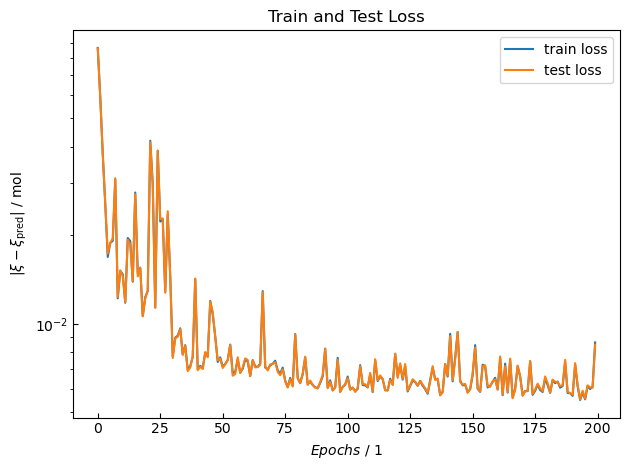

In [9]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

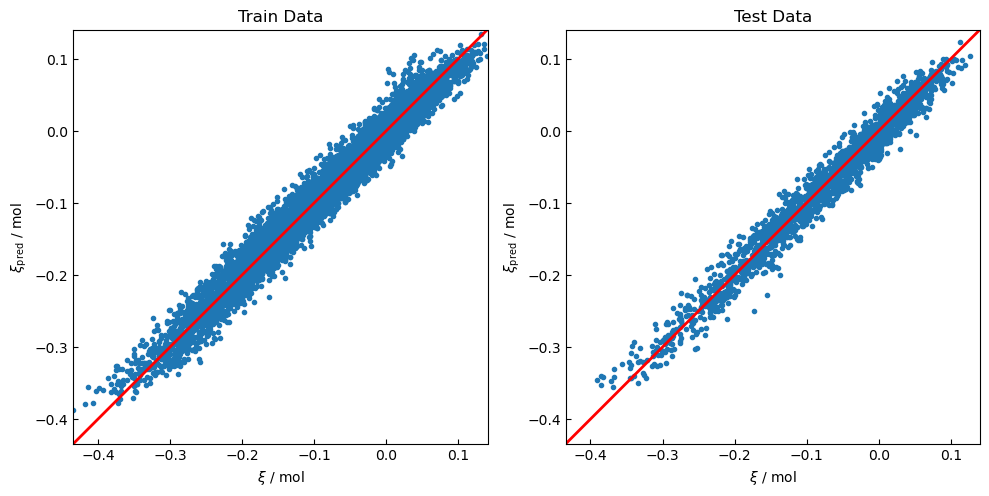

In [10]:
xi_real = []
xi_pred = []
for (X,y) in train_dataloader:
    xi_real = np.append(xi_real, y.numpy())
    xi_pred = np.append(xi_pred, net(X).detach().numpy())

xi_real_test = []
xi_pred_test = []
for (X,y) in test_dataloader:
    xi_real_test = np.append(xi_real_test, y.numpy())
    xi_pred_test = np.append(xi_pred_test, net(X).detach().numpy())

# find the boundaries of X and Y values
bounds = (min(xi_real.min(), xi_pred.min()) - int(0.1 * xi_pred.min()), max(xi_real.max(), xi_pred.max())+ int(0.1 * xi_pred.max()))

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(xi_real, xi_pred, '.')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(xi_real_test, xi_pred_test, '.')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

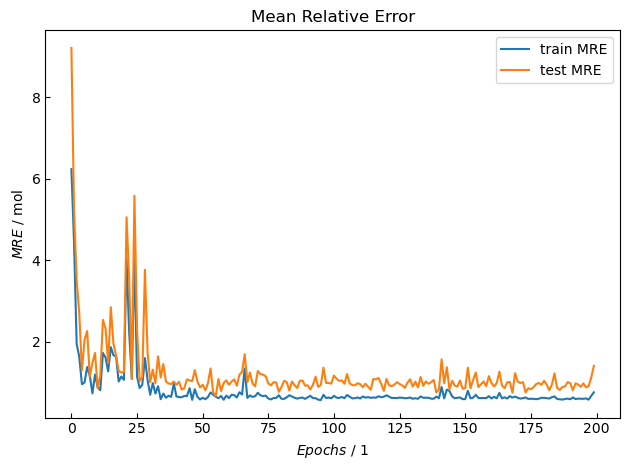

In [11]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_MRE, label='train MRE')
ax.plot(test_MRE, label='test MRE')
plt.title("Mean Relative Error")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

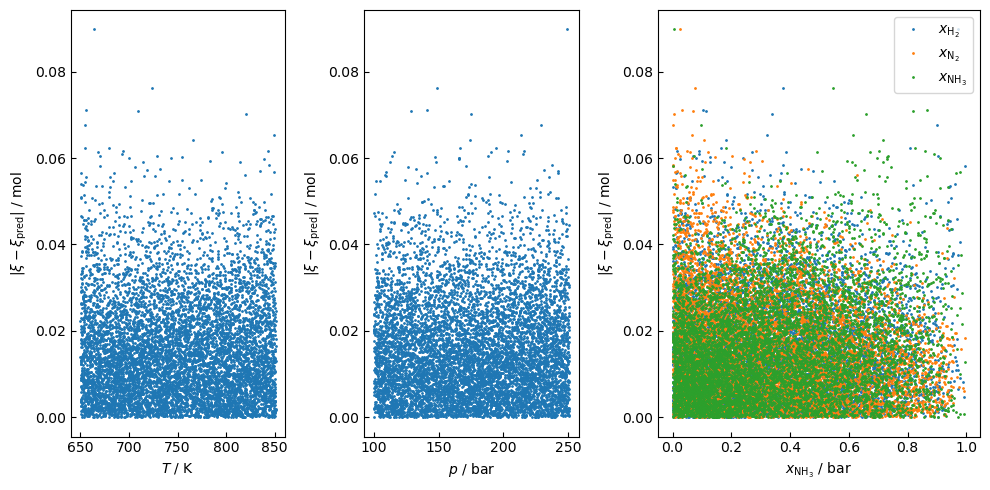

In [12]:
mistake = []
param_T = []
param_p = []
param_x_H2 = []
param_x_N2 = []
param_x_NH3 = []
for X,y in train_dataloader:
    mistake = np.append(mistake, abs(y - net(X).detach().numpy()))
    param_T = np.append(param_T, X[:,0])
    param_p = np.append(param_p, X[:,1])
    param_x_H2 = np.append(param_x_H2, X[:,2])
    param_x_N2 = np.append(param_x_N2, X[:,3])
    param_x_NH3 = np.append(param_x_NH3, X[:,4])
    
# train_parameters, train_xi = next(iter(train_dataloader))
# y = abs(train_xi - net(train_parameters).detach().numpy())
# #[T, p ,x_H2, x_N2, x_NH3]
# x = [train_parameters[:,0], train_parameters[:,1], train_parameters[:,2], train_parameters[:,3], train_parameters[:,4]]

# print(param_T[0])
# print(param_T)
# print(mistake)

fig,ax = plt.subplots(1,3, figsize = (10, 5), gridspec_kw={'width_ratios': [2,2,3]})

ax[0].plot(param_T, mistake, '.', markersize = 2)
ax[0].set(xlabel = '$T$ / K', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)

ax[1].plot(param_p, mistake, '.', markersize = 2)
ax[1].set(xlabel = '$p$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)

ax[2].plot(param_x_H2, mistake, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[2].plot(param_x_N2, mistake, '.', markersize = 2, label = '$x\mathregular{_{N_2}}$')
ax[2].plot(param_x_NH3, mistake, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[2].set(xlabel = '$x\mathregular{_{NH_3}}$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[2].tick_params(direction = 'in') #, length = 20, width = 3)
ax[2].set

plt.legend()
plt.tight_layout()
plt.show()

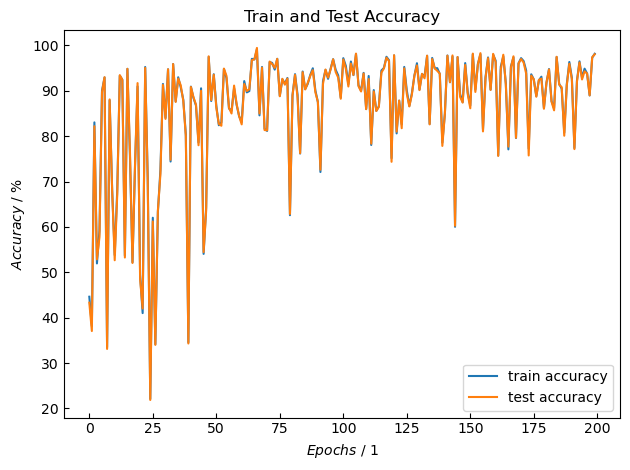

In [13]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [14]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y.reshape((-1,1)))
    print(net(X))
    break

tensor([[6.8770e+02, 1.9331e+02, 2.5903e-01, 2.8741e-01, 4.5356e-01],
        [8.5070e+02, 2.1031e+02, 4.2552e-01, 3.7470e-01, 1.9978e-01],
        [7.6725e+02, 1.7563e+02, 1.9704e-01, 2.6091e-01, 5.4205e-01],
        [7.1270e+02, 1.7669e+02, 7.6219e-01, 4.1129e-02, 1.9668e-01],
        [6.5979e+02, 1.3901e+02, 6.1835e-02, 3.5623e-01, 5.8194e-01],
        [7.4421e+02, 1.2740e+02, 2.6441e-01, 6.2881e-01, 1.0678e-01],
        [6.7760e+02, 1.9565e+02, 6.6837e-01, 1.1301e-01, 2.1862e-01],
        [6.6625e+02, 1.2081e+02, 3.9046e-01, 4.5643e-01, 1.5311e-01],
        [6.8138e+02, 1.5340e+02, 7.2753e-01, 1.7601e-01, 9.6464e-02],
        [7.4015e+02, 1.4639e+02, 5.7118e-03, 9.1451e-01, 7.9775e-02],
        [6.6713e+02, 2.2438e+02, 2.1991e-01, 3.8925e-02, 7.4116e-01],
        [6.6775e+02, 1.1047e+02, 1.0550e-01, 5.4677e-01, 3.4773e-01],
        [7.0896e+02, 1.5077e+02, 8.0591e-01, 5.0458e-03, 1.8904e-01],
        [8.2574e+02, 1.9638e+02, 3.8461e-01, 1.2983e-01, 4.8555e-01],
        [7.5665e+02,

#### Einblick in Netzwerk

In [15]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([0.1575, 0.1226, 0.1731, 0.1604, 0.1699], requires_grad=True),
 Parameter containing:
 tensor([-0.0081,  0.0001,  0.0166,  0.0141,  0.0038], requires_grad=True),
 Parameter containing:
 tensor([[ 5.7705e-03,  4.6765e-02, -1.5921e-02, -1.3772e-01, -2.8893e-01],
         [-1.3702e-02, -7.2420e-03, -1.3800e-01, -1.5010e-01, -1.3960e-01],
         [ 4.0921e-02, -6.0476e-03,  1.3511e-01,  1.3927e-01,  1.0355e-01],
         [-1.9964e-02, -2.4128e-02, -1.1672e-01, -1.5357e-01, -1.2191e-01],
         [-1.3525e-02, -1.3791e-02, -1.1524e-01, -1.2758e-01, -1.0388e-01],
         [-1.3545e-02, -2.2741e-02,  4.6581e-02,  1.4251e-02,  2.4601e-02],
         [ 3.3141e-02, -5.4900e-02,  7.5903e-02,  9.3255e-04, -8.3045e-03],
         [ 3.2510e-02, -3.2845e-02,  9.8996e-02,  1.2284e-01,  9.1005e-02],
         [-2.8213e-02,  7.1741e-03,  6.3576e-02,  5.0254e-02,  5.3353e-02],
         [ 2.1426e-02, -4.8359e-02,  1.3230e-02, -4.3137e-02, -3.9042e-02],
         [-3.5743e-02,  

In [16]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.5304, 0.5070, 0.2612, 0.1520, 0.8605],
        [0.6194, 0.1672, 0.3754, 0.3235, 0.3977]])
tensor([[-0.1761],
        [-0.0044]], grad_fn=<AddmmBackward0>)


In [17]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [18]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    break

tensor([[6.7619e+02, 1.8175e+02, 5.4326e-01, 3.3009e-01, 1.2666e-01],
        [7.8122e+02, 2.1935e+02, 3.3731e-01, 3.0653e-01, 3.5616e-01],
        [6.8710e+02, 2.4448e+02, 2.7587e-01, 6.6545e-01, 5.8671e-02],
        [6.6953e+02, 2.4334e+02, 2.4388e-01, 3.2311e-01, 4.3301e-01],
        [6.5361e+02, 2.4286e+02, 1.0120e-01, 2.3178e-01, 6.6703e-01],
        [8.1118e+02, 1.4268e+02, 4.0387e-02, 4.7464e-01, 4.8498e-01],
        [8.3129e+02, 2.1740e+02, 3.4283e-01, 5.6580e-01, 9.1370e-02],
        [7.1658e+02, 1.8747e+02, 2.8704e-01, 2.0605e-01, 5.0691e-01],
        [6.6310e+02, 1.6943e+02, 1.2187e-01, 1.5450e-01, 7.2364e-01],
        [6.9805e+02, 1.0843e+02, 1.5387e-01, 2.2903e-01, 6.1711e-01],
        [7.5928e+02, 1.1254e+02, 3.8763e-01, 1.9098e-01, 4.2139e-01],
        [6.6805e+02, 1.9806e+02, 2.1331e-01, 7.6601e-01, 2.0682e-02],
        [8.0226e+02, 2.1278e+02, 7.2162e-01, 1.5958e-01, 1.1881e-01],
        [7.3167e+02, 1.1271e+02, 7.7830e-01, 1.9004e-01, 3.1658e-02],
        [6.5514e+02,